# Implied Volatility and Greeks of 'At The Money' Index Options: Part 2: Expired Options and Python Type Hints

*In part 1:* we saw how we could (i) automatically find the Option (of choice) closest to [At The Money (ATM)](https://www.investopedia.com/terms/a/atthemoney.asp) and (ii) calculate its [Implied Volatility](https://www.investopedia.com/terms/i/iv.asp) & [Greeks](https://www.investopedia.com/terms/g/greeks.asp). We focus below on Future (Monthly) Options on the Index '.STOXX50E' (EURO STOXX 50 EUR PRICE INDEX) ('[EUREX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TVE9YWDUwJnN0PVJJQw%3D%3D&title=.STOXX50%20OV&key=bUq%2BNCiQGAcHQjSNEkJSlZLTgjo9cios8rz4heIBiU8%3D)') and '.SPX' ([S&P 500 INDEX](https://go.refinitiv.com/?u=Y3B1cmw6Ly9hcHBzLmNwLi9BcHBzL0luZGV4Lz9zPS5TUFgmc3Q9UklDIy8%3D&title=.SPX%20OV&key=21C0FJ4FZsZ4s9b6HR4mDSAIHId9rxFOgaCjslcqIVk%3D)), although you can apply the logic below for another index.
To find the ATM instrument, we simply and efficiently use the [Search API](https://developers.refinitiv.com/en/article-catalog/article/building-search-into-your-application-workflow).
Usually, the calculation of the Black-Scholes-Merton model's Implied Volatility involves numerical techniques, since it is not a [closed equation](https://en.wikipedia.org/wiki/Closed-form_expression) ([unless restricting assumptions that log returns follow a standard normal distribution with mean is zero, $\mu$ = 0, and standard deviation is zero, $\sigma$ = 1, are made](https://corporatefinanceinstitute.com/resources/derivatives/black-scholes-merton-model/)). If we used these techniques in calculating each Implied Volatility value on our computer, it would take several seconds - if not minutes - for each data point computed. I have chosen to use the [Instrument Pricing Analytics (IPA)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis/documentation#ipa-financial-contracts-option-contracts-eti) service in the Python [Refinitiv Data Library](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-libraries) instead, as this service allows me to send model specifications (and variables) and receive several (up to 100) computed Implied Volatility values in one go - in a few seconds. Not only does this save a great deal of time, but also many lines of code! Fianlly, we will put it all in one function.

*In part 2:* We will now implement a functionality allowing us to apply all we did in Part 1 to expiered options. You'll see, it's not as simple as it seems. We will then put it all in one function [*using Type Hints*](https://peps.python.org/pep-3107/#use-cases). This, in itself, will also be rather new and exciting!

In [2]:
import refinitiv.data as rd  # This is LSEG's Data and Analytics' API wrapper, called the Refinitiv Data Library for Python. You can update this library with the comand `!pip install refinitiv-data --upgrade`
from refinitiv.data.content import historical_pricing  # We will use this Python Class in `rd` to show the Implied Volatility data already available before our work.
from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need thtis to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need thtis to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

import numpy as np  # We need `numpy` for mathematical and array manipilations.
import pandas as pd  # We need `pandas` for datafame and array manipilations.
import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta, timezone  # We use these to manipulate time values
from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.
import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below

# `plotly` is a library used to render interactive graphs:
import plotly.graph_objects as go
import plotly.express as px  # This is just to see the implied vol graph when that field is available
import matplotlib.pyplot as plt  # We use `matplotlib` to just in case users do not have an environment suited to `plotly`.
from IPython.display import clear_output, display  # We use `clear_output` for users who wish to loop graph production on a regular basis. We'll use this to `display` data (e.g.: pandas data-frames).
from plotly import subplots
import plotly

Now let's open our session with RD. You can find more information about sessions on [EX-4.01.01-Sessions.ipynb](https://github.com/Refinitiv-API-Samples/Example.DataLibrary.Python/blob/main/Examples/4-Session/EX-4.01.01-Sessions.ipynb).

In [3]:
try:
    rd.open_session(
        name="desktop.workspace4",  # "platform.rdph", "desktop.workspace4"
        config_name="C:/Example.DataLibrary.Python-main/Configuration/refinitiv-data.config.json")
    print("We're on 'desktop.workspace4' Session")
except:
    rd.open_session()
    print("We're on Desktop Session")
# For more info on the session, use `rd.get_config().as_dict()`

We're on 'desktop.workspace4' Session


In [3]:
tst = rd.content.historical_pricing.summaries.Definition(
    universe='STXE42500D3.EX^D23', start='2021-08-29', end='2023-04-21', interval='PT10M', fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']).get_data().data.df

In [4]:
tst

STXE42500D3.EX^D23,TRDPRC_1,SETTLE,BID,ASK
Timestamp,,,,
2022-11-17 08:40:00,55.0,<NA>,<NA>,<NA>
2022-11-28 15:40:00,59.9,<NA>,<NA>,<NA>
2022-12-02 13:50:00,61.1,<NA>,<NA>,<NA>
2022-12-05 07:50:00,<NA>,<NA>,59.1,63.8
2022-12-05 08:00:00,<NA>,<NA>,58.9,61.2
...,...,...,...,...
2023-04-20 14:50:00,<NA>,<NA>,137.6,140.1
2023-04-20 15:00:00,<NA>,<NA>,133.3,136.2
2023-04-20 15:10:00,<NA>,<NA>,134.5,136.6


In [7]:
for i, j in zip(
    ['refinitiv.data', 'numpy', 'pandas', 'pandas_market_calendars' 'pytz', 'requests', 'plotly'],
    [rd, np, pd, mcal, pytz, requests, plotly]):
    print(f"{i} used in this code is version {j.__version__}")

refinitiv.data used in this code is version 1.3.0
numpy used in this code is version 1.23.1
pandas used in this code is version 1.3.5
pandas_market_calendarspytz used in this code is version 4.1.4
requests used in this code is version 2022.1
plotly used in this code is version 2.28.1


FYI (For Your Information), this is out Python version:

In [8]:
!python -V

Python 3.10.5


## Finding Expired Options

The code in the cell below was written expertly by Haykaz Aramyan in the article ['Functions to find Option RICs traded on different exchanges'](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges). I wanted to introduce in part 2 of this (current) article as it uses complex Python notions such as [Classes](https://www.w3schools.com/python/python_classes.asp). We look into reconstructing expired option RICs which have different nomenclatures to live ones:

<img src="https://developers.refinitiv.com/content/dam/devportal/articles/options-backtesting/ric2.jpg.transform/resize-768/q82/image.jpg">

Below, we put ourselves in the shoes of an analyst backtesting a strategy involving past historical Implied Volatilities. E.g.: if the average 3-business-day historical Implied Volatility of an Option contract is too high, (s)he would not consider it in his(/her) portfolio.

Something to keep in mind is that **no intraday price data is available for options that expired 3 months (or more) prior**, therefore, when intraday data is not available, daily data will be used.

### STOXX50E Usecase

Let's focuss on STOXX50E.

In [9]:
calc_time, underlying = "2022-04-01", ".STOXX50E"
calc_time_datetime = datetime.strptime(calc_time, '%Y-%m-%d')
current_underlying_prc = rd.get_history(
    universe=[underlying],
    start=calc_time,  # , end: "OptDateTime"=None
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]
current_underlying_prc

4141.63

In [10]:
if underlying == ".STOXX50E":
    exchange, exchangeRIC, mcal_cal = "EUX", "STX", "EUREX"
elif underlying == ".SPX":
    exchange, exchangeRIC, mcal_cal = "OPQ", "SPX", "CBOE_Futures"
exchange, exchangeRIC, mcal_cal

('EUX', 'STX', 'EUREX')

Now we can ge the expiry dates for our new senario, based on a time of calculation on "2022-04-01": 

In [11]:
def Get_exp_dates(year, days=True, mcal_get_calendar='EUREX'):
    '''
    Get_exp_dates Version 2.0:

    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
        (i) function name changed from `get_exp_dates` to `Get_exp_dates`
        (ii) for the function's holiday argument to be changed, allowing for any calendar supported by `mcal.get_calendar` and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
        (iii) for the function to output full date objects as opposed to just days of the month if agument days=True.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version '3.2'.
    pandas_market_calendars as mcal version '4.1.0'.

    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested

        mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        days(bool): If True, only days of the month is outputed, else it's dataeime objects
            Default: days=True

    Output:
        dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
    '''

    # get CBOE market holidays
    EUREXCal = mcal.get_calendar(mcal_get_calendar)
    holidays = EUREXCal.holidays().holidays

    # set calendar starting from Saturday
    c = calendar.Calendar(firstweekday=calendar.SATURDAY)

    # get the 3rd Friday of each month
    exp_dates = {}
    for i in range(1, 13):
        monthcal = c.monthdatescalendar(year, i)
        date = monthcal[2][-1]
        # check if found date is an holiday and get the previous date if it is
        if date in holidays:
            date = date + timedelta(-1)
        # append the date to the dictionary
        if year in exp_dates:
            ### Changed from original code from here on by Jonathan Legrand on 2022-10-11
            if days: exp_dates[year].append(date.day)
            else: exp_dates[year].append(date)
        else:
            if days: exp_dates[year] = [date.day]
            else: exp_dates[year] = [date]
    return exp_dates

In [12]:
calc_full_dates_time = Get_exp_dates(
    year=2022, days=False,
    mcal_get_calendar=mcal_cal)
calc_full_dates_time

{2022: [datetime.date(2022, 1, 21),
  datetime.date(2022, 2, 18),
  datetime.date(2022, 3, 18),
  datetime.date(2022, 4, 14),
  datetime.date(2022, 5, 20),
  datetime.date(2022, 6, 17),
  datetime.date(2022, 7, 15),
  datetime.date(2022, 8, 19),
  datetime.date(2022, 9, 16),
  datetime.date(2022, 10, 21),
  datetime.date(2022, 11, 18),
  datetime.date(2022, 12, 16)]}

In [13]:
calc_full_dates_time_datetime = [
    datetime(i.year, i.month, i.day)
    for i in calc_full_dates_time[list(calc_full_dates_time.keys())[0]]]
calc_full_dates_time_datetime

[datetime.datetime(2022, 1, 21, 0, 0),
 datetime.datetime(2022, 2, 18, 0, 0),
 datetime.datetime(2022, 3, 18, 0, 0),
 datetime.datetime(2022, 4, 14, 0, 0),
 datetime.datetime(2022, 5, 20, 0, 0),
 datetime.datetime(2022, 6, 17, 0, 0),
 datetime.datetime(2022, 7, 15, 0, 0),
 datetime.datetime(2022, 8, 19, 0, 0),
 datetime.datetime(2022, 9, 16, 0, 0),
 datetime.datetime(2022, 10, 21, 0, 0),
 datetime.datetime(2022, 11, 18, 0, 0),
 datetime.datetime(2022, 12, 16, 0, 0)]

Remember, in this use-case, I would like to know what is the next Future (Monthly) Option (i) on the Index '.STOXX50E' (ii) closest to ATM (i.e.: with an underlying spot price closest to the option's strike price) and (iii) Expiring in more than x days (i.e.: not too close to calculated time 't'), let's say 15 days:

In [14]:
x = 15

In [15]:
expiry_date_of_intrst = [i for i in calc_full_dates_time_datetime
                    if i > calc_time_datetime + relativedelta(days=x)][0]
expiry_date_of_intrst

datetime.datetime(2022, 5, 20, 0, 0)

We'll need new functions `Get_exp_month` and `Check_RIC`:

In [16]:
def Get_exp_month(exp_date, opt_type):

    # define option expiration identifiers
    ident = {
        '1':  {'exp': 'A', 'C': 'A', 'P': 'M'},
        '2':  {'exp': 'B', 'C': 'B', 'P': 'N'},
        '3':  {'exp': 'C', 'C': 'C', 'P': 'O'},
        '4':  {'exp': 'D', 'C': 'D', 'P': 'P'},
        '5':  {'exp': 'E', 'C': 'E', 'P': 'Q'},
        '6':  {'exp': 'F', 'C': 'F', 'P': 'R'},
        '7':  {'exp': 'G', 'C': 'G', 'P': 'S'},
        '8':  {'exp': 'H', 'C': 'H', 'P': 'T'},
        '9':  {'exp': 'I', 'C': 'I', 'P': 'U'},
        '10': {'exp': 'J', 'C': 'J', 'P': 'V'},
        '11': {'exp': 'K', 'C': 'K', 'P': 'W'},
        '12': {'exp': 'L', 'C': 'L', 'P': 'X'}}

    # get expiration month code for a month
    if opt_type.upper() == 'C':
        exp_month = ident[str(exp_date.month)]['C']
    elif opt_type.upper() == 'P':
        exp_month = ident[str(exp_date.month)]['P']

    return ident, exp_month

Now things are getting tricky.
Certain Expiered Options do not have `TRDPRC_1` data historically. Some don't have `SETTLE`. Some have both...
The below should capture `TRDPRC_1` when it is available, but `SETTLE` might still be present in these instances.
So we will need to build a logic to focus on the series with the most datapoints.
Specifically: Get `TRDPRC_1`. If there are fewer `TRDPRC_1` datapoionts than days (i.e.: if there's only daily data for this field), get `SETTLE`. Same again, if not `SETTLE`, then get the midpoint between `BID` and `ASK`.

In [17]:
def Check_RIC(
        ric,
        maturity,
        ident,
        interval=rd.content.historical_pricing.Intervals.DAILY):

    exp_date = pd.Timestamp(maturity)

    # get start and end date for get_historical_price_summaries
    # query (take current date minus 90 days period)
    sdate = (datetime.now() - timedelta(90)).strftime('%Y-%m-%d')
    edate = datetime.now().strftime('%Y-%m-%d')

    # check if option is matured. If yes, add expiration syntax and recalculate
    # start and end date of the query (take expiration day minus 90 days period)
    if pd.Timestamp(maturity) < datetime.now():
        ric = ric + '^' + ident[str(exp_date.month)]['exp'] + str(exp_date.year)[-2:]
        sdate = (exp_date - timedelta(90)).strftime('%Y-%m-%d')
        edate = exp_date.strftime('%Y-%m-%d')

    # Now things are getting tricky.
    # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
    # The below should capture 'SETTLE' when it is available, then 'TRDPRC_1' if not, then MID (calculated with 'ASK' and 'BID') otherwise.
    prices = rd.content.historical_pricing.summaries.Definition(
            universe=ric,
            start=sdate,
            end=edate,
            interval=interval,
            fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']
            ).get_data().data.df
    pr_cnt = prices.count()
    if pr_cnt.TRDPRC_1 > 0:
        prices = pd.DataFrame(
            data={'TRDPRC_1': prices.TRDPRC_1}).dropna()
    elif pr_cnt.SETTLE > 0:
        prices = pd.DataFrame(
            data={'SETTLE': prices.SETTLE}).dropna()
    elif pr_cnt.BID > 0:
        prices = pd.DataFrame(
            data={'MID': (prices.BID + prices.ASK)/2}).dropna()
    prices.columns.name = ric

    return ric, prices

Now we can get EUREX RIC:

In [18]:
def Get_RIC_eurex(asset, maturity, strike, opt_type, interval='PT10M'):
    exp_date = pd.Timestamp(maturity)

    if asset[0] == '.':
        asset_name = asset[1:]
        if asset_name == 'FTSE':
            asset_name = 'OTUK'
        elif asset_name == 'SSMI':
            asset_name = 'OSMI'
        elif asset_name == 'GDAXI':
            asset_name = 'GDAX'
        elif asset_name == 'ATX':
            asset_name = 'FATXA'
        elif asset_name == 'STOXX50E':
            asset_name = 'STXE'
    else:
        asset_name = asset.split('.')[0]

    ident, exp_month = Get_exp_month(
        exp_date=exp_date, opt_type=opt_type)

    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]
    else:
        int_part = int(strike)
        dec_part = '0'

    if len(str(int(strike))) == 1:
        strike_ric = '0' + str(int_part) + dec_part
    else:
        strike_ric = str(int_part) + dec_part

    possible_rics = []
    generations = ['', 'a', 'b', 'c', 'd']
    for gen in generations:
        ric = asset_name + strike_ric + gen + exp_month + str(exp_date.year)[-1:] + '.EX'
        ric, prices = Check_RIC(ric=ric, maturity=maturity, ident=ident,
                                interval=rd.content.historical_pricing.Intervals.DAILY)
        if prices is not None:
            return ric, prices
        else:
            possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return ric, prices

Note that this function, `Get_RIC_eurex`, needs a round number as strike price:

In [19]:
print(f"{current_underlying_prc} as int: {int(round(current_underlying_prc, -2))}")

4141.63 as int: 4100


In [20]:
instrument, instrument_pr = Get_RIC_eurex(
    asset='.STOXX50E', opt_type='P',
    maturity=expiry_date_of_intrst.strftime('%Y-%m-%d'),
    strike=int(round(current_underlying_prc, -2)))

In [21]:
# rd.content.historical_pricing.summaries.Definition(
#     universe='STXE44000Q2.EX^E22', start='2022-02-21', end='2022-05-20',
#     interval=rd.content.historical_pricing.Intervals.DAILY, fields='BID').get_data().data.df

In [22]:
instrument

'STXE41000Q2.EX^E22'

In [23]:
instrument_pr

STXE41000Q2.EX^E22,TRDPRC_1
Date,
2022-02-22,269.8
2022-02-28,363.0
2022-03-01,380.7
2022-03-04,576.8
2022-03-15,551.2
2022-03-22,286.5
2022-04-04,286.1
2022-04-12,345.9
2022-04-13,350.0


### General Usecase

Above we looked at the specific usecase with EUREX, let's generalise it:

## Creating a class with [PEP 3107](https://peps.python.org/pep-3107/#use-cases) (a.k.a.: Type Hints)

We are now going to look into [using PEP 3107](https://stackoverflow.com/questions/2489669/how-do-python-functions-handle-the-types-of-parameters-that-you-pass-in) (and [PEP 484](https://stackoverflow.com/questions/2489669/how-do-python-functions-handle-the-types-of-parameters-that-you-pass-in#:~:text=the%20introduction%20of-,PEP%20484,-which%20introduces%20a)) (and some [decorators](https://realpython.com/primer-on-python-decorators)). In line with PEP, I will also now use [PEP8](https://peps.python.org/pep-0008/) naming conventions.

In [24]:
# pip install --trusted-host files.pythonhosted.org nb_mypy # This line can be used to install `nb_mypy`.

In [25]:
import nb_mypy  # !pip3 install nb_mypy --trusted-host pypi.org # https://pypi.org/project/nb-mypy/ # https://gitlab.tue.nl/jupyter-projects/nb_mypy/-/blob/master/Nb_Mypy.ipynb
%load_ext nb_mypy
%reload_ext nb_mypy
%nb_mypy On
%nb_mypy DebugOff

Version 1.0.5
Version 1.0.5


Let's test our Type Hint library:

In [26]:
def myfunc(myparam: int) -> None:
    print(myparam)

myfunc('test')

<cell>4: error: Argument 1 to "myfunc" has incompatible type "str"; expected "int"  [arg-type]


test


Now let's recreate what we did above, but with Type Hints. We will alsop continue using them from now on.

In [27]:
import refinitiv.data as rd  # This is LSEG's Data and Analytics' API wrapper, called the Refinitiv Data Library for Python. You can update this library with the comand `!pip install refinitiv-data --upgrade`
from refinitiv.data.content import historical_pricing  # We will use this Python Class in `rd` to show the Implied Volatility data already available before our work.
from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need thtis to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

import numpy as np  # We need `numpy` for mathematical and array manipilations.
import pandas as pd  # We need `pandas` for datafame and array manipilations.
import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`. To get the Type Hints for this library, try `pip install types-pytz`.
import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, date, timedelta, timezone  # We use these to manipulate time values
from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library. May also need `pip install types-python-dateutil`.
import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below. Might also need `pip install types-requests`.

# `plotly` is a library used to render interactive graphs:
import plotly.graph_objects as go
import plotly.express as px  # This is just to see the implied vol graph when that field is available
import matplotlib.pyplot as plt  # We use `matplotlib` to just in case users do not have an environment suited to `plotly`.
from IPython.display import clear_output, display  # We use `clear_output` for users who wish to loop graph production on a regular basis. We'll use this to `display` data (e.g.: pandas data-frames).
from plotly import subplots
import plotly

from typing import Generator, Any
from types import ModuleType  # FrameType, TracebackType

In [28]:
try:
    rd.open_session(
        name="desktop.workspace",
        config_name="C:/Example.DataLibrary.Python-main/Configuration/refinitiv-data.config.json")
except:
    rd.open_session()
# For more info on the session, use `rd.get_config().as_dict()`

In [29]:
i_str: str
i_ModType: ModuleType

for i_str, i_ModType in zip(
    ['refinitiv.data', 'numpy', 'pandas', 'pandas_market_calendars' 'pytz', 'requests', 'plotly'],
    [rd, np, pd, mcal, pytz, requests, plotly]):
    print(f"{i_str} used in this code is version {i_ModType.__version__}")

refinitiv.data used in this code is version 1.3.0
numpy used in this code is version 1.23.1
pandas used in this code is version 1.3.5
pandas_market_calendarspytz used in this code is version 4.1.4
requests used in this code is version 2022.1
plotly used in this code is version 2.28.1


In [30]:
calc_time: str = "2022-04-01"
underlying: str = ".STOXX50E"

calc_time_datetime: datetime = datetime.strptime(calc_time, '%Y-%m-%d')
current_underlying_prc: float = rd.get_history(
    universe=[underlying],
    start=calc_time,  # , end: "OptDateTime"=None
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]

current_underlying_prc

4139.28

In [31]:
exchange: str
exchangeRIC: str
mcal_cal: str
if underlying == ".STOXX50E":
    exchange, exchangeRIC, mcal_cal = "EUX", "STX", "EUREX"
elif underlying == ".SPX":
    exchange, exchangeRIC, mcal_cal = "OPQ", "SPX", "CBOE_Futures"
exchange, exchangeRIC, mcal_cal

('EUX', 'STX', 'EUREX')

In [32]:
def Get_exp_dates(year: int,
                  days: bool = True,
                  mcal_get_calendar: str = 'EUREX'
                  ) -> dict[int, list[Any]]:
    '''
    Get_exp_dates Version 3.0: Get_exp_dates(year: int,days: bool = True, mcal_get_calendar: str = 'EUREX') -> Dict[int, List[date | int]]:  # Why doesn't `list[date | int]` work?

    This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
        (i) function name changed from `get_exp_dates` to `Get_exp_dates`
        (ii) for the function's holiday argument to be changed, allowing for any calendar supported by
            `mcal.get_calendar` and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
        (iii) for the function to output full date objects as opposed to just days of the month if
            agument days=True.
    Changed from Version 2.0 to 3.0: Jonathan Legrand changed the function to include Type Hints.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version '3.2'.
    pandas_market_calendars as mcal version '4.1.0'.

    Parameters
    -----------------------------------------------
    Input:
        year(int): year for which expiration days are requested

        mcal_get_calendar(str): String of the calendar for which holidays have to be taken into account.
            More on this calendar (link to Github checked 2022-10-11):
            https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        days(bool): If True, only days of the month is outputed, else it's dataeime objects
            Default: days=True

    Output:
        dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
    '''

    # get CBOE market holidays
    holidays: tuple[date] = mcal.get_calendar(mcal_get_calendar).holidays().holidays

    # set calendar starting from Saturday
    c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)

    # get the 3rd Friday of each month
    exp_dates: dict[int, list[Any]]
    _date: date
    i_int: int

    _date = c.monthdatescalendar(year, 1)[2][-1]
    if _date in holidays: # check if found date is an holiday and get the previous date if it is
        _date = _date + timedelta(-1)
    if days:
        exp_dates = {year:[_date.day]}
    else:
        exp_dates = {year: [_date]}
    for i_int in range(2, 13):
        _date = c.monthdatescalendar(year, i_int)[2][-1]
        if _date in holidays: # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        # append the date to the dictionary
        if days:
            exp_dates[year].append(_date.day)
        else:
            exp_dates[year].append(_date)

    return exp_dates

In [33]:
Get_exp_dates.__annotations__

{'year': int,
 'days': bool,
 'mcal_get_calendar': str,
 'return': dict[int, list[typing.Any]]}

In [34]:
calc_full_dates_time: dict[int, list[Any]] = Get_exp_dates(
    year=2022, days=False,
    mcal_get_calendar=mcal_cal)

In [35]:
calc_full_dates_time[list(calc_full_dates_time.keys())[0]]

[datetime.date(2022, 1, 21),
 datetime.date(2022, 2, 18),
 datetime.date(2022, 3, 18),
 datetime.date(2022, 4, 14),
 datetime.date(2022, 5, 20),
 datetime.date(2022, 6, 17),
 datetime.date(2022, 7, 15),
 datetime.date(2022, 8, 19),
 datetime.date(2022, 9, 16),
 datetime.date(2022, 10, 21),
 datetime.date(2022, 11, 18),
 datetime.date(2022, 12, 16)]

In [36]:
x: int = 15
expiry_date_of_intrst: datetime = [
    datetime(i_date.year, i_date.month, i_date.day)
    for i_date in calc_full_dates_time[list(calc_full_dates_time.keys())[0]]
    if datetime(i_date.year, i_date.month, i_date.day) > calc_time_datetime + relativedelta(days=x)][0]
expiry_date_of_intrst

datetime.datetime(2022, 5, 20, 0, 0)

In [37]:
def Get_exp_month(
    exp_date: datetime,
    opt_type: str
    ) -> tuple[dict[int, dict[str, str]], str]:

    # define option expiration identifiers
    ident: dict[int, dict[str, str]] = {
        1:  {'exp': 'A', 'C': 'A', 'P': 'M'},
        2:  {'exp': 'B', 'C': 'B', 'P': 'N'},
        3:  {'exp': 'C', 'C': 'C', 'P': 'O'},
        4:  {'exp': 'D', 'C': 'D', 'P': 'P'},
        5:  {'exp': 'E', 'C': 'E', 'P': 'Q'},
        6:  {'exp': 'F', 'C': 'F', 'P': 'R'},
        7:  {'exp': 'G', 'C': 'G', 'P': 'S'},
        8:  {'exp': 'H', 'C': 'H', 'P': 'T'},
        9:  {'exp': 'I', 'C': 'I', 'P': 'U'},
        10: {'exp': 'J', 'C': 'J', 'P': 'V'},
        11: {'exp': 'K', 'C': 'K', 'P': 'W'},
        12: {'exp': 'L', 'C': 'L', 'P': 'X'}}

    # get expiration month code for a month
    exp_month: str
    if opt_type.upper() == 'C' or opt_type.upper() == 'CALL':
        exp_month = ident[int(exp_date.month)]['C']
    elif opt_type.upper() == 'P' or opt_type.upper() == 'PUT':
        exp_month = ident[int(exp_date.month)]['P']

    return ident, exp_month

In [38]:
Get_exp_month(
    exp_date=datetime(2022, 5, 20, 0, 0),
    opt_type='P'
)

({1: {'exp': 'A', 'C': 'A', 'P': 'M'},
  2: {'exp': 'B', 'C': 'B', 'P': 'N'},
  3: {'exp': 'C', 'C': 'C', 'P': 'O'},
  4: {'exp': 'D', 'C': 'D', 'P': 'P'},
  5: {'exp': 'E', 'C': 'E', 'P': 'Q'},
  6: {'exp': 'F', 'C': 'F', 'P': 'R'},
  7: {'exp': 'G', 'C': 'G', 'P': 'S'},
  8: {'exp': 'H', 'C': 'H', 'P': 'T'},
  9: {'exp': 'I', 'C': 'I', 'P': 'U'},
  10: {'exp': 'J', 'C': 'J', 'P': 'V'},
  11: {'exp': 'K', 'C': 'K', 'P': 'W'},
  12: {'exp': 'L', 'C': 'L', 'P': 'X'}},
 'Q')

In [39]:
datetime.strptime(expiry_date_of_intrst.strftime('%Y-%m-%d'), '%Y-%m-%d')

datetime.datetime(2022, 5, 20, 0, 0)

In [40]:
(datetime.strptime(expiry_date_of_intrst.strftime('%Y-%m-%d'), '%Y-%m-%d')  - timedelta(90)).strftime('%Y-%m-%d')

'2022-02-19'

In [41]:
def Check_RIC(
        ric: str,
        maturity: str,
        ident: dict[int, dict[str, str]],
        interval: rd.content.historical_pricing.Intervals = rd.content.historical_pricing.Intervals.DAILY
        ) -> tuple[str, pd.DataFrame]:

    exp_date: pd.Timestamp = pd.Timestamp(maturity)

    # get start and end date for get_historical_price_summaries
    # query (take maturity date minus 90 days period)
    sdate: str = (datetime.strptime(maturity, '%Y-%m-%d') - timedelta(90)).strftime('%Y-%m-%d')
    edate: str = maturity

    # check if option is matured. If yes, add expiration syntax and recalculate
    # start and end date of the query (take expiration day minus 90 days period)
    if pd.Timestamp(maturity) < datetime.now():
        ric = ric + '^' + ident[int(exp_date.month)]['exp'] + str(exp_date.year)[-2:]
        sdate = (exp_date - timedelta(90)).strftime('%Y-%m-%d')
        edate = exp_date.strftime('%Y-%m-%d')

    # Now things are getting tricky.
    # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
    # The below should capture 'SETTLE' when it is available, then 'TRDPRC_1' if not, then MID (calculated with 'ASK' and 'BID') otherwise.
    prices: pd.DataFrame | None
    prices = rd.content.historical_pricing.summaries.Definition(
            universe=ric,
            start=sdate,
            end=edate,
            interval=interval,
            fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']
            ).get_data().data.df
    pr_cnt: pd.Series = prices.count()
    if pr_cnt.TRDPRC_1 > 0:
        prices = pd.DataFrame(
            data={'TRDPRC_1': prices.TRDPRC_1}).dropna()
    elif pr_cnt.SETTLE > 0:
        prices = pd.DataFrame(
            data={'SETTLE': prices.SETTLE}).dropna()
    elif pr_cnt.BID > 0:
        prices = pd.DataFrame(
            data={'MID': (prices.BID + prices.ASK)/2}).dropna()
    prices.columns.name = ric

    return ric, prices

In [42]:
# Check_RIC(
#     ric="STXE43000Q2.EX",  #"STXE43000Q2.EX^E22",".STOXX50E"
#     maturity=expiry_date_of_intrst.strftime('%Y-%m-%d'),
#     ident={1: {'exp': 'A', 'C': 'A', 'P': 'M'},
#         2: {'exp': 'B', 'C': 'B', 'P': 'N'},
#         3: {'exp': 'C', 'C': 'C', 'P': 'O'},
#         4: {'exp': 'D', 'C': 'D', 'P': 'P'},
#         5: {'exp': 'E', 'C': 'E', 'P': 'Q'},
#         6: {'exp': 'F', 'C': 'F', 'P': 'R'},
#         7: {'exp': 'G', 'C': 'G', 'P': 'S'},
#         8: {'exp': 'H', 'C': 'H', 'P': 'T'},
#         9: {'exp': 'I', 'C': 'I', 'P': 'U'},
#         10: {'exp': 'J', 'C': 'J', 'P': 'V'},
#         11: {'exp': 'K', 'C': 'K', 'P': 'W'},
#         12: {'exp': 'L', 'C': 'L', 'P': 'X'}})

In [43]:
def Get_RIC_eurex(
        asset: str,
        maturity: str,
        strike: int,
        opt_type: str,
        interval: rd.content.historical_pricing.Intervals = rd.content.historical_pricing.Intervals.DAILY
        ) -> tuple[str, pd.DataFrame]:
    exp_date = pd.Timestamp(maturity)

    asset_name: str
    ident: dict[int, dict[str, str]]
    exp_month: str
    dec_part: str
    strike_ric: str

    if asset[0] == '.':
        asset_name = asset[1:]
        if asset_name == 'FTSE':
            asset_name = 'OTUK'
        elif asset_name == 'SSMI':
            asset_name = 'OSMI'
        elif asset_name == 'GDAXI':
            asset_name = 'GDAX'
        elif asset_name == 'ATX':
            asset_name = 'FATXA'
        elif asset_name == 'STOXX50E':
            asset_name = 'STXE'
    else:
        asset_name = asset.split('.')[0]

    ident, exp_month = Get_exp_month(
        exp_date=exp_date, opt_type=opt_type)

    if type(strike) == float:
        int_part = int(strike)
        dec_part = str(str(strike).split('.')[1])[0]
    else:
        int_part = int(strike)
        dec_part = '0'

    if len(str(int(strike))) == 1:
        strike_ric = '0' + str(int_part) + dec_part
    else:
        strike_ric = str(int_part) + dec_part

    possible_rics: list = []
    generations: list[str] = ['', 'a', 'b', 'c', 'd']
    prices: pd.DataFrame
    for gen in generations:
        ric: str = asset_name + strike_ric + gen + exp_month + str(exp_date.year)[-1:] + '.EX'
        ric, prices = Check_RIC(ric=ric, maturity=maturity, ident=ident, interval=interval)
        if prices is not None:
            return ric, prices
        else:
            possible_rics.append(ric)
    print(f'Here is a list of possible RICs {possible_rics}, however we could not find any prices for those!')
    return ric, prices

In [44]:
instrument: str
instrument_pr: pd.DataFrame
instrument, instrument_pr = Get_RIC_eurex(
    asset='.STOXX50E', opt_type='P',
    maturity=expiry_date_of_intrst.strftime('%Y-%m-%d'),
    strike=int(round(current_underlying_prc, -2)))

In [45]:
instrument

'STXE41000Q2.EX^E22'

In [46]:
instrument_pr

STXE41000Q2.EX^E22,TRDPRC_1
Date,
2022-02-22,269.8
2022-02-28,363.0
2022-03-01,380.7
2022-03-04,576.8
2022-03-15,551.2
2022-03-22,286.5
2022-04-04,286.1
2022-04-12,345.9
2022-04-13,350.0


### Class 1: `OptionRIC`

In [47]:
class OptionRIC:
    """
    OptionRIC
    """

    def __init__(
        self,
        maturity: str,  # '2022-01-21'
        strike: int,
        opt_type: str,  # 'C' or 'pall' or 'P' or 'put' (not case sensitive)
        asset: str = ".STOXX50E",
        debug: bool = False,
        interval: rd.content.historical_pricing.Intervals = rd.content.historical_pricing.Intervals.MINUTE,
        mcal_get_calendar: str ='EUREX'
        ) -> None:

        # Most objects are simple to define at this stage, but soon you'll see that two of them are a little more finicky
        self.maturity: date = pd.Timestamp(maturity)
        self.strike: int = strike
        self.opt_type: str = opt_type
        self.debug: bool = debug
        self.asset: str = asset
        self.mcal_get_calendar: str = mcal_get_calendar
        self.interval: rd.content.historical_pricing.Intervals = interval


    def Get_exp_date(
        self,
        year: int,
        days: bool = True
        ) -> dict[int, list[Any]]:
        '''
        OptionRIC().Get_exp_dates Version 2.0: Get_exp_date(self, year: int, days: bool = True) -> dict[int, list[Any]]:

        This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

        Dependencies
        ----------------------------------------------
        Python library 'pandas_market_calendars' version '3.2'.
        pandas_market_calendars as mcal version '4.1.0'.

        Parameters
        -----------------------------------------------
        Input:
            year(int): year for which expiration days are requested

            days(bool): If True, only days of the month is outputed, else it's dataeime objects
                Default: days=True

        Output:
            dates(dict): dictionary of expiration days for each month of a specified year in datetime.date format.
        '''

        # get exchange market holidays
        holidays: tuple[date] = mcal.get_calendar(self.mcal_get_calendar).holidays().holidays

        # set calendar starting from Saturday
        c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)

        # get the 3rd Friday of each month
        exp_dates: dict[int, list[Any]]
        _date: date; i_int: int

        _date = c.monthdatescalendar(year, 1)[2][-1]
        if _date in holidays: # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        if days:
            exp_dates = {year:[_date.day]}
        else:
            exp_dates = {year: [_date]}
        for i_int in range(2, 13):
            _date = c.monthdatescalendar(year, i_int)[2][-1]
            if _date in holidays: # check if found date is an holiday and get the previous date if it is
                _date = _date + timedelta(-1)
            # append the date to the dictionary
            if days:
                exp_dates[year].append(_date.day)
            else:
                exp_dates[year].append(_date)

        return exp_dates


    def Check_RIC(
            self,
            ric: str,
            date_from: int = 600
            ) -> tuple[str, pd.DataFrame]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        maturity_dtime: pd.Timestamp = pd.Timestamp(self.maturity)
        sdate: str; edate: str
        if pd.Timestamp(self.maturity) < datetime.now():
            sdate = (maturity_dtime - timedelta(date_from)).strftime('%Y-%m-%d')
            edate = maturity_dtime.strftime('%Y-%m-%d')
        else:
            sdate = (datetime.now() - timedelta(90)).strftime('%Y-%m-%d')
            edate = datetime.now().strftime('%Y-%m-%d')
        if self.debug:
            print(f"Check_RIC's (ric, sdate, edate) = ('{ric}', '{sdate}', '{edate}')")

        # Now things are getting tricky.
        # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
        # The below should capture 'SETTLE' when it is available, then 'TRDPRC_1' if not, then MID (calculated with 'ASK' and 'BID') otherwise.
        prices: pd.DataFrame | None

        prices = rd.content.historical_pricing.summaries.Definition(
                universe=ric,
                start=sdate,
                end=edate,
                interval=self.interval,
                fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']
                ).get_data().data.df
        pr_cnt: pd.Series = prices.count()
        if self.debug:
            print("\n")
            print("prices1")
            display(prices)
            print("pr_cnt")
            display(pr_cnt)
            print("\n")
        if pr_cnt.TRDPRC_1 > 0:
            prices = pd.DataFrame(
                data={'TRDPRC_1': prices.TRDPRC_1}).dropna()
        elif pr_cnt.SETTLE > 0:
            prices = pd.DataFrame(
                data={'SETTLE': prices.SETTLE}).dropna()
        elif pr_cnt.BID > 0:
            prices = pd.DataFrame(
                data={'MID': (prices.BID + prices.ASK)/2}).dropna()
        prices.columns.name = ric


        # try:
        #     prices = rd.content.historical_pricing.summaries.Definition(
        #         universe=ric, start=sdate, end=edate, interval=self.interval, fields='TRDPRC_1').get_data().data.df
        #     if len(prices) < (datetime.strptime(edate[:10], "%Y-%m-%d") - datetime.strptime(sdate[:10], "%Y-%m-%d")).days/2:
        #         prices = rd.content.historical_pricing.summaries.Definition(
        #             universe=ric, start=sdate, end=edate, interval=self.interval, fields='SETTLE').get_data().data.df
        #         if len(prices) < (datetime.strptime(edate[:10], "%Y-%m-%d") - datetime.strptime(sdate[:10], "%Y-%m-%d")).days/2:
        #             prices = rd.content.historical_pricing.summaries.Definition(
        #                 universe=ric, start=sdate, end=edate, interval=self.interval, fields=['BID', 'ASK']).get_data().data.df
        #             prices = pd.DataFrame(
        #                 data={'MID': (prices.BID + prices.ASK)/2})
        #     prices.columns.name = ric
        # except:
        #     try:
        #         prices = rd.content.historical_pricing.summaries.Definition(
        #                 universe=ric, start=sdate, end=edate, interval=self.interval, fields='SETTLE').get_data().data.df
        #         if len(prices) < (datetime.strptime(edate[:10], "%Y-%m-%d") - datetime.strptime(sdate[:10], "%Y-%m-%d")).days/2:
        #             prices = rd.content.historical_pricing.summaries.Definition(
        #                 universe=ric, start=sdate, end=edate, interval=self.interval, fields=['BID', 'ASK']).get_data().data.df
        #             prices = pd.DataFrame(
        #                 data={'MID': (prices.BID + prices.ASK)/2})
        #         prices.columns.name = ric
        #     except:
        #         try:
        #             prices = rd.content.historical_pricing.summaries.Definition(
        #                 universe=ric, start=sdate, end=edate, interval=self.interval, fields=['BID', 'ASK']).get_data().data.df
        #             if self.debug:
        #                 print(f"Check_RIC's 3rd loop universe: {ric}")
        #                 print(f"Check_RIC's 3rd loop start: {sdate}")
        #                 print(f"Check_RIC's 3rd loop edate: {edate}")
        #                 print(f"Check_RIC's 3rd loop interval: {self.interval}")
        #                 display(prices)
        #                 print("Check_RIC's 3rd loop's Step 1: Create MID")
        #             prices = pd.DataFrame(data={'MID': (prices.BID + prices.ASK)/2})
        #             if self.debug:
        #                 print("Check_RIC's 3rd loop's Step 2: Add name of RIC to df")
        #             prices.columns.name = ric
        #             if self.debug:
        #                 print("Check_RIC's 3rd loop's Step 2 complete successfully, giving df:")
        #                 display(prices)
        #         except:
        #             prices = None
        #             print("The call for")
        #             print(f"rd.content.historical_pricing.summaries.Definition(universe={ric}, start={sdate}, end={edate}, interval={self.interval}, fields=['BID', 'ASK']).get_data().data.df")
        #             print("returned no data.")
        #             print("Please try another interval. Note that intra day data for Expiered Options are only available for 3 months after their expiry.")
        
        # if self.debug:
        #     print("Check_RIC's 3rd loop's Prices collected:")
        #     display(prices)

        return ric, prices


    def Get_asset_and_exchange(
            self,
            exchg_srch_top_nu_srch_results: int = 100
            ) -> dict[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        asset_in_ric: dict[str, dict[str, str]] = {
            'SSMI':     {'EUX': 'OSMI'},
            'GDAXI':    {'EUX': 'GDAX'},
            'ATX':      {'EUX': 'FATXA'},
            'STOXX50E': {'EUX': 'STXE'},
            'FTSE':     {'IEU': 'LFE', 'EUX': 'OTUK'},
            'N225':     {'OSA': 'JNI'},
            'TOPX':     {'OSA': 'JTI'}}

        i_dct_s_i: list[dict[str, str | int]]
        self.exchange: list[str] = [
            i_dct_s_i['Label'] for i_dct_s_i in search.Definition(
                query=self.asset,
                filter="SearchAllCategory eq 'Options' and Periodicity eq 'Monthly' ",
                select=' RIC, DocumentTitle, UnderlyingQuoteRIC, Periodicity, ExchangeCode',
                navigators="ExchangeCode",
                top=exchg_srch_top_nu_srch_results
                ).get_data().data.raw["Navigators"]["ExchangeCode"]['Buckets']]

        asset_exchange: dict[str, str] = {}
        asset: str
        if self.asset[0] != '.':
            asset = self.asset.split('.')[0]
        else:
            asset = self.asset[1:]
        for exch in self.exchange:
            if asset in asset_in_ric:
                asset_exchange[exch] = asset_in_ric[asset][exch]
            else:
                asset_exchange[exch] = asset

        return asset_exchange


    def Get_strike(
            self,
            exch: str
            ) -> str:

        strike_ric: str; int_part: int; dec_part: str
        if exch == 'OPQ':
            if type(self.strike) == float:
                int_part = int(self.strike)
                dec_part = str(str(self.strike).split('.')[1])
            else:
                int_part = int(self.strike)
                dec_part = '00'
            if int(self.strike) < 10:
                strike_ric = '00' + str(int_part) + dec_part
            elif int_part >= 10 and int_part < 100:
                strike_ric = '0' + str(int_part) + dec_part
            elif int_part >= 100 and int_part < 1000:
                strike_ric = str(int_part) + dec_part
            elif int_part >= 1000 and int_part < 10000:
                strike_ric = str(int_part) + '0'
            elif int_part >= 10000 and int_part < 20000:
                strike_ric = 'A' + str(int_part)[-4:]
            elif int_part >= 20000 and int_part < 30000:
                strike_ric = 'B' + str(int_part)[-4:]
            elif int_part >= 30000 and int_part < 40000:
                strike_ric = 'C' + str(int_part)[-4:]
            elif int_part >= 40000 and int_part < 50000:
                strike_ric = 'D' + str(int_part)[-4:]

        elif exch == 'HKG' or exch == 'HFE':
            if self.asset[0] == '.':
                strike_ric = str(int(self.strike))
            else:
                strike_ric = str(int(self.strike * 100))

        elif exch == 'OSA':
            strike_ric = str(self.strike)[:3]

        elif exch == 'EUX' or exch == 'IEU':
            if type(self.strike) == float and len(str(int(self.strike))) == 1:
                int_part = int(self.strike)
                dec_part = str(str(self.strike).split('.')[1])[0]
                strike_ric = '0' + str(int_part) + dec_part
            elif (len(str(int(self.strike))) > 1 and exch == 'EUX'):
                strike_ric = str(int(self.strike)) + '0'
            elif (len(str(int(self.strike))) == 2 and exch == 'IEU'):
                strike_ric = '0' + str(int(self.strike))
            elif len(str(int(self.strike))) > 2 and exch == 'IEU':
                strike_ric = str(int(self.strike))

        return strike_ric


    def Get_exp_month(
            self,
            exchange: str
            ) -> tuple[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """
        ident_opra: dict[int, dict[str, str]] = {
            1: {'exp': 'A', 'C_bigStrike': 'a', 'C_smallStrike': 'A',
                  'P_bigStrike': 'm', 'P_smallStrike': 'M'},
            2: {'exp': 'B', 'C_bigStrike': 'b', 'C_smallStrike': 'B',
                  'P_bigStrike': 'n', 'P_smallStrike': 'N'},
            3: {'exp': 'C', 'C_bigStrike': 'c', 'C_smallStrike': 'C',
                  'P_bigStrike': 'o', 'P_smallStrike': 'O'},
            4: {'exp': 'D', 'C_bigStrike': 'd', 'C_smallStrike': 'D',
                  'P_bigStrike': 'p', 'P_smallStrike': 'P'},
            5: {'exp': 'E', 'C_bigStrike': 'e', 'C_smallStrike': 'E',
                  'P_bigStrike': 'q', 'P_smallStrike': 'Q'},
            6: {'exp': 'F', 'C_bigStrike': 'f', 'C_smallStrike': 'F',
                  'P_bigStrike': 'r', 'P_smallStrike': 'R'},
            7: {'exp': 'G', 'C_bigStrike': 'g', 'C_smallStrike': 'G',
                  'P_bigStrike': 's', 'P_smallStrike': 'S'},
            8: {'exp': 'H', 'C_bigStrike': 'h', 'C_smallStrike': 'H',
                  'P_bigStrike': 't', 'P_smallStrike': 'T'},
            9: {'exp': 'I', 'C_bigStrike': 'i', 'C_smallStrike': 'I',
                  'P_bigStrike': 'u', 'P_smallStrike': 'U'},
            10: {'exp': 'J', 'C_bigStrike': 'j', 'C_smallStrike': 'J',
                   'P_bigStrike': 'v', 'P_smallStrike': 'V'},
            11: {'exp': 'K', 'C_bigStrike': 'k', 'C_smallStrike': 'K',
                   'P_bigStrike': 'w', 'P_smallStrike': 'W'},
            12: {'exp': 'L', 'C_bigStrike': 'l', 'C_smallStrike': 'L',
                   'P_bigStrike': 'x', 'P_smallStrike': 'X'}}

        ident_all: dict[int, dict[str, str]] = {
            1:  {'exp': 'A', 'C': 'A', 'P': 'M'},
            2:  {'exp': 'B', 'C': 'B', 'P': 'N'},
            3:  {'exp': 'C', 'C': 'C', 'P': 'O'},
            4:  {'exp': 'D', 'C': 'D', 'P': 'P'},
            5:  {'exp': 'E', 'C': 'E', 'P': 'Q'},
            6:  {'exp': 'F', 'C': 'F', 'P': 'R'},
            7:  {'exp': 'G', 'C': 'G', 'P': 'S'},
            8:  {'exp': 'H', 'C': 'H', 'P': 'T'},
            9:  {'exp': 'I', 'C': 'I', 'P': 'U'},
            10: {'exp': 'J', 'C': 'J', 'P': 'V'},
            11: {'exp': 'K', 'C': 'K', 'P': 'W'},
            12: {'exp': 'L', 'C': 'L', 'P': 'X'}}

        exp_month_code: str
        expired: str
        if exchange == 'OPQ':
            if self.strike > 999.999:
                exp_month_code = ident_opra[int(
                    self.maturity.month)][self.opt_type + '_bigStrike']
            else:
                exp_month_code = ident_opra[int(
                    self.maturity.month)][self.opt_type + '_smallStrike']
        else:
            exp_month_code = ident_all[int(self.maturity.month)][self.opt_type]

        if self.maturity < datetime.now():
            expired = '^' + \
                ident_all[int(self.maturity.month)]['exp'] + \
                str(self.maturity.year)[-2:]
        else:
            expired = ''

        return exp_month_code, expired


    def RIC_prices(
            self,
            ric: str,
            ricPrices: pd.DataFrame
            ) -> pd.DataFrame:
        if self.debug:
            print(f"ricPrices's ric: {ric}")
            print(f"self.maturity: {self.maturity}")
        ric: str
        prices: pd.DataFrame | None
        ric, prices = self.Check_RIC(ric)
        valid_ric: dict[str, pd.DataFrame]
        if prices is not None:
            valid_ric = {ric: prices}
            ricPrices['valid_ric'].append(valid_ric)
        else:
            ricPrices['potential_rics'].append(ric)

        return ricPrices


    def Construct_RIC(
            self
            ) -> dict[str, list] | pd.DataFrame:

        asset_exchange: dict[str, str] = self.Get_asset_and_exchange()
        supported_exchanges: list[str] = ['OPQ', 'IEU', 'EUX', 'HKG', 'HFE', 'OSA']
        _ricPrices: dict[str, list[Any]] = {'valid_ric': [], 'potential_rics': []}
        ricPrices: pd.DataFrame
        exchange: str; asset: str
        jnet: str; gen: str
        ric: str
        for exchange, asset in asset_exchange.items():
            if exchange in supported_exchanges:
                strike_ric: str = self.Get_strike(exchange)
                exp_month_code: str
                expired: str
                exp_month_code, expired = self.Get_exp_month(exchange)
                self.exp_month_code: str = exp_month_code
                self.expired: str = expired

                if exchange == 'OPQ':
                    ric = asset + exp_month_code + \
                        str(self.maturity.day) + \
                        str(self.maturity.year)[-2:] + \
                        strike_ric + '.U' + expired
                    ricPrices = self.RIC_prices(ric, _ricPrices)

                elif exchange == 'HKG' or exchange == 'HFE':
                    gen_len: list[str]
                    gen_len = ['0', '1', '2', '3']
                    if exchange == 'HFE':
                        gen_len = ['']
                    for i in gen_len:
                        exchs: dict[str, dict[str, str]] = {
                            'HKG': {'exch_code': '.HK', 'gen': str(i)},
                            'HFE': {'exch_code': '.HF', 'gen': ''}}
                        ric = asset + strike_ric + exchs[exchange]['gen'] + exp_month_code + str(
                            self.maturity.year)[-1:] + exchs[exchange]['exch_code'] + expired
                        ricPrices = self.RIC_prices(ric, _ricPrices)

                elif exchange == 'OSA':
                    for jnet in ['', 'L', 'R']:
                        if self.asset[0] == '.':
                            ric = asset + jnet + strike_ric + exp_month_code + \
                                str(self.maturity.year)[-1:] + '.OS' + expired
                            ricPrices = self.RIC_prices(ric, _ricPrices)
                        else:
                            for gen in ['Y', 'Z', 'A', 'B', 'C']:
                                ric = asset + jnet + gen + strike_ric + \
                                    exp_month_code + \
                                    str(self.maturity.year)[-1:] + \
                                    '.OS' + expired
                                ricPrices = self.RIC_prices(ric, _ricPrices)

                elif exchange == 'EUX' or exchange == 'IEU':
                    _exchs: dict[str, str] = {'EUX': '.EX', 'IEU': '.L'}
                    for gen in ['', 'a', 'b', 'c', 'd']:
                        ric = asset + strike_ric + gen + exp_month_code + \
                            str(self.maturity.year)[-1:] + \
                            _exchs[exchange] + expired
                        if self.debug: print(f"Construct_RIC's ric: {ric}")
                        try:
                            ricPrices = self.RIC_prices(ric, _ricPrices)
                        except:
                            if self.debug:
                                print(f"Error for self.RIC_prices(ric, ricPrices, interval={self.interval})")
            else:
                print(f'The {exchange} exchange is not supported yet')
        return ricPrices

#### General Use Case Test with HSI

Let's try it all again with the senario where we calculate values as of '2023-02-01' for index 'Hang Seng Index':

In [48]:
HSI_underlying_RIC: str = '.HSI'
HSI_curr: pd.DataFrame = rd.get_data(
    universe=HSI_underlying_RIC,
    fields=["CF_CURR"])
HSI_curr

,Instrument,CF_CURR
0,.HSI,HKD


In [49]:
time_of_calc3: str = "2023-02-02"
HSI_test0 = OptionRIC(
    maturity=time_of_calc3,
    strike=20200,  # could be: `int(round(rd.get_history(universe=[SPX_underlying_RIC], start=time_of_calc3, fields=["TRDPRC_1"], interval="tick").iloc[-1][0], -2))` but this would get the price right now, which may not be appropriate for a 'past'/expired option.
    opt_type='P',
    asset=HSI_underlying_RIC,
    debug=False)
HSI_test: dict[str, list[dict[str, pd.DataFrame]] | list] | pd.DataFrame
HSI_test = HSI_test0.Construct_RIC()
HSI_test

{'valid_ric': [{'HSI20200N3.HF^B23': HSI20200N3.HF^B23    TRDPRC_1
   Timestamp                    
   2022-12-28 03:06:00       864
   2022-12-28 03:08:00       855
   2023-01-03 15:14:00       805
   2023-01-04 05:02:00       661
   2023-01-04 05:04:00       655
   ...                       ...
   2023-02-01 15:32:00        73
   2023-02-01 15:33:00        74
   2023-02-01 15:37:00        76
   2023-02-01 15:39:00        76
   2023-02-01 16:59:00        74
   
   [645 rows x 1 columns]}],
 'potential_rics': []}

In [50]:
HSI_test_df: pd.DataFrame
HSI_test_df = HSI_test['valid_ric'][0][list(HSI_test['valid_ric'][0].keys())[0]]
HSI_test_df.head()

HSI20200N3.HF^B23,TRDPRC_1
Timestamp,
2022-12-28 03:06:00,864
2022-12-28 03:08:00,855
2023-01-03 15:14:00,805
2023-01-04 05:02:00,661
2023-01-04 05:04:00,655


In [51]:
# # test df:
# tdf: pd.DataFrame = rd.content.historical_pricing.summaries.Definition(
#     universe="F7BMU3",
#     start='2023-07-10T09:00:00.000',
#     end="2023-07-11T20:40:00.000",
#     fields=['CLOSE', 'TRDPRC_1', 'BID', 'ASK'],
#     interval=rd.content.historical_pricing.Intervals.MINUTE).get_data().data.df
# display(tdf)
# display(tdf[~tdf['CLOSE'].isna()])

In [52]:
# # test df:
# test0 = rd.content.historical_pricing.summaries.Definition(
#     "HSI20200N3.HF^B23", start="2022-11-08", end="2023-01-31",
#     fields=['SETTLE', 'TRDPRC_1', 'BID', 'ASK'],
#     interval=rd.content.historical_pricing.Intervals.MINUTE).get_data().data.df
# test0

#### General Use Case Test with SPX

Now let's look at SPX:

In [53]:
# # 1st: get the current underlying price
time_of_calc4: str = '2022-02-10'
SPX_underlying_RIC: str = ".SPX"
# time_of_calc_datetime3: date = datetime.strptime(time_of_calc4, '%Y-%m-%d')
current_underlying_SPX_prc: float = rd.get_history(
    universe=[SPX_underlying_RIC],
    start=time_of_calc4,  # , end: "OptDateTime"=None
    fields=["TRDPRC_1"],
    interval="tick").iloc[-1][0]
current_underlying_SPX_prc

4273.53

In [54]:
# # 2nd: get data via the `OptionRIC` function we created
SPX_test: dict[str, list[dict[str, pd.DataFrame]] | list] | pd.DataFrame = OptionRIC(
    maturity='2022-07-15',
    strike=int(round(current_underlying_SPX_prc, -2)),
    opt_type='P',
    asset=SPX_underlying_RIC,
    debug=False,
    interval=rd.content.historical_pricing.Intervals.DAILY
    ).Construct_RIC()
SPX_test

{'valid_ric': [{'SPXs152243000.U^G22': SPXs152243000.U^G22  TRDPRC_1
   Date                         
   2021-06-29             320.93
   2021-07-01             320.64
   2021-07-07             307.39
   2021-07-09              301.0
   2021-07-12              296.0
   ...                       ...
   2022-07-08             385.45
   2022-07-11             441.45
   2022-07-12              446.0
   2022-07-13              491.8
   2022-07-14              505.0
   
   [181 rows x 1 columns]}],
 'potential_rics': []}

In [55]:
# # test df for verification:
# tdf: pd.DataFrame = rd.content.historical_pricing.summaries.Definition(
#     universe="SPXs152245000.U^G22",
#     start='2020-11-22T09:00:00.000',
#     end="2022-07-15T20:40:00.000",
#     fields=['CLOSE', 'TRDPRC_1', 'BID', 'ASK'],
#     interval=rd.content.historical_pricing.Intervals.DAILY).get_data().data.df
# tdf

In [56]:
# # Note that the output is a dictionary:
SPX_test['valid_ric'][0].keys()

dict_keys(['SPXs152243000.U^G22'])

In [57]:
# # You can find the keys of this dictionary:
list(SPX_test['valid_ric'][0].keys())[0]

'SPXs152243000.U^G22'

In [58]:
# # With dictionary keys, you can itterate through what `OptionRIC` found:
SPX_test['valid_ric'][0][list(SPX_test['valid_ric'][0].keys())[0]]

SPXs152243000.U^G22,TRDPRC_1
Date,
2021-06-29,320.93
2021-07-01,320.64
2021-07-07,307.39
2021-07-09,301.0
2021-07-12,296.0
...,...
2022-07-08,385.45
2022-07-11,441.45
2022-07-12,446.0


## Implied Volatility and Greeks of Expired Options (Historical Daily series)

The most granular Historical Options' price data kept are daily time-series. This daily data is captured by the above `OptionRIC().Construct_RIC()` function. Some Options' historical price data is most "wholesome" (in this case, "has the least amount of `NaN`s" - Not a Number) under the field name `TRDPRC_1`, some under `SETTLE`. While our preference - *ceteris paribus* (all else equal) - is `TRDPRC_1`, more "wholesome" data-sets are still preferable, so the "fullest prices" in `OptionRIC().Construct_RIC()` picks the series with fewest `NaN`s.

In [59]:
# test = rd.content.historical_pricing.summaries.Definition(
#     "HSI20200N3.HF^B23",
#     start="2020-01-01",
#     end="2023-06-01",
#     interval=rd.content.historical_pricing.Intervals.DAILY,
#     # fields=['SETTLE', 'TRDPRC_1', 'BID', 'ASK']
#     ).get_data()
# test.data.df

In [60]:
# Now we will try and find the strike price for the option found.
# If we were to use the logic above, in the function `OptionRIC().Get_strike()`, we would find a list of all the possible prices for options on this underlying, which is too large of a group.
# We will use the name of the outputed option, which includes the strike:
import re  # native Python library that allows us to manipulate strings
hist_opt_found_strk_pr: str = re.findall(
    '(\d+|[A-Za-z]+)',  # This will split the string out of its numerical and non-numerical characters.
    list(HSI_test['valid_ric'][0].keys())[0])[1] #`[1]` here skips through 'HSI' and to the numbers.
hist_opt_found_strk_pr

'20200'

In [61]:
def hk_rf_f():
    return 100 - rd.get_history(
    universe=['HK3MT=RR'],  # other examples could include: `HK10YGB=EODF`, `HKGOV3MZ=R`, `HK3MT=RR`
    fields=['TR.MIDPRICE'],
    start=HSI_test_df.index[0].strftime('%Y-%m-%d %H:%M:%S'),
    end=HSI_test_df.index[-1].strftime('%Y-%m-%d %H:%M:%S'))

In [62]:
# try:
hk_rf: pd.DataFrame = 100 - rd.get_history(
universe=['HK3MT=RR'],  # other examples could include: `HK10YGB=EODF`, `HKGOV3MZ=R`, `HK3MT=RR`
fields=['TR.MIDPRICE'],
start=HSI_test_df.index[0].strftime('%Y-%m-%d %H:%M:%S'),
end=HSI_test_df.index[-1].strftime('%Y-%m-%d %H:%M:%S'))  # .iloc[::-1]  # `.iloc[::-1]` is here so that the resulting data-frame is the same order as `HSI_test_df1` so we can merge them later
# except RDError:
#     hk_rf = 100 - rd.get_history(
#     universe=['HK3MT=RR'],
#     fields=['TR.MIDPRICE'],
#     start=HSI_test_df.index[0].strftime('%Y-%m-%d %H:%M:%S'),
#     end=HSI_test_df.index[-1].strftime('%Y-%m-%d %H:%M:%S'))
hk_rf.head(3)

HK3MT=RR,Mid Price
Date,
2022-12-28,0.6565
2022-12-29,0.666
2022-12-30,0.678


In [63]:
def Insert_daily_data(
        intra_day_df: pd.DataFrame,
        intra_day_col: str,
        daily_df: pd.DataFrame,
        daily_df_col: str
        ) -> pd.DataFrame:
    df: pd.DataFrame = intra_day_df.copy()
    df[intra_day_col] = [pd.NA for i_int in range(len(df))]
    i_int: int; j_int: int
    for i_int in range(len(df)):
        for j_int in range(len(daily_df)):
            if daily_df.index[j_int].strftime('%Y-%m-%d') in df.index[i_int].strftime('%Y-%m-%d'):
                df[intra_day_col].iloc[i_int] = daily_df[daily_df_col].iloc[j_int]
    return df

In [64]:
HSI_test_df1: pd.DataFrame = Insert_daily_data(
    intra_day_df=HSI_test_df, intra_day_col="RfRatePrct",
    daily_df=hk_rf, daily_df_col="Mid Price")
# Rename the field name 'TRDPRC_1' with something that makes a litle more sense, like 'OptionPrice'
HSI_test_df1: pd.DataFrame = HSI_test_df1.rename(
    columns={"TRDPRC_1": "OptionPrice"})
HSI_test_df1.head()

c:\Users\U6082174\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


HSI20200N3.HF^B23,OptionPrice,RfRatePrct
Timestamp,,
2022-12-28 03:06:00,864,0.6565
2022-12-28 03:08:00,855,0.6565
2023-01-03 15:14:00,805,0.7605
2023-01-04 05:02:00,661,0.7255
2023-01-04 05:04:00,655,0.7255


In [65]:
# Let's check what unfilled rows are left:
HSI_test_df1[HSI_test_df1["RfRatePrct"] == pd.NA]

HSI20200N3.HF^B23,OptionPrice,RfRatePrct
Timestamp,,


In [66]:
# Now let's get the underlying price:
hist_HSI_undrlying_pr: pd.DataFrame = rd.get_history(
    universe=[HSI_underlying_RIC],
    fields=["TRDPRC_1"],
    # interval="1D",
    start=HSI_test_df.index[0].strftime('%Y-%m-%d'),
    end=HSI_test_df.index[-1].strftime('%Y-%m-%d'))  # .iloc[::-1]  # `.iloc[::-1]` is here so that the resulting data-frame is the same order as `HSI_test_df1` so we can merge them later
hist_HSI_undrlying_pr.head(2)

.HSI,TRDPRC_1
Date,
2022-12-29,19741.14
2022-12-30,19781.41


In [67]:
# Now let's put it all together:
HSI_test_df2: pd.DataFrame = Insert_daily_data(
    intra_day_df=HSI_test_df1, intra_day_col="UndrlyingPr",
    daily_df=hist_HSI_undrlying_pr, daily_df_col="TRDPRC_1")
HSI_test_df2

c:\Users\U6082174\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


HSI20200N3.HF^B23,OptionPrice,RfRatePrct,UndrlyingPr
Timestamp,,,
2022-12-28 03:06:00,864,0.6565,<NA>
2022-12-28 03:08:00,855,0.6565,<NA>
2023-01-03 15:14:00,805,0.7605,20145.29
2023-01-04 05:02:00,661,0.7255,20793.11
2023-01-04 05:04:00,655,0.7255,20793.11
...,...,...,...
2023-02-01 15:32:00,73,0.5925,22072.18
2023-02-01 15:33:00,74,0.5925,22072.18
2023-02-01 15:37:00,76,0.5925,22072.18


### Content Layer

In [68]:
# HSI_test_start: pd.Timestamp = HSI_test_df.index[0]
# # HSI_test_end = HSI_test_df.index[-1]
# (HSI_test0.maturity - HSI_test_start).days/365  # Expecting this to `YearsToExpiry` which is in 'DaysToExpiry / 365'.

In [69]:
HSI_test2_exp_date: str = HSI_test0.maturity.strftime('%Y-%m-%d')
HSI_test2_exp_date

'2023-02-02'

In [70]:
hist_daily_universe_l: list[option._definition.Definition] = [
    option.Definition( # You can find details on this with `help(option.Definition)`.
        # instrument_tag="Option",
        # instrument_code='STXE42000D3.EX',  # 'STXE42000D3.EX' #  'HSI19300N3.HF^B23',  # list(HSI_test2['valid_ric'][0].keys())[0], # # `instrument_code` is ambiguous here because we ought to use our expired option RIC, but when we use it we automatically get ann NaNs back. Putting in a live option's RIC resolves the problem, but we're not investigating a live option... So you can simply not define it; which is what we're doing here.
        strike=float(hist_opt_found_strk_pr),
        buy_sell='Buy',
        call_put='Call',
        exercise_style="EURO", # optional, str # AMER, EURO or BERM. AMER: the owner has the right to exercise on any date before the option expires, EURO: the owner has the right to exercise only on EndDate, BERM: the owner has the right to exercise on any of several specified dates before the option expires.
        end_date=datetime.strptime(HSI_test2_exp_date, '%Y-%m-%d').strftime('%Y-%m-%dT%H:%M:%SZ'), # optional, date-time # The maturity or expiry date of the instrument. The value is expressed in ISO 8601 format: YYYY-MM-DDT[hh]:[mm]:[ss]Z (e.g., '2021-01-01T00:00:00Z'). Mandatory for OTC ETI options and FX options (if tenor is not defined).,
        lot_size=1.0, # optional, double (i.e.: float) # The number of the underlying asset unit on which the option is written. It can be overriden only for Commodity options. If instrumentCode of listed ETI option is defined the value comes from the instrument reference data. The default value is '1' for OTC ETI options.
        deal_contract=1, # optional, int # The number of contracts bought or sold in the deal. The default value is '1'.
        time_zone_offset=0, # optional, int # The offset in minutes between UTC and the time of the exchange where the contract is traded. No default value applies.
        underlying_type=option.UnderlyingType.ETI,
        underlying_definition=option.EtiUnderlyingDefinition(
            instrument_code=HSI_underlying_RIC),
        # tenor=str((HSI_test1.maturity - HSI_test_start).days/365),  # Expecting this to `YearsToExpiry` which is in 'DaysToExpiry / 365'.
        # notional_ccy='HKD',
        # notional_amount=None,
        # asian_definition=None,
        # barrier_definition=None,
        # binary_definition=None,
        # double_barrier_definition=None,
        # double_binary_definition=None,
        # dual_currency_definition=None,
        # forward_start_definition=None,
        # underlying_definition=None,
        # delivery_date=HSI_test1.maturity.strftime('%Y-%m-%d'),
        # cbbc_definition=None,
        # double_barriers_definition=None,
        # end_date_time=None,
        # offset=None,
        # extended_params=None,
        pricing_parameters=option.PricingParameters( # mode on this with `help(option.PricingParameters)`
            valuation_date=HSI_test_df2.dropna().index[i_int].strftime('%Y-%m-%dT%H:%M:%SZ'), # The date at which the instrument is valued. the value is expressed in iso 8601 format: yyyy-mm-ddt[hh]:[mm]:[ss]z (e.g., '2021-01-01t00:00:00z'). by default, marketdatadate is used. if marketdatadate is not specified, the default value is today.
            report_ccy='HKD',
            market_value_in_deal_ccy=float(HSI_test_df2.dropna()['OptionPrice'][i_int]),
            # market_value_in_report_ccy=None,
            pricing_model_type='BlackScholes',
            # dividend_type=None,  # APPARENTLY NOT APPLICABLE IN IPA/QA IN RD LIB. None, 'ForecastTable', 'HistoricalYield', 'ForecastYield', 'ImpliedYield', or 'ImpliedTable'.
            # dividend_yield_percent=None,
            # volatility_percent=None,  # The degree of the underlying asset's price variations over a specified time period, used for the option pricing. the value is expressed in percentages. it is used to compute marketvalueindealccy.if marketvalueindealccy is defined, volatilitypercent is not taken into account. optional. by default, it is computed from marketvalueindealccy. if volsurface fails to return a volatility, it defaults to '20'.
            risk_free_rate_percent=float(HSI_test_df2.dropna()['RfRatePrct'][i_int]),
            underlying_price=float(HSI_test_df2.dropna()['UndrlyingPr'][i_int]),
            volatility_type='Implied', # 'option.OptionVolatilityType.IMPLIED,  # option.OptionVolatilityType.IMPLIED, 'Implied'
            option_price_side='Mid', # option.PriceSide.LAST,  # 'bid', 'ask', 'mid','last', option.PriceSide.LAST
            underlying_time_stamp='Close', # option.TimeStamp.SETTLE,  # 'Close', 'Default',
            # underlying_price_side='Last' # option.PriceSide.LAST
            # volatility_model=option.VolatilityModel.SVI
        ))
    for i_int in range(len(HSI_test_df2.dropna()))]

In [71]:
def Chunks(lst, n) -> Generator[list[Any], None, None]:
    """Yield successive n-sized chunks from lst."""
    i_int: int
    for i_int in range(0, len(lst), n):
        yield lst[i_int:i_int + n]

In [72]:
request_fields: list[str] = ['ErrorMessage', 'AverageSoFar', 'AverageType', 'BarrierLevel', 'BarrierType', 'BreakEvenDeltaAmountInDealCcy', 'BreakEvenDeltaAmountInReportCcy', 'BreakEvenPriceInDealCcy', 'BreakEvenPriceInReportCcy', 'CallPut', 'CbbcOptionType', 'CbbcType', 'CharmAmountInDealCcy', 'CharmAmountInReportCcy', 'ColorAmountInDealCcy', 'ColorAmountInReportCcy', 'ConversionRatio', 'DailyVolatility', 'DailyVolatilityPercent', 'DaysToExpiry', 'DealCcy', 'DeltaAmountInDealCcy', 'DeltaAmountInReportCcy', 'DeltaExposureInDealCcy', 'DeltaExposureInReportCcy', 'DeltaHedgePositionInDealCcy', 'DeltaHedgePositionInReportCcy', 'DeltaPercent', 'DividendType', 'DividendYieldPercent', 'DvegaDtimeAmountInDealCcy', 'DvegaDtimeAmountInReportCcy', 'EndDate', 'ExerciseStyle', 'FixingCalendar', 'FixingDateArray', 'FixingEndDate', 'FixingFrequency', 'FixingNumbers', 'FixingStartDate', 'ForecastDividendYieldPercent', 'GammaAmountInDealCcy', 'GammaAmountInReportCcy', 'GammaPercent', 'Gearing', 'HedgeRatio', 'InstrumentCode', 'InstrumentDescription', 'InstrumentTag', 'Leverage', 'LotSize', 'LotsUnits', 'MarketDataDate', 'MarketValueInDealCcy', 'MoneynessAmountInDealCcy', 'MoneynessAmountInReportCcy', 'OptionPrice', 'OptionPriceSide', 'OptionTimeStamp', 'OptionType', 'PremiumOverCashInDealCcy', 'PremiumOverCashInReportCcy', 'PremiumOverCashPercent', 'PremiumPerAnnumInDealCcy', 'PremiumPerAnnumInReportCcy', 'PremiumPerAnnumPercent', 'PremiumPercent', 'PricingModelType', 'PricingModelTypeList', 'ResidualAmountInDealCcy', 'ResidualAmountInReportCcy', 'RhoAmountInDealCcy', 'RhoAmountInReportCcy', 'RhoPercent', 'RiskFreeRatePercent', 'SevenDaysThetaAmountInDealCcy', 'SevenDaysThetaAmountInReportCcy', 'SevenDaysThetaPercent', 'SpeedAmountInDealCcy', 'SpeedAmountInReportCcy', 'Strike', 'ThetaAmountInDealCcy', 'ThetaAmountInReportCcy', 'ThetaPercent', 'TimeValueInDealCcy', 'TimeValueInReportCcy', 'TimeValuePercent', 'TimeValuePerDay', 'TotalMarketValueInDealCcy', 'TotalMarketValueInDealCcy', 'TotalMarketValueInReportCcy', 'TotalMarketValueInReportCcy', 'UltimaAmountInDealCcy', 'UltimaAmountInReportCcy', 'UnderlyingCcy', 'UnderlyingPrice', 'UnderlyingPriceSide', 'UnderlyingRIC', 'UnderlyingTimeStamp', 'ValuationDate', 'VannaAmountInDealCcy', 'VannaAmountInReportCcy', 'VegaAmountInDealCcy', 'VegaAmountInReportCcy', 'VegaPercent', 'Volatility', 'VolatilityPercent', 'VolatilityType', 'VolgaAmountInDealCcy', 'VolgaAmountInReportCcy', 'YearsToExpiry', 'ZommaAmountInDealCcy', 'ZommaAmountInReportCcy']

In [73]:
# # Collect data from IPA in batches (since it only accepts a max. of 100 requests per call)
batch_of: int = 100
hist_daily_universe_l_ch: list[list[option._definition.Definition]] = [
    i for i in Chunks(hist_daily_universe_l, batch_of)]
i_rd_o_def: option._definition.Definition
response2: rd.content.ipa.financial_contracts._definition.Definitions
_request_fields: list[str]
for i_int, i_rd_o_def in enumerate(hist_daily_universe_l_ch):
    print(f"Batch of {len(i_rd_o_def)} requests no. {i_int+1}/{len(hist_daily_universe_l_ch)} started")
    # Example request with Body Parameter - Symbology Lookup
    response2def = rdf.Definitions(universe=i_rd_o_def, fields=request_fields)
    try:  # One issue we may encounter here is that the field 'ErrorMessage' in `request_fields` may break the `get_data()` call and therefore the for loop. we may therefore have to remove 'ErrorMessage' in the call; ironically when it is most useful.
        response2 = response2.get_data()
    except:  # https://stackoverflow.com/questions/11520492/difference-between-del-remove-and-pop-on-lists
        _request_fields = request_fields.copy()
        _request_fields.remove('ErrorMessage')
        response2 = rdf.Definitions(universe=i_rd_o_def, fields=_request_fields).get_data()
    if i_int == 0:
        _response2df: pd.DataFrame = response2.data.df
    else:
        _response2df = _response2df.append(response2.data.df, ignore_index=True)
    # print(f"Batch of {len(i_rd_o_def)} requests no. {i_int+1}/{len(hist_daily_universe_l_ch)} ended")
# # Rename the column 'Volatility' with 'ImpliedVolatility', since that's the Volatility we asked for
response2df: pd.DataFrame = _response2df.rename(columns={'Volatility': 'ImpliedVolatility'})
# # Keep only the columns we're after
try:
    response2df = response2df[
        ['ErrorMessage', 'ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']]
except:
    response2df = response2df[
        ['ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']]
# # Add an index of dates
response2df.index = HSI_test_df2.dropna().index
# # Drop the na (not applicable) values
response2df = response2df.dropna()
# # Give a name to our data frame
response2df.columns.name = HSI_test_df2.columns.name
response2df

Batch of 100 requests no. 1/7 started
Batch of 100 requests no. 2/7 started
Batch of 100 requests no. 3/7 started
Batch of 100 requests no. 4/7 started
Batch of 100 requests no. 5/7 started
Batch of 100 requests no. 6/7 started
Batch of 43 requests no. 7/7 started


HSI20200N3.HF^B23,ImpliedVolatility,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
Timestamp,,,,,,,,,
2023-01-03 15:14:00,37.699964,805,0.7605,20145.29,0.499444,0.000185,7.447067,-13.639386,22.720151
2023-01-04 05:02:00,14.075574,661,0.7255,20793.11,0.751228,0.000382,11.799572,-3.060431,18.355369
2023-01-04 05:04:00,13.747183,655,0.7255,20793.11,0.756065,0.000387,11.883064,-2.900093,18.159006
2023-01-04 05:07:00,14.347431,666,0.7255,20793.11,0.747379,0.000378,11.731091,-3.192588,18.50706
2023-01-04 05:09:00,13.747738,655,0.7255,20793.11,0.756072,0.000387,11.881744,-2.900453,18.157645
2023-01-04 05:12:00,13.74807,655,0.7255,20793.11,0.756076,0.000387,11.880952,-2.900669,18.156829
2023-01-04 05:28:00,16.092703,699,0.7255,20793.11,0.725259,0.000352,11.336566,-4.026797,19.328074
2023-01-04 05:29:00,15.989256,697,0.7255,20793.11,0.726461,0.000354,11.357569,-3.978056,19.285235
2023-01-04 05:51:00,14.244395,664,0.7255,20793.11,0.748961,0.00038,11.746126,-3.143542,18.434973


In [74]:
len(response2df)

16

In [75]:
len(_response2df)

643

In [76]:
len(hist_daily_universe_l)

643

#### Sort Out Time Zones

All data from the RDP endpoints are in GMT. We will keep the index for GMT, so we don't loose this information, but we will also add a Local Timezone, as this is what interests us. To do so, let's use [MultyIndex](https://pandas.pydata.org/docs/user_guide/advanced.html):

In [77]:
HSI_test_df3: pd.DataFrame = response2df.copy()
# Get timezone of the exchange where option is traded:
i_pd_mltyidx: pd.core.indexes.multi.MultiIndex
j_pd_mltyidx: pd.core.indexes.multi.MultiIndex
k_pd_mltyidx: pd.core.indexes.multi.MultiIndex
HSI_test_df3.index = pd.MultiIndex.from_tuples(
    [(i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx) for i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx in zip(
        HSI_test_df3.index,
        HSI_test_df3.index.tz_localize('GMT').tz_convert('Europe/Berlin'),
        HSI_test_df3.index.tz_localize('GMT').tz_convert('Asia/Hong_Kong'))],
    names=["gmt", "cet", "localHSI/HK"])

Now let's focus on data within trading hours (just in case there are 'Ask's or 'BID's sent outside of trading hours):

<img src="../Docs/HKTradingHours.PNG">

In [78]:
# Get only trading hours
mrkt_exhng_open_time: str = '9:30'
mrkt_exhng_lnch_time_start: str = '12:00'
mrkt_exhng_lnch_time_end: str = '13:00'
mrkt_exhng_close_time: str = '12:00'
HSI_test_morn_df3: pd.DataFrame = HSI_test_df3.droplevel(["gmt", "cet"] # unfortunately, we have to drop levels we just added to apply the useful `between_time` function.
    ).between_time(mrkt_exhng_open_time, mrkt_exhng_lnch_time_start)
HSI_test_afternoon_df3: pd.DataFrame = HSI_test_df3.droplevel(["gmt", "cet"]
    ).between_time(mrkt_exhng_lnch_time_end, mrkt_exhng_close_time)
HSI_test_th_df3: pd.DataFrame = HSI_test_morn_df3.append(HSI_test_afternoon_df3)

HSI_test_th_df3.index = pd.MultiIndex.from_tuples(
    [(i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx) for i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx in zip(
        HSI_test_th_df3.index,
        HSI_test_th_df3.index.tz_convert('GMT'),
        HSI_test_th_df3.index.tz_convert('Europe/Berlin'))],
    names=["localHSI/HK", "gmt", "cet"])
HSI_test_th_df3

,,HSI20200N3.HF^B23,ImpliedVolatility,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
localHSI/HK,gmt,cet,,,,,,,,,
2023-01-03 23:14:00+08:00,2023-01-03 15:14:00+00:00,2023-01-03 16:14:00+01:00,37.699964,805,0.7605,20145.29,0.499444,0.000185,7.447067,-13.639386,22.720151
2023-01-04 13:02:00+08:00,2023-01-04 05:02:00+00:00,2023-01-04 06:02:00+01:00,14.075574,661,0.7255,20793.11,0.751228,0.000382,11.799572,-3.060431,18.355369
2023-01-04 13:04:00+08:00,2023-01-04 05:04:00+00:00,2023-01-04 06:04:00+01:00,13.747183,655,0.7255,20793.11,0.756065,0.000387,11.883064,-2.900093,18.159006
2023-01-04 13:07:00+08:00,2023-01-04 05:07:00+00:00,2023-01-04 06:07:00+01:00,14.347431,666,0.7255,20793.11,0.747379,0.000378,11.731091,-3.192588,18.50706
2023-01-04 13:09:00+08:00,2023-01-04 05:09:00+00:00,2023-01-04 06:09:00+01:00,13.747738,655,0.7255,20793.11,0.756072,0.000387,11.881744,-2.900453,18.157645
2023-01-04 13:12:00+08:00,2023-01-04 05:12:00+00:00,2023-01-04 06:12:00+01:00,13.74807,655,0.7255,20793.11,0.756076,0.000387,11.880952,-2.900669,18.156829
2023-01-04 13:28:00+08:00,2023-01-04 05:28:00+00:00,2023-01-04 06:28:00+01:00,16.092703,699,0.7255,20793.11,0.725259,0.000352,11.336566,-4.026797,19.328074
2023-01-04 13:29:00+08:00,2023-01-04 05:29:00+00:00,2023-01-04 06:29:00+01:00,15.989256,697,0.7255,20793.11,0.726461,0.000354,11.357569,-3.978056,19.285235
2023-01-04 13:51:00+08:00,2023-01-04 05:51:00+00:00,2023-01-04 06:51:00+01:00,14.244395,664,0.7255,20793.11,0.748961,0.00038,11.746126,-3.143542,18.434973


### Delivery Layer

In [79]:
# time_diff: date = datetime.strptime(HSI_test2_exp_date, '%Y-%m-%d') - datetime.strptime(str(HSI_test_df2.index[0]), '%Y-%m-%d %H:%M:%S')
# time_diff.days

In [80]:
# We will pre-alocate space for list objects to speed up its populating:
HSI_test_df2_del_lay_list: list[dict[str, str | float | int | dict[str, str | float | int | dict[str, str | float | int]]]] = [
    {'0': '0'}] * len(HSI_test_df2.dropna())
for i_int in range(len(HSI_test_df2.dropna())):
    HSI_test_df2_del_lay_list[i_int] = {
        "instrumentType": "Option",
        "instrumentDefinition": {
            # "instrumentTag": "HSITest6DelLay", # optional, str
            # "instrumentCode": "STXE44000G3.EX", # list(HSI_test2['valid_ric'][0].keys())[0],  # "instrumentCode": None # optional, str
            "strike": float(hist_opt_found_strk_pr), # optional, double (i.e.: float)
            "buySell": "Buy", # optional, str
            "callPut": "Call", # optional, str
            "exerciseStyle": "EURO", # optional, str # AMER, EURO or BERM. AMER: the owner has the right to exercise on any date before the option expires, EURO: the owner has the right to exercise only on EndDate, BERM: the owner has the right to exercise on any of several specified dates before the option expires.
            "endDate": datetime.strptime(HSI_test2_exp_date, '%Y-%m-%d').strftime('%Y-%m-%dT%H:%M:%SZ'), # optional, date-time # The maturity or expiry date of the instrument. The value is expressed in ISO 8601 format: YYYY-MM-DDT[hh]:[mm]:[ss]Z (e.g., '2021-01-01T00:00:00Z'). Mandatory for OTC ETI options and FX options (if tenor is not defined).
            "lotSize": 1.0, # optional, double (i.e.: float) # The number of the underlying asset unit on which the option is written. It can be overriden only for Commodity options. If instrumentCode of listed ETI option is defined the value comes from the instrument reference data. The default value is '1' for OTC ETI options.
            "dealContract": 1, # optional, int # The number of contracts bought or sold in the deal. The default value is '1'.
            "timeZoneOffset": 0, # optional, int # The offset in minutes between UTC and the time of the exchange where the contract is traded. No default value applies.
            "underlyingType": "Eti", # optional, str # Eti or Fx; Eti: ETI (Exchanged Traded Instruments) options, Fx: FX options.
            "underlyingDefinition": {
                "instrumentCode": HSI_underlying_RIC # optional, str # The code (a RIC) used to define the underlying asset. Mandatory for OTC ETI options. No default value applies.
            }
            # "asianDefinition": ""
            # "barrierDefinition": ""
            # "binaryDefinition": ""
            # "cbbcDefinition": ""
        },
        "pricingParameters": {
            "reportCcy": "HKD",
            "marketValueInDealCcy": float(HSI_test_df2.dropna()['OptionPrice'][i_int]),  # 14361.694905
            "valuationDate": HSI_test_df2.dropna().index[i_int].strftime('%Y-%m-%dT%H:%M:%SZ'),
            # # "marketDataDate": str(HSI_test_df2.dropna().index[i]).replace(" ", "T") + "Z", # optional, date-time
            "pricingModelType": "BlackScholes",
            "dividendType": "None",
            # # "dividendYieldPercent": 0.0, # optional, double (i.e.: float) # The ratio of annualized dividends to the underlying asset's price. The value is expressed in percentages.
            # # "marketValueInReportCcy": float(HSI_test_df2.dropna()['OptionPrice'][i]) * 1, # optional, double (i.e.: float) # The market value (premium) of the instrument. It is computed as [MarketValueInDealCcy × FxSpot]. The value is expressed in the reporting currency.
            # # "volatilityPercent": , # optional, double (i.e.: float) # The degree of the underlying asset's price variations over a specified time period, used for the option pricing. The value is expressed in percentages.It is used to compute MarketValueInDealCcy. If marketValueInDealCcy is defined, volatilityPercent is not taken into account. By default, it is computed from MarketValueInDealCcy; if VolSurface fails to return a volatility, it defaults to '20'.
            "riskFreeRatePercent": float(HSI_test_df2.dropna()['RfRatePrct'][i_int]),
            "underlyingPrice": float(HSI_test_df2.dropna()['UndrlyingPr'][i_int]),
            "volatilityType": "Implied", # optional, str # Implied, SVISurface, Historical. The value 'Implied' is available only for listed options. If volatilityPercent is defined, volatilityType is not taken into account.
            "optionPriceSide": "Mid", # optional, str # Bid, Ask, Mid, Last. Ask: if buySell is set to 'Buy', Bid: if buySell is set to 'Sell', Last: if buySell is not provided.
            "optionTimeStamp": "Close" # optional, str # Open: the opening value of valuationDate, or if it is not available, the close of the previous day is used; Close: the close value of valuationDate is used; Default: the latest snapshot is used when valuationDate is today, and the close price when valuationDate is in the past.
            # # "underlyingPriceSide": "Mid", # optional, str # Bid, Ask, Mid, Last. Ask: if buySell is set to 'Buy', Bid: if buySell is set to 'Sell', Last: if buySell is not provided.
            # # "underlyingTimeStamp": "Close" # optional, str # The mode of the underlying asset's timestamp selection. The possible values are: Open: the opening value of valuationDate, or if it is not available, the close of the previous day is used; Close: the close value of valuationDate is used; 
        }
      }

In [81]:
batch_of: int = 100
i_chunks: Any # dict[str, str | float | int | dict[str, str | float | int | dict[str, str | float | int]]]
HSI_test_df2_chunks: list[Any] = [
    i_chunks for i_chunks in Chunks(HSI_test_df2_del_lay_list, batch_of)]
response3: rd.delivery._data._response.Response
headers_name: list[str]
_response3df: pd.DataFrame
for i_int, i_chunks in enumerate(HSI_test_df2_chunks):
    if len(HSI_test_df2_chunks) > 50 and i_int % 50 == 0: # This is there just in case you have a lot of calls
        print(f"Batch of {batch_of} requests no.{str(i_int+1)}/{str(len(HSI_test_df2_chunks))} started")
    # Example request with Body Parameter - Symbology Lookup
    request_definition = rd.delivery.endpoint_request.Definition(
        method=rd.delivery.endpoint_request.RequestMethod.POST,
        url='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        body_parameters={
            "fields": request_fields,
            "universe": i_chunks,
            "outputs": ["Data", "Headers"]})

    # print({"fields": request_fields, "outputs": ["Data", "Headers"], "universe": j})

    response3 = request_definition.get_data()

    if response3.is_success:
        headers_name = [h['name'] for h in response3.data.raw['headers']]
        if i_int == 0:
            response3df = pd.DataFrame(
                data=response3.data.raw['data'], columns=headers_name)
            # print({"fields": request_fields, "outputs": ["Data", "Headers"], "universe": j})
        else:
            _response3df = pd.DataFrame(
                data=response3.data.raw['data'], columns=headers_name)
            response3df = response3df.append(_response3df, ignore_index=True)
        # display(response3df)
        if len(HSI_test_df2_chunks) > 50 and i_int % 50 == 0: # This is there just in case you have a lot of calls
            print(f"Batch of {batch_of} requests no.{str(i_int+1)}/{str(len(HSI_test_df2_chunks))} ended")
    # else:
    #     display(response3)

In [82]:
response3df

,ErrorMessage,AverageSoFar,AverageType,BarrierLevel,BarrierType,BreakEvenDeltaAmountInDealCcy,BreakEvenDeltaAmountInReportCcy,BreakEvenPriceInDealCcy,BreakEvenPriceInReportCcy,CallPut,...,VegaAmountInReportCcy,VegaPercent,Volatility,VolatilityPercent,VolatilityType,VolgaAmountInDealCcy,VolgaAmountInReportCcy,YearsToExpiry,ZommaAmountInDealCcy,ZommaAmountInReportCcy
0,,None,,NaN,None,0.363338,0.363338,21005.0,21005.0,CALL,...,22.784895,22.784895,36.213723,36.213723,Calculated,-13.959693,-13.959693,0.079452,-0.000533,-0.000533
1,,None,,NaN,None,0.471196,0.471196,20861.0,20861.0,CALL,...,14.460623,14.460623,10.930215,10.930215,Calculated,12222.331425,12222.331425,0.079452,-0.00027,-0.00027
2,,None,,NaN,None,0.473436,0.473436,20855.0,20855.0,CALL,...,13.922396,13.922396,10.507825,10.507825,Calculated,13245.396482,13245.396482,0.079452,-0.000001,-0.000001
3,,None,,NaN,None,0.469428,0.469428,20866.0,20866.0,CALL,...,14.863378,14.863378,11.271929,11.271929,Calculated,11455.440599,11455.440599,0.079452,-0.00045,-0.00045
4,,None,,NaN,None,0.473435,0.473435,20855.0,20855.0,CALL,...,13.9217,13.9217,10.508542,10.508542,Calculated,13243.557836,13243.557836,0.079452,-0.000001,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638,Unable to calculate the Implied Volatility.,None,,NaN,None,NaN,NaN,20273.0,20273.0,CALL,...,NaN,NaN,None,None,Calculated,NaN,NaN,0.002679,NaN,NaN
639,Unable to calculate the Implied Volatility.,None,,NaN,None,NaN,NaN,20274.0,20274.0,CALL,...,NaN,NaN,None,None,Calculated,NaN,NaN,0.002677,NaN,NaN
640,Unable to calculate the Implied Volatility.,None,,NaN,None,NaN,NaN,20276.0,20276.0,CALL,...,NaN,NaN,None,None,Calculated,NaN,NaN,0.002669,NaN,NaN
641,Unable to calculate the Implied Volatility.,None,,NaN,None,NaN,NaN,20276.0,20276.0,CALL,...,NaN,NaN,None,None,Calculated,NaN,NaN,0.002666,NaN,NaN


In [83]:
# Rename the column 'Volatility' with 'ImpliedVolatility' since that's the one we calculated
HSI_IPA_df: pd.DataFrame = response3df.rename(columns={'Volatility': 'ImpliedVolatility'})
# Name our data frame
HSI_IPA_df.columns.name = HSI_test_df2.columns.name
# Get timezone of the exchange where option is traded:
HSI_IPA_df.index = pd.MultiIndex.from_tuples(
    [(i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx) for i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx in zip(
        HSI_test_df2.dropna().index,
        HSI_test_df2.dropna().index.tz_localize('GMT').tz_convert('Europe/Berlin'),
        HSI_test_df2.dropna().index.tz_localize('GMT').tz_convert('Asia/Hong_Kong'))],
    names=["gmt", "cet", "localHSI/HK"])
# Get only trading hours
HSI_IPA_morn_df: pd.DataFrame = HSI_IPA_df.droplevel(["gmt", "cet"] # unfortunately, we have to drop levels we just added to apply the useful `between_time` function.
    ).between_time(mrkt_exhng_open_time, mrkt_exhng_lnch_time_start)
HSI_IPA_afternoon_df: pd.DataFrame = HSI_IPA_df.droplevel(["gmt", "cet"]
    ).between_time(mrkt_exhng_lnch_time_end, mrkt_exhng_close_time)
HSI_IPA_th_df: pd.DataFrame = HSI_IPA_morn_df.append(HSI_IPA_afternoon_df)
HSI_IPA_th_df.index = pd.MultiIndex.from_tuples(
    [(i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx) for i_pd_mltyidx, j_pd_mltyidx, k_pd_mltyidx in zip(
        HSI_IPA_th_df.index,
        HSI_IPA_th_df.index.tz_convert('GMT'),
        HSI_IPA_th_df.index.tz_convert('Europe/Berlin'))],
    names=["localHSI/HK", "gmt", "cet"])

In [84]:
HSI_IPA_th_df.droplevel(
    ["gmt", "cet"])[
        ['ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']]

HSI20200N3.HF^B23,ImpliedVolatility,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
localHSI/HK,,,,,,,,,
2023-01-05 09:42:00+08:00,NaN,453.0,0.7515,21052.17,NaN,NaN,NaN,NaN,NaN
2023-01-05 09:50:00+08:00,NaN,440.0,0.7515,21052.17,NaN,NaN,NaN,NaN,NaN
2023-01-05 10:03:00+08:00,NaN,498.0,0.7515,21052.17,NaN,NaN,NaN,NaN,NaN
2023-01-05 10:09:00+08:00,NaN,500.0,0.7515,21052.17,NaN,NaN,NaN,NaN,NaN
2023-01-05 10:23:00+08:00,NaN,490.0,0.7515,21052.17,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2023-02-01 23:32:00+08:00,None,73.0,0.5925,22072.18,NaN,NaN,NaN,NaN,NaN
2023-02-01 23:33:00+08:00,None,74.0,0.5925,22072.18,NaN,NaN,NaN,NaN,NaN
2023-02-01 23:37:00+08:00,None,76.0,0.5925,22072.18,NaN,NaN,NaN,NaN,NaN


In [85]:
len(HSI_IPA_th_df.droplevel(
    ["gmt", "cet"])[
        ['ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']].dropna())

13

In [86]:
len(HSI_IPA_th_df.droplevel(
    ["gmt", "cet"])[
        ['ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']])

891

In [87]:
HSI_IPA_df_graph0: pd.DataFrame = HSI_IPA_th_df.droplevel(
    ["gmt", "cet"])[
        ['ImpliedVolatility', 'MarketValueInDealCcy',
        'RiskFreeRatePercent', 'UnderlyingPrice', 'DeltaPercent',
        'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']].dropna()
HSI_IPA_df_graph0

HSI20200N3.HF^B23,ImpliedVolatility,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
localHSI/HK,,,,,,,,,
2023-01-03 23:14:00+08:00,36.213723,805.0,0.7605,20145.29,0.512321,0.000193,7.655776,-14.246864,22.784895
2023-01-04 13:02:00+08:00,10.930215,661.0,0.7255,20793.11,0.835625,0.000388,13.183778,-3.076009,14.460623
2023-01-04 13:04:00+08:00,10.507825,655.0,0.7255,20793.11,0.844877,0.000389,13.339609,-2.875762,13.922396
2023-01-04 13:07:00+08:00,11.271929,666.0,0.7255,20793.11,0.828442,0.000387,13.060448,-3.237963,14.863378
2023-01-04 13:09:00+08:00,10.508542,655.0,0.7255,20793.11,0.844875,0.000389,13.337961,-2.876114,13.9217
2023-01-04 13:12:00+08:00,10.508972,655.0,0.7255,20793.11,0.844873,0.000389,13.336972,-2.876325,13.921282
2023-01-04 13:28:00+08:00,13.349554,699.0,0.7255,20793.11,0.789893,0.00037,12.395971,-4.215788,16.830044
2023-01-04 13:29:00+08:00,13.23056,697.0,0.7255,20793.11,0.791884,0.000371,12.429869,-4.160267,16.735788
2023-01-04 13:51:00+08:00,11.143258,664.0,0.7255,20793.11,0.831242,0.000387,13.094021,-3.177279,14.699688


In [88]:
type(pd.bdate_range(start=HSI_IPA_df_graph0.index[1], end=HSI_IPA_df_graph0.index[1+1], freq="C", weekmask="Sun"))

pandas.core.indexes.datetimes.DatetimeIndex

In [89]:
def Get_weekend_days(
    df: pd.DataFrame,
    tz: str | None = None) -> list[list[date]]:
    """Get_weekend_days(df, tz=None)

    df (pandas dataframe):
        Must have dates as `pd.Timestamp`s in its index.
    
    returns:
        List of list of two objects: the start second of each weekend day (saturnday 1st, sunday 2nd).
    """
    weekends: list[list[date]] = []
    i_pd_dtindx: pd.core.indexes.datetimes.DatetimeIndex
    bdate_range: list[i_pd_dtindx]
    for i_int in range(len(df)-1):
        if len(pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask="Sat Sun")) > 0:
            bdate_range = [j for j in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask="Sat")]
            for saturday in bdate_range:
                # Append with the the first second of that Saturday
                weekends.append([
                    pd.Timestamp(
                        year=saturday.year,
                        month=saturday.month,
                        day=saturday.day,
                        tzinfo=tz),
                    pd.Timestamp(
                        year=saturday.year,
                        month=saturday.month,
                        day=saturday.day,
                        hour=23,
                        minute=59,
                        second=59,
                        tzinfo=tz)])
            bdate_range = [j for j in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask="Sun")]
            for sunday in bdate_range:
                weekends.append([
                    pd.Timestamp(
                        year=sunday.year,
                        month=sunday.month,
                        day=sunday.day,
                        tzinfo=tz),
                    pd.Timestamp(
                        year=sunday.year,
                        month=sunday.month,
                        day=sunday.day,
                        hour=23,
                        minute=59,
                        second=59,
                        tzinfo=tz)])
            
    return weekends

In [90]:
# # Create Graph's Dataframe

for i_str in HSI_IPA_df_graph0.columns:
    HSI_IPA_df_graph0[i_str] = pd.to_numeric(HSI_IPA_df_graph0[i_str])


# # Create plot layout

fig: plotly.graph_objs._figure.Figure = px.line(HSI_IPA_df_graph0)  # This is just to see the implied vol graph when that field is available

# Format Graph: https://plotly.com/python/tick-formatting/
fig.update_layout(
    title=list(HSI_test['valid_ric'][0].keys())[0],
    template='plotly_dark')

# Make it so that only one line is shown by default: # https://stackoverflow.com/questions/73384807/plotly-express-plot-subset-of-dataframe-columns-by-default-and-the-rest-as-opt
fig.for_each_trace(lambda t: t.update(
    visible=True if t.name in HSI_IPA_df_graph0.columns[:1] else "legendonly"))


# # Add shade in Non Trading Hours

# Create purple areas for weekends:
shapes: list[dict[str, str | dict[str, str | int] | pd._libs.tslibs.timestamps.Timestamp]] = [
    {'type': "rect", 'xref': 'x', 'yref': 'paper',
     'fillcolor': 'purple', 'opacity': 0.35,
     "line": {"color": "purple", "width": 0},
     'x0': i[0], 'y0': 0,
     'x1': i[1], 'y1': 1}
     for i in Get_weekend_days(df=HSI_IPA_df_graph0, tz=None)]

fig.update_layout(shapes=shapes,)

fig.show()

## Creating a 'master' class `IndxImpVolatNGreeksIPACalc`

In [91]:
import refinitiv.data as rd
from refinitiv.data.content import historical_pricing 
from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

import pandas as pd
import time # This is to pause our code when it needs to slow down
import numpy as np  # We need `numpy` for mathematical and array manipilations.
import pandas as pd  # We need `pandas` for datafame and array manipilations.
import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
from datetime import datetime, timedelta, date, timezone  # We use these to manipulate time values
from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.
import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below

from typing import Generator, Any
from types import ModuleType  # FrameType, TracebackType

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.figure

from pytz.tzinfo import DstTzInfo, StaticTzInfo
class _UTCclass:
        pass


class IndxImpVolatNGreeksIPACalc():  # All about Type Hints here: https://realpython.com/python-type-checking/#static-type-checking

    def __init__(  # Constroctor
        self,
        index_underlying: str = ".STOXX50E",
        call_put: str = 'Call',
        time_of_calc_datetime: datetime = datetime.now(),  # Here we allow for historical analysis.
        after: int = 15,
        mcal_get_cal: str = 'EUREX',
        interval: rd.content.historical_pricing.Intervals = rd.content.historical_pricing.Intervals.TEN_MINUTES
        ) -> None:  # self should be omitted from the annotation when it is given as a comment, and __init__() should be marked as -> None: https://peps.python.org/pep-0484/
        '''
        IndxImpVolatNGreeksIPACalc() Python Class Version 2.0:
            This Class was built and tested in Python 3.10.5.

        Dependencies
        ----------------------------------------------
        refinitiv.data version 1.2.0 with an open session (more on https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-library-for-python/quick-start#getting-started-with-python)
        numpy version 1.23.1
        pandas version 1.3.5
        pandas_market_calendarspytz version 4.1.4
        requests version 2022.1
        plotly version 2.28.1
        pytz 2023.3
        typing (native to Python in versions 3.10 and above)
        types (native to Python in versions 3.10 and above)
        datetime (native to Python)

        Changes
        ----------------------------------------------
        Changed from Version 1.0 to 2.0: Re-wrote the Class adding Type Hints
        '''

        import refinitiv.data as rd
        from refinitiv.data.content import historical_pricing 
        from refinitiv.data.content import search  # We will use this Python Class in `rd` to fid the instrument we are after, closest to At The Money.
        import refinitiv.data.content.ipa.financial_contracts as rdf  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in Instrument Pricing Analytics (IPA) and Exchange Traded Instruments (ETI)
        from refinitiv.data.content.ipa.financial_contracts import option  # We're going to need this to use the content layer of the RD library and the calculators of greeks and Impl Volat in IPA & ETI

        import pandas as pd
        import numpy as np  # We need `numpy` for mathematical and array manipilations.
        import pandas as pd  # We need `pandas` for datafame and array manipilations.
        import calendar  # We use `calendar` to identify holidays and maturity dates of intruments of interest.
        import pytz  # We use `pytz` to manipulate time values aiding `calendar` library. to import its types, you might need to run `!python3 -m pip install types-pytz`
        import pandas_market_calendars as mcal  # Used to identify holidays. See `https://github.com/rsheftel/pandas_market_calendars/blob/master/examples/usage.ipynb` for info on this market calendar library
        from datetime import datetime, timedelta, date, timezone  # We use these to manipulate time values
        from dateutil.relativedelta import relativedelta  # We use `relativedelta` to manipulate time values aiding `calendar` library.
        import requests  # We'll need this to send requests to servers vie a the delivery layer - more on that below

        from typing import Generator, Any
        from types import ModuleType  # FrameType, TracebackType

        from IPython.display import display


        holidays: tuple[date] = mcal.get_calendar(mcal_get_cal).holidays().holidays
        c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)
        exp_dates: dict[int, list[Any]]; _date: date; i_int: int
        _date = c.monthdatescalendar(time_of_calc_datetime.year, 1)[2][-1]
        if _date in holidays:  # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        exp_dates = {time_of_calc_datetime.year: [_date]}
        for i_int in range(2, 13):
            _date = c.monthdatescalendar(time_of_calc_datetime.year, i_int)[2][-1]
            if _date in holidays:  # check if found date is an holiday and get the previous date if it is
                _date = _date + timedelta(-1)
            exp_dates[time_of_calc_datetime.year].append(_date)  # append the date to the dictionary
        

        # Setting instance attributes and methods of class `IndxImpVolatNGreeksIPACalc`
        self.full_dates_at_calc_time: dict = exp_dates
        self.after: int = after
        self.mcal_get_cal: str = mcal_get_cal
        self.index_underlying: str = index_underlying
        self.call_put: str = call_put
        self.interval: rd.content.historical_pricing.Intervals = interval
        self.full_dates_at_calc_time_datetime: list[datetime] = [
            datetime(i_date.year, i_date.month, i_date.day)
            for i_date in self.full_dates_at_calc_time[
                list(self.full_dates_at_calc_time.keys())[0]]]
        self.expiry_date_of_intrst: date = [
            i_date for i_date in self.full_dates_at_calc_time_datetime
            if i_date > time_of_calc_datetime + relativedelta(days=self.after)][0]
        self.time_of_calc_datetime: date = time_of_calc_datetime


    def get_exp_dates(
        self,
        year: int = datetime.now().year,
        days: bool = True,
        mcal_get_calendar: str = 'EUREX'
        ) -> dict[int, list[date | str]]:
        '''
        IndxImpVolatNGreeksIPACalc().get_exp_dates Version 4.0: get_exp_dates(self, year: int = datetime.now().year, days: bool = True, mcal_get_calendar: str = 'EUREX') -> dict[int, date | str]:

        This function gets expiration dates for a year for NDX options, which are the 3rd Fridays of each month.

        Changes
        ----------------------------------------------
        Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
            (i) for the function's holiday argument to be changed, and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and
            (ii) for the function to output full date objects as opposed to just days of the month if agument `days=True`.

        Changed from Version 2.0 to 3.0:
            Jonathan Legrand changed this function to reflect the fact that it can be used for indexes other than EUREX.

        Changed from Version 3.0 to 4.0:
            Jonathan Legrand changed this function to be in line with PEP 3107 (type hints) and added cosmetic changes (e.g.: name of functions and Class they're found in).

        Parameters
        -----------------------------------------------
        Input:
            year: year for which expiration days are requested

            mcal_get_calendar: String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py

            days: If True, only days of the month is outputed, else it's dataeime objects

        Output
        -----------------------------------------------
            dates: dictionary of expiration days for each month of a specified year in datetime.date format.
        '''

        # get CBOE market holidays
        holidays: tuple[date] = mcal.get_calendar(mcal_get_calendar).holidays().holidays

        # set calendar starting from Saturday
        c: calendar.Calendar = calendar.Calendar(firstweekday=calendar.SATURDAY)

        # get the 3rd Friday of each month
        exp_dates: dict[int, list[Any]]; _date: date; i_int: int

        _date = c.monthdatescalendar(year, 1)[2][-1]
        if _date in holidays: # check if found date is an holiday and get the previous date if it is
            _date = _date + timedelta(-1)
        if days:
            exp_dates = {year:[_date.day]}
        else:
            exp_dates = {year: [_date]}
        for i_int in range(2, 13):
            _date = c.monthdatescalendar(year, i_int)[2][-1]
            if _date in holidays: # check if found date is an holiday and get the previous date if it is
                _date = _date + timedelta(-1)
            # append the date to the dictionary
            if days:
                exp_dates[year].append(_date.day)
            else:
                exp_dates[year].append(_date)

        return exp_dates


    def exp_RIC_check(
        self,
        ric: str,
        maturity: date,
        debug: bool,
        date_from: int = 600,
        ) -> tuple[str, pd.DataFrame]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        maturity_dtime: pd.Timestamp = pd.Timestamp(maturity)
        sdate: str; edate: str
        if pd.Timestamp(maturity) < datetime.now():
            sdate = (maturity_dtime - timedelta(date_from)).strftime('%Y-%m-%d')
            edate = maturity_dtime.strftime('%Y-%m-%d')
        else:
            sdate = (datetime.now() - timedelta(90)).strftime('%Y-%m-%d')
            edate = datetime.now().strftime('%Y-%m-%d')
        if debug:
            print(f"Check_RIC's (ric, sdate, edate) = ('{ric}', '{sdate}', '{edate}')")

        # Now things are getting tricky.
        # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
        # The below should capture 'SETTLE' when it is available, but 'TRDPRC_1' might still be present in these instances.
        # So we will need to build a logic to focus on the series with the most datapoints.
        # If there's twice as few 'TRDPRC_1' data points as there are days, I consider
        # that to be too little data, and we then ask for 'SETTLE', then MID (calculated with 'ASK' and 'BID').
        prices: pd.DataFrame

        try:
            prices = rd.content.historical_pricing.summaries.Definition(
                universe=ric,
                start=sdate,
                end=edate,
                interval=self.interval,
                fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']
                ).get_data().data.df
            if debug:
                print(f"exp_RIC_check prices:")
                display(prices)
        except:
            if debug:
                print(f"Code failed on step retrieving rd.content.historical_pricing.summaries.Definition(universe='{ric}', start='{sdate}', end='{edate}', interval='{self.interval}', fields=['TRDPRC_1', 'SETTLE', 'BID', 'ASK']).get_data().data.df")
        pr_cnt: pd.Series = prices.count()
        if debug:
            print("\n")
            print("prices1")
            display(prices)
            print("pr_cnt")
            display(pr_cnt)
            print("\n")
        if pr_cnt.TRDPRC_1 > 0:
            prices = pd.DataFrame(
                data={'TRDPRC_1': prices.TRDPRC_1}).dropna()
        elif pr_cnt.SETTLE > 0:
            prices = pd.DataFrame(
                data={'SETTLE': prices.SETTLE}).dropna()
        elif pr_cnt.BID > 0:
            prices = pd.DataFrame(
                data={'MID': (prices.BID + prices.ASK)/2}).dropna()
        prices.columns.name = ric

        return ric, prices


    def get_exp_asset_and_exchange(
        self,
        exchg_srch_top_nu_srch_results: int = 100
        ) -> dict[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """

        asset_in_ric: dict[str, dict[str, str]] = {
            'SSMI':     {'EUX': 'OSMI'},
            'GDAXI':    {'EUX': 'GDAX'},
            'ATX':      {'EUX': 'FATXA'},
            'STOXX50E': {'EUX': 'STXE'},
            'FTSE':     {'IEU': 'LFE', 'EUX': 'OTUK'},
            'N225':     {'OSA': 'JNI'},
            'TOPX':     {'OSA': 'JTI'}}

        i_dct_s_i: list[dict[str, str | int]]  # Is this needed for list comprehentions?
        exchange: list[str] = [
            i_dct_s_i['Label'] for i_dct_s_i in search.Definition(
                query=self.index_underlying,
                filter="SearchAllCategory eq 'Options' and Periodicity eq 'Monthly' ",
                select=' RIC, DocumentTitle, UnderlyingQuoteRIC, Periodicity, ExchangeCode',
                navigators="ExchangeCode",
                top=exchg_srch_top_nu_srch_results
                ).get_data().data.raw["Navigators"]["ExchangeCode"]['Buckets']]

        asset_exchange: dict[str, str] = {}
        asset: str
        if self.index_underlying[0] != '.':
            asset = self.index_underlying.split('.')[0]
        else:
            asset = self.index_underlying[1:]
        for exch in exchange:
            if asset in asset_in_ric:
                asset_exchange[exch] = asset_in_ric[asset][exch]
            else:
                asset_exchange[exch] = asset

        return asset_exchange


    def get_exp_optn_strike_RIC(
        self,
        exch: str,
        strike: float
        ) -> str:

        strike_ric: str; int_part: int; dec_part: str
        if exch == 'OPQ':
            if type(strike) == float:
                int_part = int(strike)
                dec_part = str(str(strike).split('.')[1])
            else:
                int_part = int(strike)
                dec_part = '00'
            if int(strike) < 10:
                strike_ric = '00' + str(int_part) + dec_part
            elif int_part >= 10 and int_part < 100:
                strike_ric = '0' + str(int_part) + dec_part
            elif int_part >= 100 and int_part < 1000:
                strike_ric = str(int_part) + dec_part
            elif int_part >= 1000 and int_part < 10000:
                strike_ric = str(int_part) + '0'
            elif int_part >= 10000 and int_part < 20000:
                strike_ric = 'A' + str(int_part)[-4:]
            elif int_part >= 20000 and int_part < 30000:
                strike_ric = 'B' + str(int_part)[-4:]
            elif int_part >= 30000 and int_part < 40000:
                strike_ric = 'C' + str(int_part)[-4:]
            elif int_part >= 40000 and int_part < 50000:
                strike_ric = 'D' + str(int_part)[-4:]

        elif exch == 'HKG' or exch == 'HFE':
            if self.index_underlying[0] == '.':
                strike_ric = str(int(strike))
            else:
                strike_ric = str(int(strike * 100))

        elif exch == 'OSA':
            strike_ric = str(strike)[:3]

        elif exch == 'EUX' or exch == 'IEU':
            if type(strike) == float and len(str(int(strike))) == 1:
                int_part = int(strike)
                dec_part = str(str(strike).split('.')[1])[0]
                strike_ric = '0' + str(int_part) + dec_part
            elif (len(str(int(strike))) > 1 and exch == 'EUX'):
                strike_ric = str(int(strike)) + '0'
            elif (len(str(int(strike))) == 2 and exch == 'IEU'):
                strike_ric = '0' + str(int(strike))
            elif len(str(int(strike))) > 2 and exch == 'IEU':
                strike_ric = str(int(strike))

        return strike_ric



    def search_non_exp_index_optn_ATM(
        self,
        call_or_put: str,
        expiry_date_of_intrst_range_in_days: int,
        search_fields: list[str],
        include_weekly_opts: bool,
        top_nu_srch_results: int,
        exchange_RIC: str,
        exchange_c: str,
        maturity: date,
        index_underlying: str,
        underlying_pr: float,
        debug=False,
        ) -> tuple[rd.content.ipa.financial_contracts._definition.Definitions, pd.DataFrame, pd.DataFrame, str, str]:

        # Certain search fields are nessesary for the next steps, so let's add them to the `search_fields` object:
        for i_str in ['DocumentTitle', 'RIC', 'StrikePrice', 'UnderlyingQuoteRIC', 'ExpiryDate'][::-1]:  # the `[::-1]` reverses the list
            search_fields.insert(0, i_str)

        # Now let's build our Search filter:
        _filter: str = f"RCSAssetCategoryLeaf eq 'Option' \
                        and RIC eq '{exchange_RIC}*' \
                        and CallPutOption eq '{call_or_put}' \
                        and ExchangeCode eq '{exchange_c}' \
                        and ExpiryDate ge {(maturity - relativedelta(days=expiry_date_of_intrst_range_in_days)).strftime('%Y-%m-%d')} \
                        and ExpiryDate lt {(maturity + relativedelta(days=expiry_date_of_intrst_range_in_days)).strftime('%Y-%m-%d')}"
        if not include_weekly_opts:
            _filter += " and DocumentTitle ne '*Weekly*'"

        # Now let's build our Search request and get a response:
        response: rd.content.ipa.financial_contracts._definition.Definitions = search.Definition(
            view=search.Views.SEARCH_ALL,  # To see what views are available: `help(search.Views)` & `search.metadata.Definition(view = search.Views.SEARCH_ALL).get_data().data.df.to_excel("SEARCH_ALL.xlsx")`
            query=index_underlying,
            select=', '.join(map(str, search_fields)),
            filter=_filter,  # ge (greater than or equal to), gt (greater than), lt (less than) and le (less than or equal to). These can only be applied to numeric and date properties.
            top=top_nu_srch_results,
            ).get_data()

        # Let's keep this data in an instance attribute
        searchDf: pd.DataFrame = response.data.df
        instrument_info: pd.DataFrame = searchDf.iloc[
            (searchDf.StrikePrice-underlying_pr).abs().argsort()[:1]]
        instrument: str = instrument_info.RIC.values[0]
        maturity: str = instrument_info.ExpiryDate.values[0]

        # Just in case we're debugging:
        if debug:
            print(f"exchange_c: {exchange_c}")
            print(f"exchange_RIC: {exchange_RIC}")
            print(f"index_underlying: {index_underlying}")
            print(f"call_or_put: {call_or_put}")
            print(f"exchange_c: {exchange_c}")
            print(f"expiry_date_of_intrst: {maturity}")
            print(f"expiry_date_of_intrst_range_in_days: {expiry_date_of_intrst_range_in_days}")
            print("searchDf")
            display(searchDf)

        return response, searchDf, instrument_info, instrument, maturity



    def search_index_opt_ATM(
        self,
        debug: bool = False,
        expiry_date_of_intrst_range_in_days: int = 1,
        call_or_put: str = 'Put',
        search_fields: list[str] = ["ExchangeCode", "UnderlyingQuoteName"],
        include_weekly_opts: bool = False,
        top_nu_srch_results: int = 10_000,
        under_mrkt_pr_field: list[str] = ['TRDPRC_1', 'SETTLE', 'ASK', 'BID'],
        exchange_c: None | str = None,
        exchange_RIC: None | str = None,
        mcal_get_cal: None | str = None
        ):
        '''
        expiry_date_of_intrst_range_in_days allows you to add a range of days within which the expiry can be.
            E.g.: if `self.time_of_calc_datetime = datetime.now()` (which it is by default) and `after = 10` and
            `expiry_date_of_intrst_range_in_days = 2`, this code will look for the Option most ATM expiring
            in days in beween 8 and 12 days from now.
        If you set `index_underlying = '.STOXX50E'`, then `exchange_c`, `exchange_RIC`, and `mcal_get_cal`
            will be se to 'EUX', 'STX' and 'EUREX' respectively, and 'OPQ', 'SPX' and 'CBOE_Futures' if
            `index_underlying = '.SPX'`
        `under_mrkt_pr_field` is a list of the prefered fields you would like for the underlying.
            By defult it's `['TRDPRC_1', 'SETTLE']`; in this case, if there is no `TRDPRC_1`, then `SETTLE` is used, and if that's not available either (e.g.: for the interval asked), then a MID is calculated as the straight-line mid-point between ASK and BID.
            You can choose other fields and their order in this `under_mrkt_pr_field` paramenter.
        '''

        # Below, we try and workout some variables related to the underlying with logic.
        # However, this might not always be possible; there are just too many indexes that may be used.
        # We set it up for '.STOXX50E' and '.SPX', 2 of the most common.
        if self.index_underlying == '.STOXX50E':
            exchange_c, exchange_RIC, mcal_get_cal = 'EUX', 'STX', 'EUREX'
        elif self.index_underlying == '.SPX':
            exchange_c, exchange_RIC, mcal_get_cal = 'OPQ', 'SPX', 'CBOE_Futures'  # 'CBOE_Index_Options'  # should be 'CBOE_Index_Options'... CBOT_Equity
        elif exchange_c == None or exchange_RIC == None or mcal_get_cal == None:
          exception: str = "IndxImpVolatNGreeksIPACalc().search_index_opt_ATM() can only find `exchange_c`, `exchange_RIC` " \
            "and `mcal_get_cal` for `index_underlying` '.STOXX50E' or '.SPX'. Since your `index_underlying` is" \
            " not '.STOXX50E' or '.SPX', please provide explicit values for `exchange_c`, `exchange_RIC` " \
            "and `mcal_get_cal` in IndxImpVolatNGreeksIPACalc().search_index_opt_ATM(). As an example, note that if you" \
            " set `index_underlying = '.STOXX50E'`, then `exchange_c`, `exchange_RIC`, and `mcal_get_cal` will be se to 'EUX'" \
            ", 'STX' and 'EUREX' respectively, and 'OPQ', 'SPX' and 'CBOE_Futures' if `index_underlying = '.SPX'`."
          raise Exception(exception)
        else:
            raise TypeError("Note that `index_underlying`, `exchange_c`, `exchange_RIC`, and `mcal_get_cal` must be str")

        self.underlying_pr: str = rd.get_history(
            universe=[self.index_underlying],
            fields=under_mrkt_pr_field,
            interval="tick").iloc[-1][0]

        if debug:
            print(f"self.expiry_date_of_intrst: {self.expiry_date_of_intrst}")

        self.response: rd.content.ipa.financial_contracts._definition.Definitions
        self.searchDf: pd.DataFrame; self.instrument_info: pd.DataFrame
        self.instrument: str
        self.maturity: str
        if self.expiry_date_of_intrst > datetime.now():
            self.response, self.searchDf, self.instrument_info, self.instrument, self.maturity = self.search_non_exp_index_optn_ATM(
                call_or_put=call_or_put,
                expiry_date_of_intrst_range_in_days=expiry_date_of_intrst_range_in_days,
                search_fields=search_fields,
                include_weekly_opts=include_weekly_opts,
                top_nu_srch_results=top_nu_srch_results,
                exchange_RIC=exchange_RIC,
                exchange_c=exchange_c,
                maturity=self.expiry_date_of_intrst,
                index_underlying=self.index_underlying,
                underlying_pr=float(self.underlying_pr))
            if debug:
                print(f"type(self.maturity): {type(self.maturity)}")
            self.maturity = str(pd.to_datetime(self.maturity))
        else:
            self.searchDf = pd.DataFrame(
                {'Details': "The maturity asked was in the past, so a seach could not be made for it's ATM option"},
                index=[1])
            exp_opn_supported_exchges: list[str]
            self.exp_ric_prs: pd.DataFrame
            exp_month_code: str; expired: str
            exp_opn_supported_exchges, self.exp_ric_prs, exp_month_code, expired, self.instrument, self.strike_pr = self.construct_exp_RIC(
                debug=debug,
                strike=float(self.underlying_pr),
                maturity=self.expiry_date_of_intrst)
            self.maturity = str(self.expiry_date_of_intrst)

        if debug:
            print(f"Underlying {self.index_underlying}'s price recorded here was {self.underlying_pr}")
            if self.expiry_date_of_intrst > datetime.now():
                print(f"self.searchDf.iloc[(self.searchDf.StrikePrice-self.underlying_pr).abs().argsort()[:10]]:")
                display(self.searchDf.iloc[(self.searchDf.StrikePrice-self.underlying_pr).abs().argsort()[:10]])
            else:
                print("Date of expiry was set to the past, so a search could not be applied.")

        # Setting instance attributes and methods of class `IndxImpVolatNGreeksIPACalc`
        self.ATM_opt: str = self.instrument
        self.under_mrkt_pr_field: list[str] = under_mrkt_pr_field
        self.exchange_c: str | None = exchange_c
        self.exchange_RIC: str | None = exchange_RIC
        self.mcal_get_cal = mcal_get_cal

        return self


    def get_exp_month(
        self,
        exchange: str,
        maturity: date
        ) -> tuple[str, str]:
        """
        Support Function used within other functions in `OptionRIC` Class.
        """
        ident_opra: dict[int, dict[str, str]] = {
            1: {'exp': 'A', 'C_bigStrike': 'a', 'C_smallStrike': 'A',
                  'P_bigStrike': 'm', 'P_smallStrike': 'M'},
            2: {'exp': 'B', 'C_bigStrike': 'b', 'C_smallStrike': 'B',
                  'P_bigStrike': 'n', 'P_smallStrike': 'N'},
            3: {'exp': 'C', 'C_bigStrike': 'c', 'C_smallStrike': 'C',
                  'P_bigStrike': 'o', 'P_smallStrike': 'O'},
            4: {'exp': 'D', 'C_bigStrike': 'd', 'C_smallStrike': 'D',
                  'P_bigStrike': 'p', 'P_smallStrike': 'P'},
            5: {'exp': 'E', 'C_bigStrike': 'e', 'C_smallStrike': 'E',
                  'P_bigStrike': 'q', 'P_smallStrike': 'Q'},
            6: {'exp': 'F', 'C_bigStrike': 'f', 'C_smallStrike': 'F',
                  'P_bigStrike': 'r', 'P_smallStrike': 'R'},
            7: {'exp': 'G', 'C_bigStrike': 'g', 'C_smallStrike': 'G',
                  'P_bigStrike': 's', 'P_smallStrike': 'S'},
            8: {'exp': 'H', 'C_bigStrike': 'h', 'C_smallStrike': 'H',
                  'P_bigStrike': 't', 'P_smallStrike': 'T'},
            9: {'exp': 'I', 'C_bigStrike': 'i', 'C_smallStrike': 'I',
                  'P_bigStrike': 'u', 'P_smallStrike': 'U'},
            10: {'exp': 'J', 'C_bigStrike': 'j', 'C_smallStrike': 'J',
                   'P_bigStrike': 'v', 'P_smallStrike': 'V'},
            11: {'exp': 'K', 'C_bigStrike': 'k', 'C_smallStrike': 'K',
                   'P_bigStrike': 'w', 'P_smallStrike': 'W'},
            12: {'exp': 'L', 'C_bigStrike': 'l', 'C_smallStrike': 'L',
                   'P_bigStrike': 'x', 'P_smallStrike': 'X'}}

        ident_all: dict[int, dict[str, str]] = {
            1:  {'exp': 'A', 'C': 'A', 'Call': 'A', 'P': 'M', 'Put': 'M'},
            2:  {'exp': 'B', 'C': 'B', 'Call': 'B', 'P': 'N', 'Put': 'N'},
            3:  {'exp': 'C', 'C': 'C', 'Call': 'C', 'P': 'O', 'Put': 'O'},
            4:  {'exp': 'D', 'C': 'D', 'Call': 'D', 'P': 'P', 'Put': 'P'},
            5:  {'exp': 'E', 'C': 'E', 'Call': 'E', 'P': 'Q', 'Put': 'Q'},
            6:  {'exp': 'F', 'C': 'F', 'Call': 'F', 'P': 'R', 'Put': 'R'},
            7:  {'exp': 'G', 'C': 'G', 'Call': 'G', 'P': 'S', 'Put': 'S'},
            8:  {'exp': 'H', 'C': 'H', 'Call': 'H', 'P': 'T', 'Put': 'T'},
            9:  {'exp': 'I', 'C': 'I', 'Call': 'I', 'P': 'U', 'Put': 'U'},
            10: {'exp': 'J', 'C': 'J', 'Call': 'J', 'P': 'V', 'Put': 'V'},
            11: {'exp': 'K', 'C': 'K', 'Call': 'K', 'P': 'W', 'Put': 'W'},
            12: {'exp': 'L', 'C': 'L', 'Call': 'L', 'P': 'X', 'Put': 'X'}}

        exp_month_code: str; expired: str
        if exchange == 'OPQ':
            if float(self.strike_pr) > 999.999:
                exp_month_code = ident_opra[int(
                    maturity.month)][self.call_put + '_bigStrike']
            else:
                exp_month_code = ident_opra[int(
                    maturity.month)][self.call_put + '_smallStrike']
        else:
            exp_month_code = ident_all[int(maturity.month)][self.call_put]

        if maturity < datetime.now():
            expired = '^' + \
                ident_all[int(maturity.month)]['exp'] + \
                str(maturity.year)[-2:]
        else:
            expired = ''

        return exp_month_code, expired


    def exp_RIC_prices(
        self,
        ric: str,
        ric_pr: pd.DataFrame,
        maturity: date,
        debug: bool
        ) -> pd.DataFrame:
        if debug:
            print(f"exp_RIC_prices's ric: {ric}")
            print(f"exp_RIC_prices's maturity: {maturity}")
        prices: pd.DataFrame | None
        ric, prices = self.exp_RIC_check(maturity=maturity, ric=ric, debug=debug)
        valid_ric: dict[str, pd.DataFrame]
        if prices is not None:
            valid_ric = {ric: prices}
            ric_pr['valid_ric'].append(valid_ric)
        else:
            ric_pr['potential_rics'].append(ric)

        return ric_pr


    def construct_exp_RIC(
        self,
        maturity: date,
        strike: float,
        debug: bool
        ) -> tuple[list[str], pd.DataFrame, str, str, str, float]:

        asset_exchange: dict[str, str] = self.get_exp_asset_and_exchange()
        exp_opn_supported_exchges: list[str] = [
            'OPQ', 'IEU', 'EUX', 'HKG', 'HFE', 'OSA']
        _ric_prs: dict[str, list[Any]] = {
            'valid_ric': [], 'potential_rics': []}
        exp_ric_prs: pd.DataFrame
        exchange: str; asset: str
        jnet: str; gen: str
        ric: str
        # OK, so, the folowing try/except loop is rather ugly...
        # Issue is that for Expiered Options, we can't use Search.
        # So what we ought to do it try to find data for Options of diferent prices,
        # closest to ATM (i.e.: strike), untill we get a hit.
        # We oculd do this in `exp_RIC_check`, but then the logic to find the strike
        # in the RIC could end up very complicated and not capture all use-cases.
        def generate_series(n) -> Generator[int, None, None]:
            for i_int in range(1, n + 1):
                yield i_int
                yield -i_int
        failed_exp_ric_prs: bool = True
        range_attempt: list[int] = list(generate_series(50))
        adj: int; op_strike_pr: float
        while failed_exp_ric_prs:
            for exchange, asset in asset_exchange.items():
                if debug:
                    print(f"exchange: {exchange}, asset: {asset}")
                if exchange in exp_opn_supported_exchges:
                    while failed_exp_ric_prs:
                        for i_int in range(len(range_attempt)):
                            while failed_exp_ric_prs and i_int <= len(range_attempt):
                                try:
                                    adj = range_attempt[i_int]
                                    strike_ric: str = self.get_exp_optn_strike_RIC(
                                        exch=exchange, strike=strike+adj)
                                    if debug:
                                        print(f"adj = {adj}")
                                        print(f"strike_ric: {strike_ric}")
                                    exp_month_code: str; expired: str
                                    exp_month_code, expired = self.get_exp_month(
                                        exchange=exchange, maturity=maturity)

                                    if exchange == 'OPQ':
                                        ric = asset + exp_month_code + \
                                            str(maturity.day) + \
                                            str(maturity.year)[-2:] + \
                                            strike_ric + '.U' + expired
                                        exp_ric_prs = self.exp_RIC_prices(
                                            maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                        failed_exp_ric_prs = False
                                        op_strike_pr = strike+adj
                                        if debug:
                                            print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'HKG' or exchange == 'HFE':
                                        gen_len: list[str]
                                        gen_len = ['0', '1', '2', '3']
                                        if exchange == 'HFE':
                                            gen_len = ['']
                                        for i_str in gen_len:
                                            exchs: dict[str, dict[str, str]] = {
                                                'HKG': {'exch_code': '.HK', 'gen': str(i_str)},
                                                'HFE': {'exch_code': '.HF', 'gen': ''}}
                                            ric = asset + strike_ric + exchs[exchange]['gen'] + exp_month_code + str(
                                                maturity.year)[-1:] + exchs[exchange]['exch_code'] + expired
                                            exp_ric_prs = self.exp_RIC_prices(
                                                maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                            failed_exp_ric_prs = False
                                            op_strike_pr = strike+adj
                                            if debug:
                                                print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'OSA':
                                        for jnet in ['', 'L', 'R']:
                                            if asset[0] == '.':
                                                ric = asset + jnet + strike_ric + exp_month_code + \
                                                    str(maturity.year)[-1:] + '.OS' + expired
                                                exp_ric_prs = self.exp_RIC_prices(
                                                    maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                                failed_exp_ric_prs = False
                                                op_strike_pr = strike+adj
                                                if debug:
                                                    print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")
                                            else:
                                                for gen in ['Y', 'Z', 'A', 'B', 'C']:
                                                    ric = asset + jnet + gen + strike_ric + \
                                                        exp_month_code + \
                                                        str(maturity.year)[-1:] + \
                                                        '.OS' + expired
                                                    exp_ric_prs = self.exp_RIC_prices(
                                                        maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                                    failed_exp_ric_prs = False
                                                    op_strike_pr = strike+adj
                                                    if debug:
                                                        print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    elif exchange == 'EUX' or exchange == 'IEU':
                                        _exchs: dict[str, str] = {'EUX': '.EX', 'IEU': '.L'}
                                        for gen in ['', 'a', 'b', 'c', 'd']:
                                            ric = asset + strike_ric + gen + exp_month_code + \
                                                str(maturity.year)[-1:] + \
                                                _exchs[exchange] + expired
                                            if debug: print(f"construct_RIC's ric: {ric}")
                                            # try:
                                            exp_ric_prs = self.exp_RIC_prices(
                                                maturity=maturity, ric=ric, ric_pr=_ric_prs, debug=debug)
                                            # except:
                                            #     if debug:
                                            #         print(f"Error for self.exp_RIC_prices(maturity={maturity}, ric={ric}, ric_pr={_ric_prs}, interval={self.interval})")
                                            failed_exp_ric_prs = False
                                            op_strike_pr = strike+adj
                                            if debug:
                                                print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                    else:
                                        raise ValueError(f"exchange {exchange} is not supported")
                                    
                                    break

                                except:
                                    if debug:
                                        print(f"loop: {i_int}")
                                        print(f"failed_exp_ric_prs: {failed_exp_ric_prs}")

                                i_int += 1

                else:
                    print(f"The {exchange} exchange is not supported yet")

        return exp_opn_supported_exchges, exp_ric_prs, exp_month_code, expired, ric, op_strike_pr


    def risk_free_rate_prct_n_field_fndr(
        self,
        index_underlying_RIC: str,
        risk_free_rate_percent: str | None = None,
        risk_free_rate_percent_field: str | None = None
        ) -> tuple[str | None, str | None]:

        # I didn't think that I needed to Type Hint for the event when
        # `_risk_free_rate_prct` & `_risk_free_rate_prct_field` were `None`, but Error Messages
        # suggest otherwise...
        _risk_free_rate_prct: str | None
        _risk_free_rate_prct_field: str | None
        if risk_free_rate_percent is not None:
            _risk_free_rate_prct, _risk_free_rate_prct_field = risk_free_rate_percent, risk_free_rate_percent_field
        elif risk_free_rate_percent is None and index_underlying_RIC == ".SPX":
            _risk_free_rate_prct, _risk_free_rate_prct_field = 'USDCFCFCTSA3M=', 'TR.FIXINGVALUE'
        elif risk_free_rate_percent is None and index_underlying_RIC == ".STOXX50E":
            _risk_free_rate_prct, _risk_free_rate_prct_field = 'EURIBOR3MD=', 'TR.FIXINGVALUE'

        return _risk_free_rate_prct, _risk_free_rate_prct_field


    def get_history_mult_times(
        self,
        univ: list[str | None],
        flds: list[str | None],
        strt: str,
        nd: str,
        trs: int = 6,
        slep: float = 0.6
        ) -> pd.DataFrame:

        _df: pd.DataFrame
        while trs:
            try:
                trs -= 1
                _df = rd.get_history(
                    universe=univ,
                    fields=flds,
                    start=strt, end=nd)
                trs = 0 # break, because no error
            except Exception: # catch all exceptions
                time.sleep(slep)
                pass
        return _df


    def IPA_calc(
        self,
        date_back: int = 3,
        optn_mrkt_pr_field: list[str] = ['TRDPRC_1', 'SETTLE'], # 2 max
        debug: bool = False,
        AT_opn_trade_only: bool = False,
        rsk_free_rate_prct: str | None = None,
        rsk_free_rate_prct_field: str | None = None,
        time_zn_in_graph: timezone = datetime.now().astimezone().tzinfo,
        request_fields: list[str] = [
            "DeltaPercent", "GammaPercent", "RhoPercent",
            "ThetaPercent", "VegaPercent"],
        search_batch_max: int = 100,
        resample: str = '10min',
        buy_sell: str = 'Buy',
        exercise_style: str = 'EURO',
        option_price_side: str = 'Mid',
        underlying_time_stamp: str = 'Close'
        ):

        i_rdf_bd: rdf._base_definition.BaseDefinition; i_int: int; i_str: str  # Type Hinted for loops coming up below.
        self.date_back: int = date_back
        self.start: date = self.time_of_calc_datetime - pd.tseries.offsets.BDay(
            self.date_back)
        self.start_str: str = (self.time_of_calc_datetime - pd.tseries.offsets.BDay(
            self.date_back)).strftime('%Y-%m-%dT%H:%M:%S.%f')  # e.g.: '2022-10-05T07:30:00.000'
        self.end_str: str = self.time_of_calc_datetime.strftime('%Y-%m-%dT%H:%M:%S.%f')
        self.AT_opn_trade_only: bool = AT_opn_trade_only

        optn_mrkt_pr: pd.DataFrame
        self.AT_optn_mrkt_pr_gmt: pd.DataFrame
        self.start_in_q: date = self.start
        self.start_in_q_str: str = self.start_str
        self.end_in_q: date = self.time_of_calc_datetime
        self.end_in_q_str: str = self.end_str
        if pd.to_datetime(self.maturity) > datetime.now():
            # Now things are getting tricky.
            # Certain Expiered Options do not have 'TRDPRC_1' data historically. Some don't have 'SETTLE'. Some have both...
            # The below should capture the 1st field in the user-defined parameter `optn_mrkt_pr_field` when it is available, then 2nd if not, then MID (calculated with 'ASK' and 'BID') otherwise.
            _optn_mrkt_pr: pd.DataFrame | None
            _optn_mrkt_pr = rd.content.historical_pricing.summaries.Definition(
                universe=self.instrument,
                start=self.start_str,
                end=self.end_str,
                interval=self.interval,
                fields=optn_mrkt_pr_field + ['BID'] + ['ASK'] # https://stackoverflow.com/questions/16641119/why-does-append-always-return-none-in-python
                ).get_data().data.df
            _optn_mrkt_pr_cnt: pd.Series = _optn_mrkt_pr.count()
            if debug:
                print("\n")
                print("IPA_calc prices1")
                display(_optn_mrkt_pr)
                print("IPA_calc pr_cnt")
                display(_optn_mrkt_pr_cnt)
                print("\n")
            if _optn_mrkt_pr_cnt[optn_mrkt_pr_field[0]] > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={optn_mrkt_pr_field[0]: _optn_mrkt_pr[optn_mrkt_pr_field[0]]}).dropna()
            elif _optn_mrkt_pr_cnt[optn_mrkt_pr_field[1]] > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={optn_mrkt_pr_field[1]: _optn_mrkt_pr[optn_mrkt_pr_field[1]]}).dropna()
            elif _optn_mrkt_pr_cnt.BID > 0:
                _optn_mrkt_pr = pd.DataFrame(
                    data={'MID': (_optn_mrkt_pr.BID + _optn_mrkt_pr.ASK)/2}).dropna()
            _optn_mrkt_pr.columns.name = self.instrument
            if _optn_mrkt_pr.empty:
                print(f"No data could be found for {self.instrument}, please check it on Refinitiv Workspace")
            if debug:
                print(f"self.instrument: {self.instrument}")
                display(_optn_mrkt_pr)
            if AT_opn_trade_only == False:
                optn_mrkt_pr = _optn_mrkt_pr.resample(resample).mean() # get a datapoint every interval (e.g.: 10 min)
                # Only keep trading days
                optn_mrkt_pr = optn_mrkt_pr[
                    optn_mrkt_pr.index.strftime('%Y-%m-%d').isin(
                        [i_str for i_str in _optn_mrkt_pr.index.strftime('%Y-%m-%d').unique()])]
                optn_mrkt_pr.fillna(method='ffill', inplace=True) # Forward Fill to populate NaN values
            # Note also that one may want to only look at 'At Option Trade' datapoints,
            # i.e.: Implied Volatility when a trade is made for the Option, but not when
            # none is made. For this, we will use the 'At Trade' (`AT`) dataframes:
            if AT_opn_trade_only:
                self.AT_optn_mrkt_pr_gmt = _optn_mrkt_pr
                optn_mrkt_pr = _optn_mrkt_pr
        else:
            exp_opn_supported_exchges: list[str]
            exp_month_code: str; expired: str
            exp_opn_supported_exchges, self.exp_ric_prs, exp_month_code, expired, self.instrument, self.strike_pr = self.construct_exp_RIC(
                debug=debug,
                maturity=self.expiry_date_of_intrst,
                strike=float(self.underlying_pr)) # This will create `self.exp_ric_prs` among other new variables
            optn_mrkt_pr = self.exp_ric_prs['valid_ric'][0][
                list(self.exp_ric_prs['valid_ric'][0].keys())[0]]
            self.AT_optn_mrkt_pr_gmt = optn_mrkt_pr
            if debug:
                print('\n')
                print('self.exp_ric_prs')
                display(self.exp_ric_prs)
                print('\n')
            self.start_in_q = optn_mrkt_pr.index[0]
            self.start_in_q_str = optn_mrkt_pr.index[0].strftime('%Y-%m-%dT%H:%M:%S.%f')
            self.end_in_q = optn_mrkt_pr.index[-1]
            self.end_in_q_str = optn_mrkt_pr.index[-1].strftime('%Y-%m-%dT%H:%M:%S.%f')
        self.optn_mrkt_pr: pd.DataFrame = optn_mrkt_pr

        # self.index_underlying: str = self.searchDf.iloc[(self.searchDf.StrikePrice).abs().argsort()[:1]].UnderlyingQuoteRIC.values[0][0]

        undrlying_mrkt_pr_gmt: pd.DataFrame = rd.content.historical_pricing.summaries.Definition(
            universe=self.index_underlying,
            start=self.start_in_q_str,
            end=self.end_in_q_str,
            interval=self.interval,
            fields=self.under_mrkt_pr_field
            ).get_data().data.df
        undrlying_mrkt_pr_gmt_cnt: pd.Series = undrlying_mrkt_pr_gmt.count()
        if undrlying_mrkt_pr_gmt_cnt.TRDPRC_1 > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'TRDPRC_1': undrlying_mrkt_pr_gmt.TRDPRC_1}).dropna()
        elif undrlying_mrkt_pr_gmt_cnt.SETTLE > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'SETTLE': undrlying_mrkt_pr_gmt.SETTLE}).dropna()
        elif undrlying_mrkt_pr_gmt_cnt.BID > 0:
            undrlying_mrkt_pr_gmt = pd.DataFrame(
                data={'MID': (undrlying_mrkt_pr_gmt.BID + undrlying_mrkt_pr_gmt.ASK)/2}).dropna()
        undrlying_mrkt_pr_gmt.columns.name = self.index_underlying
        self.under_mrkt_pr_field0: str = self.optn_mrkt_pr.columns[0]

        # Let's put it all in one data frame, `df`. Some datasets will have data
        # going from the time we set for `start_str` all the way to `end_str`. Some won't
        # because no trade happened in the past few minutes/hours. We ought to base
        # ourselves on the dataset with values getting closer to `end` and `ffill`
        # for the other column. As a result, the following `if` loop is needed:
        df: pd.DataFrame
        if debug:
            print("debug:")
            display(undrlying_mrkt_pr_gmt)
        if optn_mrkt_pr.index[-1] >= undrlying_mrkt_pr_gmt.index[-1]:
            df = self.optn_mrkt_pr.copy()
            df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"] = undrlying_mrkt_pr_gmt
        else:
            df = undrlying_mrkt_pr_gmt.copy()
            df.rename(
                columns={self.under_mrkt_pr_field0:
                         f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"},
                inplace=True)
            df[self.under_mrkt_pr_field0] = self.optn_mrkt_pr
            df.columns.name = self.optn_mrkt_pr.columns.name
        df.fillna(method='ffill', inplace=True)  # Forward Fill to populate NaN values
        # self.df: pd.DataFrame = df.dropna()

        if AT_opn_trade_only:
            AT_undrlying_mrkt_pr_gmt: pd.DataFrame = self.AT_optn_mrkt_pr_gmt.join(
                undrlying_mrkt_pr_gmt,
                rsuffix=f" {self.index_underlying} underlying",
                lsuffix=f" underlying {self.index_underlying} {self.under_mrkt_pr_field0}",
                how='inner')
            AT_undrlying_mrkt_pr_gmt.rename(
                columns={f"{self.under_mrkt_pr_field0} underlying {self.index_underlying} {self.under_mrkt_pr_field0}":
                         f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"},
                inplace=True)

        if self.expiry_date_of_intrst > datetime.now():
            self.strike_pr = self.searchDf.iloc[
                (self.searchDf['StrikePrice']-self.underlying_pr).abs().argsort()[
                    :1]].StrikePrice.values[0]
        # No need for else statement, `self.strike_pr` is already defined if looking at expiered options.

        self.rsk_free_rate_prct: str | None
        self.rsk_free_rate_prct_field: str | None
        self.rsk_free_rate_prct, self.rsk_free_rate_prct_field = self.risk_free_rate_prct_n_field_fndr(
            risk_free_rate_percent=rsk_free_rate_prct,
            risk_free_rate_percent_field=rsk_free_rate_prct_field,
            index_underlying_RIC=self.index_underlying)

        # # We will put the below through a try loop as it has a higher than usual probability of failing via `RDError`: `Error code -1 | Backend error. 400 Bad Request Requested universes: ['EURIBOR3MD=']. Requested fields: ['TR.FIXINGVALUE']`: `refinitiv.data._errors.RDError: Error code -1 | Backend error. 400 Bad Request Requested universes: ['EURIBOR3MD=']. Requested fields: ['TR.FIXINGVALUE']`
        rf_rate_prct: pd.DataFrame = self.get_history_mult_times(
            univ=[self.rsk_free_rate_prct],
            flds=[self.rsk_free_rate_prct_field],
            # Since we will use `dropna()` as a way to select the rows we are after later on in the code, we need to ask for more risk-free data than needed, just in case we don't have enough:
            strt=(self.start_in_q - timedelta(days=1)).strftime('%Y-%m-%d'),  # https://teamtreehouse.com/community/local-variable-datetime-referenced-before-assignment
            nd=(self.time_of_calc_datetime + timedelta(days=1)).strftime('%Y-%m-%d'))

        self.rf_rate_prct: pd.DataFrame = rf_rate_prct.resample(
            resample).mean().fillna(method='ffill')
        df['RfRatePrct'] = self.rf_rate_prct
        self.df: pd.DataFrame = df.fillna(method='ffill')

        if AT_opn_trade_only:
            pd.options.mode.chained_assignment = None  # default='warn'
            i_pd_i_dt: pd.core.indexes.datetimes.DatetimeIndex
            j_pd_i_dt: pd.core.indexes.datetimes.DatetimeIndex
            AT_undrlying_mrkt_pr_gmt['RfRatePrct'] = [
                pd.NA for i_pd_i_dt in AT_undrlying_mrkt_pr_gmt.index]
            for i_pd_i_dt in self.rf_rate_prct.index:
                _i_pd_i_dt: str = str(i_pd_i_dt)[:10]
                for i_int, j_pd_i_dt in enumerate(AT_undrlying_mrkt_pr_gmt.index):
                    if _i_pd_i_dt in str(j_pd_i_dt):
                        if len(self.rf_rate_prct.loc[i_pd_i_dt].values) == 2:
                            AT_undrlying_mrkt_pr_gmt[
                                'RfRatePrct'].iloc[i_int] = self.rf_rate_prct.loc[
                                    i_pd_i_dt].values[0][0]
                        elif len(self.rf_rate_prct.loc[i_pd_i_dt].values) == 1:
                            AT_undrlying_mrkt_pr_gmt[
                                'RfRatePrct'].iloc[i_int] = self.rf_rate_prct.loc[
                                    i_pd_i_dt].values[0]
            self.ATdf: pd.DataFrame = AT_undrlying_mrkt_pr_gmt.copy().fillna(method='ffill')  # This is in case there were no Risk Free datapoints released after a certain time, but trades on the option still went through.

        # if time_zn_in_graph in ['LocalMachine', 'Local']:
        #     if AT_opn_trade_only:
        #         self.ATdf.index = [
        #             self.ATdf.index[i_int].replace(
        #                 tzinfo=pytz.timezone(
        #                     'GMT')).astimezone(
        #                 tz=datetime.now().astimezone().tzinfo)
        #             for i_int in range(len(self.ATdf))]
        #     else:
        #         df.index = [
        #             df.index[i_int].replace(
        #                 tzinfo=pytz.timezone(
        #                     'GMT')).astimezone(
        #                 tz=time_zn_in_graph.tzinfo)
        #             for i_int in range(len(df))]

        # Define our message to the calculation endpoint in the RDP (Refinitiv Data Platform) API, `AT_opn_trade_only`:
        # There are 2 options we need to account for: if we're looking at an expiered option, and if it's At Trade only.
        self.universeL: list[rdf._base_definition.BaseDefinition]
        curr: str
        if self.index_underlying == ".STOXX50E":
            curr = "EUR"
        elif self.index_underlying == ".HSI":
            curr = "HKD"
        else:
            curr = rd.get_data(universe=self.index_underlying,
                               fields=["CF_CURR"]).CF_CURR[0]
        if debug:
            print(f"curr: {curr}")
            print(f"self.optn_mrkt_pr.columns[0]: {self.optn_mrkt_pr.columns[0]}")
            print("self.df")
            display(self.df)
        if pd.to_datetime(self.maturity) < datetime.now(): # i.e.: if expiered
            self.universeL = [
                option.Definition(
                    # instrument_code=self.instrument, # If looking at expiered options, we should not include this.
                    strike=float(self.strike_pr),
                    buy_sell=buy_sell,
                    underlying_type=option.UnderlyingType.ETI,
                    call_put=self.call_put,
                    exercise_style=exercise_style,
                    end_date=datetime.strptime(self.maturity, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dT%H:%M:%SZ'),  # '%Y-%m-%dT%H:%M:%SZ' for RD version 1.2.0 # self.maturity.strftime('%Y-%m-%dt%H:%M:%Sz') # datetime.strptime(self.maturity, '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%dt%H:%M:%Sz')
                    lot_size=1,
                    deal_contract=1,
                    time_zone_offset=0,
                    underlying_definition=option.EtiUnderlyingDefinition(
                        instrument_code=self.index_underlying),
                    pricing_parameters=option.PricingParameters(
                        valuation_date=self.df.index[i_int].strftime('%Y-%m-%dT%H:%M:%SZ'), # '%Y-%m-%dT%H:%M:%SZ' for RD version 1.2.0 # '%Y-%m-%dt%H:%M:%Sz' # One version of rd wanted capitals, the other small. Here they are if you want to copy paste.
                        report_ccy=curr,
                        market_value_in_deal_ccy=float(
                            self.df[
                                f"{self.under_mrkt_pr_field0}"][i_int]),
                        pricing_model_type='BlackScholes',
                        risk_free_rate_percent=float(self.df['RfRatePrct'][i_int]),
                        underlying_price=float(
                            self.df[
                                f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"][i_int]),
                        volatility_type='Implied',
                        option_price_side=option_price_side,
                        underlying_time_stamp=underlying_time_stamp))
                for i_int in range(len(self.df))]
        else:  # i.e.: if not expiered
            _df: pd.DataFrame
            if AT_opn_trade_only:
                _df = self.ATdf.copy()
            else:
                _df = self.df.copy()
            if debug:
                print(f"_df[underlying {self.index_underlying} {self.under_mrkt_pr_field0}]")
                display(_df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"])
            self.universeL = [
                option.Definition(
                    instrument_code=self.instrument,
                    strike=float(self.strike_pr),
                    buy_sell=buy_sell,
                    underlying_type=option.UnderlyingType.ETI,
                    call_put=self.call_put,
                    pricing_parameters=option.PricingParameters(
                        valuation_date=str(
                            _df.index[i_int]).replace(" ", "T").split("+", 1)[0] + "Z",
                        market_value_in_deal_ccy=float(
                            _df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"][i_int]),
                        risk_free_rate_percent=float(_df['RfRatePrct'][i_int]),
                        underlying_price=float(
                            _df[f"underlying {self.index_underlying} {self.under_mrkt_pr_field0}"][i_int]),
                        report_ccy=curr,
                        pricing_model_type='BlackScholes',
                        volatility_type='Implied',
                        underlying_time_stamp='Default',
                        ))
                for i_int in range(len(_df))]

        # We would like to keep a minimum of these fields in the Search Responce in order to construct following graphs:
        for i_str in ["ErrorMessage", "MarketValueInDealCcy", "RiskFreeRatePercent",
                      "UnderlyingPrice", "Volatility"][::-1]:
            request_fields = [i_str] + request_fields
        self.request_fields: list[str] = request_fields
        j_int: int; self._IPA_df: pd.DataFrame; self.IPA_df: pd.DataFrame
        self.IPA_df_get_data_return: rd.delivery._data_response.Response
        i_int: int = 0
        self._request_fields: list[str] = request_fields.copy()
        for i_rdf_bd in [self.universeL[j_int:j_int+search_batch_max]
             for j_int in range(0, len(self.universeL), search_batch_max)]:  # This list chunks our `universeL` in batches of `search_batch_max`
            try:  # One issue we may encounter here is that the field 'ErrorMessage' in `request_fields` may break the `get_data()` call and therefore the for loop. we may therefore have to remove 'ErrorMessage' in the call; ironically when it is most useful.
                self.IPA_df_get_data_return = rdf.Definitions(
                    universe=i_rdf_bd, fields=request_fields).get_data()
            except:  # https://stackoverflow.com/questions/11520492/difference-between-del-remove-and-pop-on-lists
                self._request_fields.remove('ErrorMessage')
                self.IPA_df_get_data_return = rdf.Definitions(
                    universe=i_rdf_bd, fields=request_fields).get_data()
            self._IPA_df = self.IPA_df_get_data_return.data.df
            if i_int == 0:
                self.IPA_df = self._IPA_df.drop("ErrorMessage", axis=1) # We only keep "ErrorMessage" for debugging in self._IPA_df.
            else:
                self.IPA_df = self.IPA_df.append(
                    self._IPA_df.drop(labels=["ErrorMessage"], axis=1),
                    ignore_index=True)
            i_int += 1

        # if AT_opn_trade_only:
        #     self.IPA_df.index = self.ATdf.index
        # else:
        self.IPA_df.index = self.df.index
        self.IPA_df.columns.name = self.instrument
        i_date: date; j_date: date
        # self.IPA_df.index.tz_localize('GMT')
        # self.IPA_df.index.tz_localize('GMT').tz_convert(time_zn_in_graph)
        self.IPA_df_single_index: pd.DataFrame = self.IPA_df.copy()
        self.IPA_df.index = pd.MultiIndex.from_tuples(
            [(i_date, j_date) for i_date, j_date in zip(
                self.IPA_df.index,
                self.IPA_df.index.tz_localize('GMT').tz_convert(time_zn_in_graph))],
            names=["gmt", str(time_zn_in_graph)])

        return self


    def simple_graph(
        self,
        max_col_width: int = 200,
        size: tuple[int, int] = (15, 5),
        lineStyle: str = '.-',  # 'o-'
        plotting: str = "Volatility",
        display_index_info: bool = False
        ):

        # We are going to want to show details about data retreived in a dataframe in the output of this function. The one line below allows us to maximise the width (column) length of cells to see all that is written within them.
        if display_index_info:
            pd.options.display.max_colwidth = max_col_width
            display(self.instrument_info)
        IPA_df_simple_graph: pd.DataFrame = pd.DataFrame(
            data=self.IPA_df_single_index[[plotting]].values,
            index=self.IPA_df_single_index[[plotting]].index).dropna()
        axes: plt.Axes
        fig: matplotlib.figure.Figure
        fig, axes = plt.subplots(ncols=1, figsize=size)
        axes.plot(IPA_df_simple_graph, lineStyle)
        if self.AT_opn_trade_only:
            axes.set_title(f"{self.instrument} {plotting} At Trade Only")
        else:
            axes.set_title(f"{self.instrument} {plotting}")

        self.plt: matplotlib.figure.Figure = plt

        return self


    def get_ooth(
            self,
            df,
            mrkt_exhng_open_time: None | str,
            mrkt_exhng_close_time: None | str,
            tz=None,
            weend_day_1: str = "Sat",
            weend_day_2: str = "Sun",
            weekdays: str = "Mon Tue Wed Thu Fri"
            ) -> list[pd.Timestamp]:
        """Get_ooth(df, tz=None, mrkt_exhng_open_time=mrkt_exhng_close_time, mrkt_exhng_close_time=mrkt_exhng_close_time))

        df (pandas dataframe):
            Must have dates as `pd.Timestamp`s in its index.

        returns:
            List of list of two objects: the start second of each weekend day (saturnday 1st, sunday 2nd).
        """
        ooth: list[pd.Timestamp] = []
        saturday: pd.core.indexes.datetimes.DatetimeIndex
        j_dt_idx : pd.core.indexes.datetimes.DatetimeIndex
        weekday: pd.core.indexes.datetimes.DatetimeIndex
        for i_int in range(len(df)-1):
            if len(pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask="Sat Sun")) > 0:
                for saturday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weend_day_1)]:
                    # Append with the the first second of that Saturday
                    ooth.append([
                        pd.Timestamp(
                            year=saturday.year,
                            month=saturday.month,
                            day=saturday.day,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=saturday.year,
                            month=saturday.month,
                            day=saturday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
                for sunday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weend_day_2)]:
                    ooth.append([
                        pd.Timestamp(
                            year=sunday.year,
                            month=sunday.month,
                            day=sunday.day,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=sunday.year,
                            month=sunday.month,
                            day=sunday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
            else:
                if mrkt_exhng_open_time is not None and mrkt_exhng_close_time is not None:
                    _mrkt_exhng_open_time: str = mrkt_exhng_open_time
                    _mrkt_exhng_close_time: str = mrkt_exhng_close_time
                for weekday in [j_dt_idx for j_dt_idx in pd.bdate_range(start=df.index[i_int], end=df.index[i_int+1], freq="C", weekmask=weekdays)]:
                    ooth.append([  # Begining of day till mrkt open.
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=0,
                            minute=0,
                            second=1,
                            tzinfo=tz),
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=int(_mrkt_exhng_open_time.split(':')[0]),
                            minute=int(_mrkt_exhng_open_time.split(':')[1]),
                            tzinfo=tz)])
                    ooth.append([  # Mrkt close to end of day.
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=int(_mrkt_exhng_close_time.split(':')[0]),
                            minute=int(_mrkt_exhng_close_time.split(':')[1]),
                            tzinfo=tz),
                        pd.Timestamp(
                            year=weekday.year,
                            month=weekday.month,
                            day=weekday.day,
                            hour=23,
                            minute=59,
                            second=59,
                            tzinfo=tz)])
                    
        ooth: list[pd.Timestamp] = pd.Series(ooth).drop_duplicates().tolist() # There are duplicates to remove.

        return ooth[1:-1] # We do not want to see the out of trading hours before the data starts and ends on the graph.


    def graph(
        self,
        mrkt_exhng_open_time: None | str = None,
        mrkt_exhng_close_time: None | str = None,
        weend_day_1: str = "Sat",
        weend_day_2: str = "Sun",
        weekdays: str = "Mon Tue Wed Thu Fri",
        include: None | list[str] = None,
        graph_template: str = 'plotly_dark',
        debug: bool = False
        ):

        # `plotly` is a library used to render interactive graphs:
        import plotly.graph_objects as go
        import plotly.express as px  # This is just to see the implied vol graph when that field is available
        import matplotlib.pyplot as plt  # We use `matplotlib` to just in case users do not have an environment suited to `plotly`.
        from IPython.display import clear_output, display  # We use `clear_output` for users who wish to loop graph production on a regular basis. We'll use this to `display` data (e.g.: pandas data-frames).
        from plotly import subplots
        import plotly

        _include: list[str]
        _req_flds = self.request_fields
        if include is None and "ErrorMessage" in self.request_fields:
            _req_flds.remove("ErrorMessage")
            _include = _req_flds
        elif include is None:
            _include = self.request_fields
        elif include is not None:
            _include = include
        self.IPA_df_graph: pd.DataFrame = self.IPA_df_single_index[_include].astype(float)
        if debug:
            display(self.IPA_df_graph)
        self.fig: matplotlib.figure.Figure = px.line(self.IPA_df_graph)

        # # Seems like the below (comented out) is resolved. Leaving it for future debugging if needed.
        # try:  # This is needed in case there is not enough data to calculate values for all timestamps , see https://stackoverflow.com/questions/67244912/wide-format-csv-with-plotly-express
        #     self.IPA_df_graph = self.IPA_df_single_index[include]
        #     if debug: display(self.IPA_df_graph)
        #     self.fig = px.line(self.IPA_df_graph)
        # except:
        #     try:
        #         print(f"Not all fields could be graphed: {include}")
        #         self.IPA_df_graph = self.IPA_df_graph[
        #             ["Volatility", "MarketValueInDealCcy",
        #              "RiskFreeRatePercent", "UnderlyingPrice"]]
        #         self.fig = px.line(self.IPA_df_graph)
        #     except:
        #         print(f"Not all fields could be graphed: ['Volatility', 'MarketValueInDealCcy', 'RiskFreeRatePercent', 'UnderlyingPrice']")
        #         self.IPA_df_graph = self.IPA_df_graph[
        #             ["Volatility", "MarketValueInDealCcy",
        #              "RiskFreeRatePercent", "UnderlyingPrice"]]
        #         self.fig = px.line(self.IPA_df_graph)

        # Add shade in Non Trading Hours
        if mrkt_exhng_open_time is not None and mrkt_exhng_close_time is not None:
            mrkt_exhng_open_time_str: str = mrkt_exhng_open_time
            mrkt_exhng_close_time_str: str = mrkt_exhng_close_time
            i_pd_tmstmp: pd.Timestamp
            self.shapes: list[dict[str, Any]] = [
                {'type': "rect", 'xref': 'x', 'yref': 'paper',
                'fillcolor': 'purple', 'opacity': 0.4,
                "line": {"color": "purple", "width": 0},
                'x0': i_pd_tmstmp[0], 'y0': 0,
                'x1': i_pd_tmstmp[1], 'y1': 1}
                for i_pd_tmstmp in self.get_ooth(
                    df=self.IPA_df_graph,
                    tz=None,
                    mrkt_exhng_open_time=mrkt_exhng_open_time_str,
                    mrkt_exhng_close_time=mrkt_exhng_close_time_str,
                    weend_day_1=weend_day_1,
                    weend_day_2=weend_day_2,
                    weekdays=weekdays)]
        self.graph_template: str = graph_template
        self.mrkt_exhng_open_time: None | str  = mrkt_exhng_open_time
        self.mrkt_exhng_close_time: None | str = mrkt_exhng_close_time
        self.weend_day_1: str = weend_day_1
        self.weend_day_2: str = weend_day_2
        self.weekdays: str = weekdays

        return self


    def overlay(
        self
        ):

        self.fig.update_layout(
            title=self.instrument,
            template=self.graph_template)
        self.fig.for_each_trace(
            lambda t: t.update(
                visible=True if t.name in self.IPA_df_graph.columns[:1] else "legendonly"))

        if self.mrkt_exhng_open_time is not None and self.mrkt_exhng_close_time is not None:
            self.fig.update_layout(shapes=self.shapes)

        return self


    def stack3(
        self,
        autosize: bool = False,
        width: int = 1300,
        height: int = 500,
        op_imp_volat_grph_nme: str = 'Op Imp Volatility',
        op_mk_pr_grph_nme: str = 'Op Mk Pr',
        undrlyg_pr_grph_nme: str | None = None
        ):

        # self.fig: plotly.graph_objs._figure.Figure
        self.fig = plotly.subplots.make_subplots(rows=3, cols=1)

        if undrlyg_pr_grph_nme == None:
            undrlyg_pr_grph_nme = self.index_underlying+' Undrlyg Pr'

        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.Volatility,
            name=op_imp_volat_grph_nme), row=1, col=1)
        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.MarketValueInDealCcy,
            name=op_mk_pr_grph_nme), row=2, col=1)
        self.fig.add_trace(go.Scatter(
            x=self.IPA_df_graph.index, y=self.IPA_df_graph.UnderlyingPrice,
            name=undrlyg_pr_grph_nme), row=3, col=1)

        self.fig.update(layout_xaxis_rangeslider_visible=False)
        self.fig.update_layout(title=self.IPA_df_graph.columns.name)
        self.fig.update_layout(
            title=self.instrument,
            template=self.graph_template,
            autosize=autosize,
            width=width,
            height=height)
        if self.mrkt_exhng_open_time is not None and self.mrkt_exhng_close_time is not None:
            self.fig.update_layout(shapes=self.shapes)

        return self

<cell>793: error: Incompatible default for argument "time_zn_in_graph" (default has type "tzinfo | None", argument has type "timezone")  [assignment]


In [92]:
session: rd.session.Session
# session = rd.open_session(
#     name="desktop.workspace4",  # name="desktop.workspace4", "platform.rdph"
#     config_name="C:/Example.DataLibrary.Python-main/Configuration/refinitiv-data.config.json")
try:
    session = rd.open_session(
        name="desktop.workspace4",  # name="desktop.workspace4", "platform.rdph"
        config_name="C:/Example.DataLibrary.Python-main/Configuration/refinitiv-data.config.json")
except:
    try:
        app_key: str; rd_login:str; rd_password: str
        # # You could specify your session with:
        session = rd.session.platform.Definition(
            app_key=app_key,
            grant=rd.session.platform.GrantPassword(
                username=rd_login, password=rd_password),
                ).get_session()
        session.open()
    except:
        session = rd.open_session()
        print("We're on Desktop Session")
rd.session.set_default(session) # Letting the RD API know that this is the session we're on
# session.open()

In [93]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test:")
IIVNGIPAC_exp_optn_test1 = IndxImpVolatNGreeksIPACalc(
    time_of_calc_datetime=datetime.strptime("2023-04-01", '%Y-%m-%d'),
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_exp_optn_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_exp_optn_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_test2.IPA_calc(
    debug=False)
print(f"IIVNGIPAC_exp_optn_test3.instrument: {IIVNGIPAC_exp_optn_test3.instrument}")
print(f"IIVNGIPAC_exp_optn_test3.ATM_opt: {IIVNGIPAC_exp_optn_test3.ATM_opt}")
print(f"IIVNGIPAC_exp_optn_test3.maturity: {IIVNGIPAC_exp_optn_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_exp_optn_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_exp_optn_test3.instrument_info:")
    display(IIVNGIPAC_exp_optn_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test:
IIVNGIPAC_exp_optn_test3.instrument: STXE41500aD3.EX^D23
IIVNGIPAC_exp_optn_test3.ATM_opt: STXE41500aD3.EX^D23
IIVNGIPAC_exp_optn_test3.maturity: 2023-04-21 00:00:00


In [94]:
IIVNGIPAC_exp_optn_test3.IPA_df.dropna()

,STXE41500aD3.EX^D23,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Summer Time,,,,,,,,,
2022-09-30 15:10:00,2022-09-30 17:10:00+02:00,11.9,1.173,3321.43,19.663222,0.059856,0.000243,1.036283,-0.127825,2.927326
2022-11-24 09:20:00,2022-11-24 11:20:00+02:00,102.3,1.908,3968.03,18.368408,0.348107,0.000791,5.172449,-0.513421,9.247155
2022-12-07 14:40:00,2022-12-07 16:40:00+02:00,80.5,1.977,3924.87,18.246741,0.305685,0.000801,4.121041,-0.510671,8.291757
2022-12-09 13:10:00,2022-12-09 15:10:00+02:00,80.2,2.005,3938.89,17.78706,0.311092,0.000831,4.155553,-0.507129,8.325089
2022-12-09 14:40:00,2022-12-09 16:40:00+02:00,80.3,2.005,3936.94,17.875752,0.310465,0.000827,4.142081,-0.509402,8.31186
...,...,...,...,...,...,...,...,...,...,...
2023-04-19 14:40:00,2023-04-19 16:40:00+02:00,245.0,3.052,4394.6,35.444164,0.985456,0.000315,0.225428,-1.008055,0.119131
2023-04-19 15:10:00,2023-04-19 17:10:00+02:00,247.0,3.052,4396.66,35.346992,0.986693,0.000294,0.223394,-0.932461,0.10972
2023-04-20 07:30:00,2023-04-20 09:30:00+02:00,230.5,3.052,4376.91,57.016104,0.94205,0.000773,0.13998,-6.558512,0.303764


In [95]:
request_fields = [
            "DeltaPercent", "GammaPercent", "RhoPercent",
            "ThetaPercent", "VegaPercent"]
for i_str in ["ErrorMessage", "MarketValueInDealCcy", "RiskFreeRatePercent",
                      "UnderlyingPrice", "Volatility"][::-1]:
            request_fields.insert(0, i_str)
print(request_fields)

['ErrorMessage', 'MarketValueInDealCcy', 'RiskFreeRatePercent', 'UnderlyingPrice', 'Volatility', 'DeltaPercent', 'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']


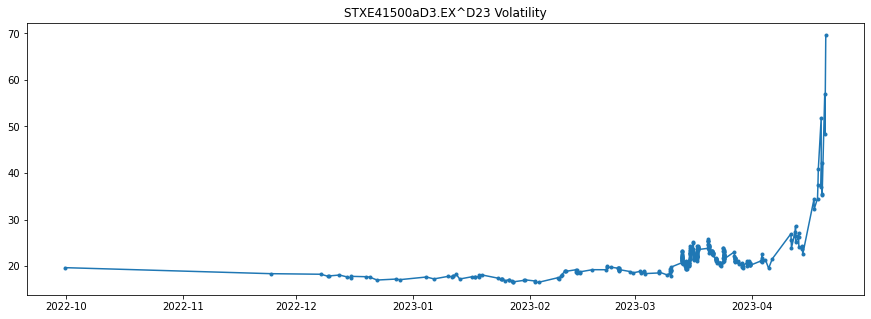

In [96]:
IIVNGIPAC_exp_optn_test3.simple_graph()

In [97]:
IIVNGIPAC_exp_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [98]:
IIVNGIPAC_exp_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [99]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test At Trade only:")
IIVNGIPAC_exp_optn_AT_test1 = IndxImpVolatNGreeksIPACalc(
    time_of_calc_datetime=datetime.strptime("2023-04-01", '%Y-%m-%d'),
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_exp_optn_AT_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_AT_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_exp_optn_AT_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_exp_optn_AT_test2.IPA_calc(
    debug=False,
    AT_opn_trade_only=True)
print(f"IIVNGIPAC_exp_optn_AT_test3.instrument: {IIVNGIPAC_exp_optn_AT_test3.instrument}")
print(f"IIVNGIPAC_exp_optn_AT_test3.ATM_opt: {IIVNGIPAC_exp_optn_AT_test3.ATM_opt}")
print(f"IIVNGIPAC_exp_optn_AT_test3.maturity: {IIVNGIPAC_exp_optn_AT_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_exp_optn_AT_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_exp_optn_AT_test3.instrument_info:")
    display(IIVNGIPAC_exp_optn_AT_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) expiered option test At Trade only:
IIVNGIPAC_exp_optn_AT_test3.instrument: STXE41500aD3.EX^D23
IIVNGIPAC_exp_optn_AT_test3.ATM_opt: STXE41500aD3.EX^D23
IIVNGIPAC_exp_optn_AT_test3.maturity: 2023-04-21 00:00:00


In [100]:
IIVNGIPAC_exp_optn_AT_test3.IPA_df.dropna()

,STXE41500aD3.EX^D23,MarketValueInDealCcy,RiskFreeRatePercent,UnderlyingPrice,Volatility,DeltaPercent,GammaPercent,RhoPercent,ThetaPercent,VegaPercent
gmt,Romance Summer Time,,,,,,,,,
2022-09-30 15:10:00,2022-09-30 17:10:00+02:00,11.9,1.173,3321.43,19.676604,0.059823,0.000243,1.035673,-0.127868,2.92606
2022-11-24 09:20:00,2022-11-24 11:20:00+02:00,102.3,1.908,3968.03,18.397388,0.347736,0.000789,5.166494,-0.514168,9.243615
2022-12-07 14:40:00,2022-12-07 16:40:00+02:00,80.5,1.977,3924.87,18.275026,0.305355,0.0008,4.116265,-0.511329,8.287841
2022-12-09 13:10:00,2022-12-09 15:10:00+02:00,80.2,2.005,3938.89,17.815883,0.310741,0.00083,4.150538,-0.507818,8.321074
2022-12-09 14:40:00,2022-12-09 16:40:00+02:00,80.3,2.005,3936.94,17.904541,0.310117,0.000825,4.137111,-0.510089,8.307865
...,...,...,...,...,...,...,...,...,...,...
2023-04-19 15:10:00,2023-04-19 17:10:00+02:00,247.0,3.052,4396.66,40.814211,0.972486,0.000475,0.219984,-2.055059,0.204632
2023-04-20 07:30:00,2023-04-20 09:30:00+02:00,230.5,3.052,4376.91,59.54261,0.933346,0.000826,0.13861,-7.647502,0.338876
2023-04-20 08:50:00,2023-04-20 10:50:00+02:00,229.0,3.052,4377.74,52.670422,0.95862,0.000653,0.136631,-4.717804,0.227065


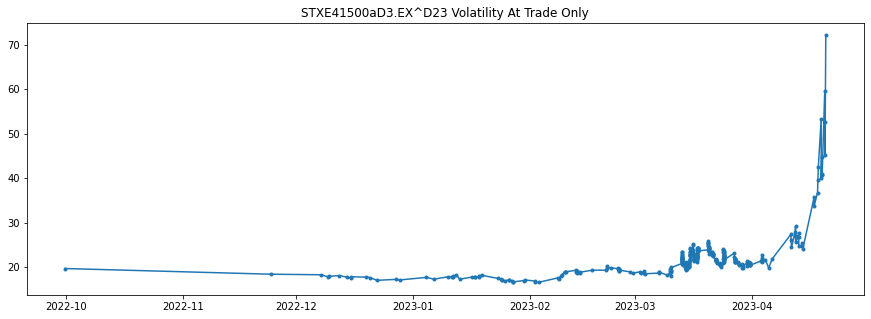

In [101]:
IIVNGIPAC_exp_optn_AT_test3.simple_graph()

In [102]:
IIVNGIPAC_exp_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [103]:
IIVNGIPAC_exp_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [104]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test:")
IIVNGIPAC_optn_test1 = IndxImpVolatNGreeksIPACalc(
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_optn_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_optn_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_test2.IPA_calc(
    date_back=30,
    debug=False,
    AT_opn_trade_only=False)
print(f"IIVNGIPAC_optn_test3.instrument: {IIVNGIPAC_optn_test3.instrument}")
print(f"IIVNGIPAC_optn_test3.ATM_opt: {IIVNGIPAC_optn_test3.ATM_opt}")
print(f"IIVNGIPAC_optn_test3.maturity: {IIVNGIPAC_optn_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_optn_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_optn_test3.instrument_info:")
    display(IIVNGIPAC_optn_test3.instrument_info)

Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test:


RDError: Error code None | Unable to calculate the Implied Volatility.

We are aware of the API limitations causing the error above. We are investigating it and will update this article in due time.

In [ ]:
IIVNGIPAC_optn_test3.IPA_df.dropna()

In [ ]:
IIVNGIPAC_optn_test3.simple_graph()

In [ ]:
IIVNGIPAC_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [ ]:
IIVNGIPAC_optn_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [ ]:
print("Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test At Trade only:")
IIVNGIPAC_optn_AT_test1 = IndxImpVolatNGreeksIPACalc(
    after=15,
    index_underlying=".STOXX50E",
    call_put='Call')
IIVNGIPAC_optn_AT_test2: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_AT_test1.search_index_opt_ATM(
    debug=False,
    call_or_put='Put',
    search_fields=["ExchangeCode", "UnderlyingQuoteName"],
    include_weekly_opts=False,
    top_nu_srch_results=10)
IIVNGIPAC_optn_AT_test3: IndxImpVolatNGreeksIPACalc = IIVNGIPAC_optn_AT_test2.IPA_calc(
    debug=False,
    AT_opn_trade_only=False)
print(f"IIVNGIPAC_optn_AT_test3.instrument: {IIVNGIPAC_optn_AT_test3.instrument}")
print(f"IIVNGIPAC_optn_AT_test3.ATM_opt: {IIVNGIPAC_optn_AT_test3.ATM_opt}")
print(f"IIVNGIPAC_optn_AT_test3.maturity: {IIVNGIPAC_optn_AT_test3.maturity}")
if pd.to_datetime(IIVNGIPAC_optn_AT_test3.maturity) > datetime.now():
    print(f"IIVNGIPAC_optn_AT_test3.instrument_info:")
    display(IIVNGIPAC_optn_AT_test3.instrument_info)

Syntax error in old cells


Index Implied Volatility aNd Greeks Instrument Pricing Analytics Calculation (IndxImpVolatNGreeksIPACalc) (IIVNGIPAC) non expiered option test At Trade only:


RDError: Error code None | Unable to calculate the Implied Volatility.

In [ ]:
IIVNGIPAC_optn_AT_test3.IPA_df.dropna()

In [ ]:
IIVNGIPAC_optn_AT_test3.simple_graph()

In [ ]:
IIVNGIPAC_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').overlay().fig

In [ ]:
IIVNGIPAC_optn_AT_test3.graph(mrkt_exhng_open_time='9:00', mrkt_exhng_close_time='17:00').stack3().fig

In [ ]:
rd.close_session() # close the RD session opend at the start

## Conclusion

As you can see, not only can we use IPA to gather large amounts of bespoke, calculated, values, but be can also portray this insight in a simple, quick and relevent way!

## References

[Brilliant: Black-Scholes-Merton](https://brilliant.org/wiki/black-scholes-merton/)

[What is the RIC syntax for options in Refinitiv Eikon?](https://my.refinitiv.com/content/mytr/en/faqs/2016/09/000195632.html)

[Functions to find Option RICs traded on different exchanges](https://developers.refinitiv.com/en/article-catalog/article/functions-to-find-option-rics-traded-on-different-exchanges#2.4-Function-for-the-EUREX)

[Eikon Calc Help Page](https://emea1.apps.cp.thomsonreuters.com/Apps/AdfinLibrary/?cshid=AdBondDeriv&srv=PLNP-ERPCPRP04)

[Making your code faster: Cython and parallel processing in the Jupyter Notebook](https://www.youtube.com/watch?v=MiHddLYZ6cQhttps://www.youtube.com/watch?v=MiHddLYZ6cQ)

[What Happens to Options When a Stock Splits?](https://www.youtube.com/watch?v=rnTREPigNns)

[Select column that has the fewest NA values](https://stackoverflow.com/questions/50496618/select-column-that-has-the-fewest-na-values)

[Return Column(s) if they Have a certain Percentage of NaN Values (Python)](https://stackoverflow.com/questions/59161809/return-columns-if-they-have-a-certain-percentage-of-nan-values-python)

[How to Split a String Between Numbers and Letters?](https://www.youtube.com/watch?v=iu2lAZJfXHo)

### Q&A

[RIC nomenclature for expired Options on Futures](https://community.developers.refinitiv.com/questions/82796/ric-nomenclature-for-expired-options-on-futures.html)

[Expiration Dates for Expired Options API](https://community.developers.refinitiv.com/questions/69830/expiration-dates-for-expired-options-api.html)

[Measure runtime of a Jupyter Notebook code cellMeasure runtime of a Jupyter Notebook code cell](https://stackoverflow.com/questions/43307653/measure-runtime-of-a-jupyter-notebook-code-cellhttps://stackoverflow.com/questions/43307653/measure-runtime-of-a-jupyter-notebook-code-cell)

[What does these parameters mean in jupyter notebook when I input "%%time"?What does these parameters mean in jupyter notebook when I input "%%time"?](https://stackoverflow.com/questions/48202900/what-does-these-parameters-mean-in-jupyter-notebook-when-i-input-timehttps://stackoverflow.com/questions/48202900/what-does-these-parameters-mean-in-jupyter-notebook-when-i-input-time)

## Appendix

### No Intra Day Price Data Is Available For Old Expired Options

In [ ]:
# import refinitiv.data as rd
# rd.get_config().set_param(
#     param=f"logs.transports.console.enabled", value=True
# )
# session = rd.open_session("desktop.workspace")
# session.set_log_level("DEBUG")

In [ ]:
# SPX_testoptn_mrkt_pr10min = rd.get_history(
#     universe=list(SPX_test['valid_ric'][0].keys())[0],
#     fields=["TRDPRC_1"],
#     interval="10min",
#     start='2021-10-25T11:53:09.168706',
#     end='2021-10-26T19:53:10.166926')  # Ought to always end at 8 pm for OPRA exchanged Options, more info in the article below
# SPX_testoptn_mrkt_pr

In [ ]:
# SPX_testoptn_mrkt_pr1d = rd.content.historical_pricing.summaries.Definition(
#     universe=list(SPX_test['valid_ric'][0].keys())[0],
#     start='2021-10-23',
#     end='2021-10-29',
#     fields=['BID', 'ASK', 'TRDPRC_1'],
#     interval=rd.content.historical_pricing.Intervals.DAILY).get_data()

In [ ]:
SPX_testoptn_mrkt_pr1d.data.df

In [ ]:
# SPX_testoptn_mrkt_prTest = rd.content.historical_pricing.summaries.Definition(
#     interval=rd.content.historical_pricing.Intervals.FIVE_MINUTES,
# #     interval='PT1H',
#     universe=list(SPX_test['valid_ric'][0].keys())[0],
#     start='2021-10-25T10:53:09.168706',
#     end='2021-10-27T19:53:10.166926',
#     fields=['BID', 'ASK', 'TRDPRC_1']).get_data()

In [ ]:
# SPX_testoptn_mrkt_prTest.errors

In [ ]:
# SPX_testoptn_mrkt_prTest.get_data().data.df

In [ ]:
# SPX_testoptn_mrkt_prTest

In [ ]:
ek = rd.eikon
# The key is placed in a text file so that it may be used in this code without showing it itself:
eikon_key = open("eikon.txt", "r")
ek.set_app_key(str(eikon_key.read()))
# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to:
eikon_key.close()

In [ ]:
testDf, err = ek.get_data(
    instruments=list(SPX_test['valid_ric'][0].keys())[0],
    fields=['TRDPRC_1'],
    parameters={
        'SDate': '2021-10-25T10:53:09.168706',
        'EDate': '2021-10-28T19:53:10.166926'})

In [ ]:
testDf

### Equity Option Price Adjustments to Corporate Actions

We're lucky in that indexes's prices are adjusted automatically to corporate actions, so we do't have to take them into account in our calculations. However, we would have to if we focussed on Equities. If this is the case you're interested in, don't hesitate to use the below which should work with the functions above:

In [ ]:
def Get_trans_days(year, mcal_get_calendar='EUREX', trans_day='first'):
    '''
    Get_trans_days Version 2.0:

    This function gets transaction days for each month of a specified year.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code to allow
        (i) function name changed from `get_trans_days` to `Get_trans_days`
        (ii) for the function's holiday argument to be changed, allowing for any calendar supported by `mcal.get_calendar` and defaulted to 'EUREX' as opposed to 'CBOE_Index_Options' and

    Dependencies
    ----------------------------------------------
    import datetime.timedelta as timedelta. (This is a native Python library, so it ought to be version '3.8.12'.)
    Python library 'pandas_market_calendars' version '3.2'.
    pandas_market_calendars as mcal version '4.1.0'

    Parameters
    -----------------------------------------------
    Arguments:
        year (int):
            Year for which transaction days are requested

        mcal_get_calendar(str):
            String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'

        trans_day (str):
            Takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
            Default: trans_day='first'

    Output:
        trans_days (list):
            List of days for 12 month
    '''
    # get the first business day of each month
    if trans_day == 'first':
        mkt = mcal.get_calendar(mcal_get_calendar)
        holidays = mkt.holidays().holidays

        # set start and end day ranges
        start_date, end_date = f"{str(year)}-01-01", f"{str(year)}-12-31"
        trans_days = []

        for date in pd.date_range(start_date, end_date, freq='BMS'):
            # get the first day after the weekend after checking for holiday
            while date.isoweekday() > 5 or date in holidays:
                date += timedelta(1)
            # add found day to the list
            trans_days.append(date.date().day)

    # get the 3rd Friday for each month by calling function "get_exp_dates"
    elif trans_day == 'third':
        trans_days = get_exp_dates(year)[year]
    else:
        print('Please input "first" or "third" for transaction day')
        return
    return trans_days

In [ ]:
def Adjustment_factor(corp_event, year=None, date=None, trans_day='first', mcal_get_calendar='EUREX'):
    '''
    Adjustment_factor Version 2.0:

    This function gets adjustment factor(s) of stock split for a given asset. If no split event is happened during the requested period
    function returns 1(if date argument is used) or list of twelve 1s (if year argument is used), which assumes no adjustment in prices.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code:
        (i) function name changed from `adjustment_factor` to `Adjustment_factor`.

    Dependencies
    ----------------------------------------------
    Python library 'pandas_market_calendars' version 3.2

    Parameters
    -----------------------------------------------
    Input:
        asset (str):
            RIC code of the asset
        year (int):
            Year for which stock split events are requested
        date (str with date (YYYY-MM-DD) format):
            Date as of which stock split events are requested
        trans_day (str, default = 'first'):
            Indicates the date of the transaction for get_trans_days function
        mcal_get_calendar(str):
            String of the calendar for which holidays have to be taken into account. More on this calendar (link to Github checked 2022-10-11): https://github.com/rsheftel/pandas_market_calendars/blob/177e7922c7df5ad249b0d066b5c9e730a3ee8596/pandas_market_calendars/exchange_calendar_cboe.py
            Default: mcal_get_calendar='EUREX'
    Output:
        adj_factor (float): This is returned in case of date argument is used. The output is the Adjustment factor after split
        adj_factors(list): This is returned in case of year argument is used. The output is the list of Adjustment factors after split for each month
    '''
    # if there is no stock split corporate event
    if (corp_event is None) or (corp_event['Capital Change Effective Date'][0] is None):
        if year is not None and date is None:
            # return list of 1s if year argument is used
            adj_factors = 12 * [1]
            return adj_factors
        elif date is not None and year is None:
            # return 1 if exact date argument is used
            adj_factor = 1
            return adj_factor
        else:
            print('Either Year or exact date needs to be passed to the function')
    # if there is an event adjustment factor(s) is(are) calculated
    else:
        if year is not None and date is None:  # in case of year argument is used
            # request transaction dates
            trans_days = Get_trans_days(year=year, mcal_get_calendar='EUREX', trans_day=trans_day)
            adj_factors = []
            for i in range(1, 13):
                # get exp_dates and use it as a request date for stock split corporate events
                exp_date = str(year) + '-' + str(i) + '-' + str(trans_days[i - 1])
                # initiate adj_factor with 1
                adj_factor = 1
                # we first check if the expiration date of option is after or before the adjustment date
                for j in reversed(range(len(corp_event))):
                    # if expiration date is smaller than adjustment date then we need adjustment
                    if pd.to_datetime(exp_date).strftime('%Y-%m-%d') < pd.to_datetime(corp_event['Capital Change Effective Date'][j]).strftime('%Y-%m-%d'):
                        adj_factor = float(corp_event['Adjustment Factor'][j]) * adj_factor # we should consider all adjustment factors which are after the expiration day
                # append adjustment factor of the month to the list
                adj_factors.append(adj_factor)
            return adj_factors

        elif date is not None and year is None:  # In case exact date  argument is ued
            adj_factor = 1
            for j in reversed(range(len(corp_event))):
                # if expiration date is smaller than adjustment date then we need adjustment
                if pd.to_datetime(date).strftime('%Y-%m-%d') < corp_event['Capital Change Effective Date'][j]:
                    adj_factor = float(corp_event['Adjustment Factor'][j]) * adj_factor
            return adj_factor
        else:
            print('Either Year or exact date needs to be passed to the function')

In [ ]:
def Get_potential_rics(year, trans_day, asset, OTM_size, diff, opt_type, reportLog=True, debug=False):
    '''
    Get_potential_rics Version 2.0:
    This function returns the list of potential option RICs for a specified year reconstructed based on Refinitiv RIC and option trading rules.

    Changes
    ----------------------------------------------
    Changed from Version 1.0 to 2.0: Jonathan Legrand changed Haykaz Aramyan's original code:
        (i) function name changed from `get_potential_rics` to `Get_potential_rics`
        (ii) changed function body to reflect changed funciton name from `get_trans_days` to `Get_trans_days`
        (iii) added argument `reportLog`, a boolean value that, if left to default `True`, report log of the function output

    Dependencies
    ----------------------------------------------
    Python library 'Refinitiv Dataplatform' version 1.0.0a8.post1

    Parameters
    -----------------------------------------------
    Input:
        year (int): year for which transaction days are requested
        trans_day (str, default = 'first'): takes either 'first' or 'third' indicating to the first business day or the 3rd Friday of a month respectively
        asset (str): RIC code of the asset
        OTM_size (int): percentage number indicating how far away is the strike price from the price of the underlying asset
        diff (int): Tolarated difference in OTM to construct upper and lower bounds of strike prices
        opt_type (str): takes either "call" or "put"
        reportLog (bool): report log of the function output if True. Default: reportLog=True.

    Output:
        Tuple of two objects:
            potential_RICs (dict): dictionary containing potential RICs for each month with strike prices from the lower to upper bounds of strikes
            strikes (list): list of the strike prices calculated based on OTM size for each month
    '''

    # open file to report log of the function output
    if reportLog:
        report = open("Log report.txt", "a")

    # call functions to get expiration and transaction days
    trans_days = Get_trans_days(
        year=year, mcal_get_calendar='EUREX', trans_day=trans_day)
    trans_days_prev = Get_trans_days(
        year=year-1, mcal_get_calendar='EUREX', trans_day=trans_day)
    dates = get_exp_dates(year)

    # trim underlying asset's RIC to get the required part for option RIC
    if asset[0] == '.':  # check if the asset is an index or an equity
        asset_name = asset[1:]  # get the asset name - we remove "." symbol for index options
        adj_factors = 12 * [1]  # set adjustment factors to be equal to 1 for each month (no stock split corporate event is applicable to indices)
    else:
        asset_name = asset.split('.')[0]  # we need only the first part of the RICs for equities
        # get list of corporate events for equities
        if debug: print(f"asset: {asset}")
        corp_event = rd.get_data(
            universe=asset,
            fields=["TR.CAEffectiveDate", "TR.CAAdjustmentFactor", "TR.CAAdjustmentType"],
            parameters={
                "CAEventType": "SSP",
                "SDate": datetime.today().strftime("%Y-%m-%d"),
                "EDate": "-50Y"})
        if debug: print(f"corp_event: {corp_event}")
        # run adjustment_factor function to get the factors
        adj_factors = Adjustment_factor(corp_event, year=year, trans_day=trans_day)

    # define expiration month codes to be used after "^" sign
    exp = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
    potential_RICs = {}
    strikes = []

    # construct potential RICs for each month of a specified year
    for j in range(1, 13):
        # get day of expiration for a month
        day = dates[year][j - 1]
        # get date of price request, which is in the previous month of expiration 
        if j != 1:
            date = str(year) + '-' + str(j - 1) + '-' + str(trans_days[j - 2])
        if j == 1:  # for January, we need to subtract a year along with the month
            date = str(year - 1) + '-' + str(j + 11) + '-' + str(trans_days_prev[j + 10])
        # get price of underlying asset as of the transaction date

        # get the corresponding adjustment factor for the month
        adj_factor = adj_factors[j-1]

        price = rd.get_data(
            asset,
            fields=['TR.PriceClose'],
            parameters={'SDate': date})
        price = float(price.iloc[0, 1]) / adj_factor  # adjust prices by the adjustment factor. if no sptick split events adj_factor = 1

        # calculate the strike price for call options
        if opt_type.lower() == 'call':
            strike = price + price * OTM_size / 100
            # define expiration month codes for call options while also considering the strike price
            if strike > 999.999:
                exp_codes_call = [
                    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l']
            else:
                exp_codes_call = [
                    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
            # get expiration month code for a month
            exp_month = exp_codes_call[j-1]

        # calculate the strike price and get expiration month code for a month for put options
        elif opt_type.lower() == 'put':
            strike = price - price * OTM_size/100
            if strike > 999.999:
                exp_codes_put = [
                    'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x']
            else:
                exp_codes_put = [
                    'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']
            exp_month = exp_codes_put[j-1]

        strikes.append(int(round(strike, 0)))  # append the calculated strike price to the list of strikes

        # calculate lower and upper bounds for strikes considering the value of the strike
        if strike > 999.999:
            step = 5  # we loop over strikes with a step 5 for larger strikes
            strike_ub = int(round((strike + strike * diff / 100),-1))
            strike_lb = int(round((strike - strike * diff / 100),-1))
        else:
            step = 1  # we loop over strikes with a step 1 for smaller strikes
            strike_ub = int(strike + strike * diff / 100)
            strike_lb = int(strike - strike * diff / 100)

        # construct RICs for each strike from the lower to upper bound ranges of strikes
        for n in range(strike_lb, strike_ub + step, step):
            k = None  # for strikes < 1000 along with 1 step increment change in strikes we do 0.5 point increment change which 
                      # allows us to consider strikes with decimal points. This is important to get closer OTMs for smaller valued assets.
            # here we construct option RICs by adding together all the RIC components
            # Please note some of the components are different depending on the strike value
            plc_holdr1 = asset_name + exp_month + str(day) + str(year)[-2:]
            plc_holdr2 = exp[j - 1] + str(year)[-2:]
            if n < 10:
                z = plc_holdr1 + '00' + str(n) + '00.U^' + plc_holdr2# for integer steps
                k = plc_holdr1 + '00' + str(n) + '50.U^' + plc_holdr2# for decimal steps
            elif n >= 10 and n < 100:
                z = plc_holdr1 + '0' + str(n) + '00.U^' + plc_holdr2
                k = plc_holdr1 + '0' + str(n) + '50.U^' + plc_holdr2
            if n >= 100 and n < 1000:
                z = plc_holdr1 + str(n) + '00.U^' + plc_holdr2  
                k = plc_holdr1 + str(n) + '50.U^' + plc_holdr2
            elif n >= 1000 and n < 10000:
                z = plc_holdr1 + str(n) + '0.U^' + plc_holdr2
            elif n >= 10000 and n < 20000:
                z = plc_holdr1 + 'A' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 20000 and n < 30000:
                z = plc_holdr1 + 'B' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 30000 and n < 40000:
                z = plc_holdr1 + 'C' + str(n)[-4:] + '.U^' + plc_holdr2
            elif n >= 40000 and n < 50000:
                z = plc_holdr1 + 'D' + str(n)[-4:] + '.U^' + plc_holdr2

            # append RICs with integer strikes to the dictionary
            if j in potential_RICs:
                potential_RICs[j].append(z)
                # append RICs with decimal point strikes to the dictionary
                if k is not None:
                    potential_RICs[j].append(k)
            else:
                potential_RICs[j] = [z]
                if k is not None:
                    potential_RICs[j].append(k)

    # report funtion results and close the log file
    if reportLog:
        now = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
        report.write(f'{now}: Potential RICs for {opt_type} options with {OTM_size}% OTM for {year} are constructed\n')
        report.close()
    return potential_RICs, strikes

In [ ]:
call_RICs, call_strikes = Get_potential_rics(
    year=2017,
    trans_day='first',
    asset='.STOXX50E',
    OTM_size=5,
    diff=3,
    opt_type='call',
    reportLog=True,
    debug=False)

In [ ]:
print(call_strikes)

In [ ]:
rd.get_data(
    '.STOXX50E',
    fields=['TR.CAAdjustmentFactor(SDate=2017-01-01,EDate=2018-12-31)'])

### Troubleshooting IPA

I then gathered data on two Options, a live one ('STXE42000D3.EX') and an expired one ('HSI19300N3.HF^B23').

In [ ]:
import refinitiv.data as rd
import refinitiv.data.content.ipa.financial_contracts as rdf
from refinitiv.data.content.ipa.financial_contracts import option
import pandas as pd

# Let's authenticate ourseves to LSEG's Data and Analytics service, Refinitiv:
try:  # The following libraries are not available in Codebook, thus this try loop
    rd.open_session(config_name="C:\\Example.DataLibrary.Python-main\\Example.DataLibrary.Python-main\\Configuration\\refinitiv-data.config.json")
    rd.open_session("desktop.workspace")
except:
    rd.open_session()

In [ ]:
def Chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [ ]:
HSI_test0 = rd.content.historical_pricing.summaries.Definition(
    'STXE42000D3.EX',
    interval=rd.content.historical_pricing.Intervals.DAILY,
    fields=['SETTLE'],
    start='2022-11-07',
    end='2023-02-01').get_data().data.df
hk_rf = 100 - rd.get_history(
    universe=['HK3MT=RR'],  # HK10YGB=EODF, HKGOV3MZ=R, HK3MT=RR
    fields=['TR.MIDPRICE'],
    start=HSI_test0.index[0].strftime('%Y-%m-%d'),
    end=HSI_test0.index[-1].strftime('%Y-%m-%d'))
HSI_test1 = pd.merge(
    HSI_test0, hk_rf, left_index=True, right_index=True)
HSI_test1 = HSI_test1.rename(
    columns={"SETTLE": "OptionPrice", "Mid Price": "RfRatePrct"})
hist_HSI_undrlying_pr = rd.get_history(
    universe=[HSI_underlying_RIC],
    fields=["TRDPRC_1"],
    # interval="1D",
    start=HSI_test0.index[0].strftime('%Y-%m-%d'),
    end=HSI_test0.index[-1].strftime('%Y-%m-%d'))
HSI_test2 = pd.merge(HSI_test1, hist_HSI_undrlying_pr,
                    left_index=True, right_index=True)
HSI_test2 = HSI_test2.rename(
    columns={"TRDPRC_1": "UndrlyingPr"})
HSI_test2.columns.name = 'STXE42000D3.EX'
HSI_test2

#### Delivery Layer

In [ ]:
request_fields = ['MarketValueInDealCcy', 'RiskFreeRatePercent', 'UnderlyingPrice', 'PricingModelType', 'DividendType', 'UnderlyingTimeStamp', 'ReportCcy', 'VolatilityType', 'Volatility', 'DeltaPercent', 'GammaPercent', 'RhoPercent', 'ThetaPercent', 'VegaPercent']

##### Live Option

In [ ]:
live_universe = [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": 'STXE42000D3.EX',
            "strike": float(4200),
          },
          "pricingParameters": {
            "marketValueInDealCcy": float(HSI_test2['OptionPrice'][i]),
            "riskFreeRatePercent": float(HSI_test2['RfRatePrct'][i]),
            "underlyingPrice": float(HSI_test2['UndrlyingPr'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "HKD"
          }
        }
      for i in range(len(HSI_test2.index))]

In [ ]:
batch_of = 100
for i, j in enumerate(Chunks(live_universe, 100)):
    print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(live_universe, batch_of)]))} started")
    # Example request with Body Parameter - Symbology Lookup
    live_troubleshoot_request_definition = rd.delivery.endpoint_request.Definition(
        method=rd.delivery.endpoint_request.RequestMethod.POST,
        url='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        body_parameters={"fields": request_fields,
                         "outputs": ["Data", "Headers"],
                         "universe": j})

    live_troubleshoot_resp = live_troubleshoot_request_definition.get_data()
    headers_name = [h['name'] for h in live_troubleshoot_resp.data.raw['headers']]

    if i == 0:
        live_troubleshoot_df = pd.DataFrame(
            data=live_troubleshoot_resp.data.raw['data'],
            columns=headers_name)
    else:
        _live_troubleshoot_df = pd.DataFrame(
            data=live_troubleshoot_resp.data.raw['data'],
            columns=headers_name)
        live_troubleshoot_df = live_troubleshoot_df.append(_live_troubleshoot_df, ignore_index=True)
    print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(live_universe, batch_of)]))} ended")

In [ ]:
live_troubleshoot_df

##### Expired Option

In [ ]:
hist_universe = [
        {
          "instrumentType": "Option",
          "instrumentDefinition": {
            "buySell": "Buy",
            "underlyingType": "Eti",
            "instrumentCode": 'HSI19300N3.HF^B23',
            "strike": float(4200),
          },
          "pricingParameters": {
            "marketValueInDealCcy": float(HSI_test2['OptionPrice'][i]),
            "riskFreeRatePercent": float(HSI_test2['RfRatePrct'][i]),
            "underlyingPrice": float(HSI_test2['UndrlyingPr'][i]),
            "pricingModelType": "BlackScholes",
            "dividendType": "ImpliedYield",
            "volatilityType": "Implied",
            "underlyingTimeStamp": "Default",
            "reportCcy": "HKD"
          }
        }
      for i in range(len(HSI_test2.index))]

In [ ]:
for i, j in enumerate(Chunks(hist_universe, 100)):
    print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(hist_universe, batch_of)]))} started")
    # Example request with Body Parameter - Symbology Lookup
    hist_troubleshoot_request_definition = rd.delivery.endpoint_request.Definition(
        method=rd.delivery.endpoint_request.RequestMethod.POST,
        url='https://api.refinitiv.com/data/quantitative-analytics/v1/financial-contracts',
        body_parameters={"fields": request_fields,
                         "outputs": ["Data", "Headers"],
                         "universe": j})

    hist_troubleshoot_resp = hist_troubleshoot_request_definition.get_data()
    headers_name = [h['name'] for h in hist_troubleshoot_resp.data.raw['headers']]

    if i == 0:
        hist_troubleshoot_df = pd.DataFrame(
            data=hist_troubleshoot_resp.data.raw['data'],
            columns=headers_name)
    else:
        _hist_troubleshoot_df = pd.DataFrame(
            data=hist_troubleshoot_resp.data.raw['data'],
            columns=headers_name)
        hist_troubleshoot_df = hist_troubleshoot_df.append(_hist_troubleshoot_df, ignore_index=True)
    print(f"Batch of {batch_of} requests no. {str(i+1)}/{str(len([i for i in Chunks(hist_universe, batch_of)]))} ended")

In [ ]:
hist_troubleshoot_df

#### Content Layer

In [ ]:
live_hist_daily_universe_l = [
    option.Definition(
        underlying_type=option.UnderlyingType.ETI,
        buy_sell='Buy',
        instrument_code='STXE42000D3.EX',  # 'STXE42000D3.EX' #  'HSI19300N3.HF^B23',  # list(HSI_test2['valid_ric'][0].keys())[0],
        strike=float(4200),
        pricing_parameters=option.PricingParameters(
            market_value_in_deal_ccy=float(HSI_test2['OptionPrice'][i]),
            risk_free_rate_percent=float(HSI_test2['RfRatePrct'][i]),
            underlying_price=float(HSI_test2['UndrlyingPr'][i]),
            pricing_model_type='BlackScholes',
            volatility_type='Implied',
            underlying_time_stamp='Default',
            report_ccy='HKD'
        ))
    for i in range(len(HSI_test2.index))]

In [ ]:
for i, j in enumerate(Chunks(live_hist_daily_universe_l, 100)):
    print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(hist_daily_universe_l, 100)])} started")
    # Example request with Body Parameter - Symbology Lookup
    troubleshoot_resp_live = rdf.Definitions(universe=j, fields=request_fields)
    troubleshoot_resp_live_getdata = troubleshoot_resp_live.get_data()
    if i == 0:
        troubleshoot_resp_live_df = troubleshoot_resp_live_getdata.data.df
    else:
        troubleshoot_resp_live_df = troubleshoot_resp_live_df.append(
            troubleshoot_resp_live_getdata.data.df, ignore_index=True)
    print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(hist_daily_universe_l, 100)])} ended")

In [ ]:
troubleshoot_resp_live_df

In [ ]:
exp_hist_daily_universe_l = [
    option.Definition(
        underlying_type=option.UnderlyingType.ETI,
        buy_sell='Buy',
        instrument_code='HSI19300N3.HF^B23',  # 'STXE42000D3.EX' #  'HSI19300N3.HF^B23'
        strike=float(hist_opt_found_strk_pr),
        pricing_parameters=option.PricingParameters(
            market_value_in_deal_ccy=float(HSI_test2['OptionPrice'][i]),
            risk_free_rate_percent=float(HSI_test2['RfRatePrct'][i]),
            underlying_price=float(HSI_test2['UndrlyingPr'][i]),
            pricing_model_type='BlackScholes',
            volatility_type='Implied',
            underlying_time_stamp='Default',
            report_ccy='HKD'
        ))
    for i in range(len(HSI_test2.index))]

In [ ]:
for i, j in enumerate(Chunks(exp_hist_daily_universe_l, 100)):
    print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(exp_hist_daily_universe_l, 100)])} started")
    # Example request with Body Parameter - Symbology Lookup
    troubleshoot_resp_exp = rdf.Definitions(universe=j, fields=request_fields)
    troubleshoot_resp_exp_getdata = troubleshoot_resp_exp.get_data()
    if i == 0:
        troubleshoot_resp_exp_df = troubleshoot_resp_exp_getdata.data.df
    else:
        troubleshoot_resp_exp_df = troubleshoot_resp_exp_df.append(
            troubleshoot_resp_exp.data.df, ignore_index=True)
    print(f"Batch of {len(j)} requests no. {i+1}/{len([i for i in Chunks(exp_hist_daily_universe_l, 100)])} ended")

In [ ]:
troubleshoot_resp_exp_df

### [How can I specify a module as a Type Hint in Python?](https://stackoverflow.com/questions/77149892/how-can-i-specify-a-tzinfo-object-as-a-type-hint-in-python)

In [ ]:
datetime.now().astimezone().tzinfo

In [ ]:
print(type(datetime.now().astimezone().tzinfo))

In [ ]:
import nb_mypy  # !pip3 install nb_mypy --trusted-host pypi.org # https://pypi.org/project/nb-mypy/ # https://gitlab.tue.nl/jupyter-projects/nb_mypy/-/blob/master/Nb_Mypy.ipynb
%load_ext nb_mypy
%reload_ext nb_mypy
%nb_mypy On
%nb_mypy DebugOff

In [ ]:
import pytz
from datetime import datetime, timedelta, date, timezone
from dateutil.relativedelta import relativedelta
from typing import Generator, Any
from types import ModuleType
from pytz.tzinfo import DstTzInfo, StaticTzInfo

In [ ]:
time_zn_in_graph: timezone = datetime.now().astimezone().tzinfo
print(time_zn_in_graph)

## References

[Type Hinting for Dictionaries in Python](https://dev.to/serhatteker/type-hinting-for-dictionaries-in-python-5e1k)

[Python Type Hints - How to Narrow Types with isinstance(), assert, and Literal](https://adamj.eu/tech/2021/05/17/python-type-hints-how-to-narrow-types-with-isinstance-assert-literal/)

[Python Type Hints - How to Narrow Types with TypeGuard](https://adamj.eu/tech/2021/06/09/python-type-hints-how-to-narrow-types-with-typeguard/)

[DATA CLASSES](https://www.youtube.com/watch?v=vRVVyl9uaZc)

[Indicating multiple value in a Dict for type hints](https://stackoverflow.com/questions/48054521/indicating-multiple-value-in-a-dict-for-type-hints)

[How to annotate types of multiple return values?](https://stackoverflow.com/questions/40181344/how-to-annotate-types-of-multiple-return-values)

[Type Hinting - Advanced Python Tutorial #6](https://www.youtube.com/watch?v=6KidYEtspNc)

[Type hints when unpacking a tuple?](https://stackoverflow.com/questions/52082939/type-hints-when-unpacking-a-tuple)

[Mypy error - incompatible types in assignment](https://stackoverflow.com/questions/43910979/mypy-error-incompatible-types-in-assignment)

[Is it possible to let mypy check that attribute exists in at least one union item (instead of each union item)?](https://stackoverflow.com/questions/72899072/is-it-possible-to-let-mypy-check-that-attribute-exists-in-at-least-one-union-ite)

[mypy error - incompatible type despite using 'Union'](https://stackoverflow.com/questions/43982085/mypy-error-incompatible-type-despite-using-union?rq=4)

[Cannot Edit Default VSCode JSON Settings](https://stackoverflow.com/questions/63211082/cannot-edit-default-vscode-json-settings)

## Notes

You may want to improve the above, e.g.:

### Add Automatic TimeZones

You may want to use the RD library in a similar way to EDAPI below to get timezones automatically:

<img src="../Docs/AutoTimeZones.png">